In [2]:
from google.colab import drive
from google.colab import files

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torch.utils.data import DataLoader

from scipy import stats
from scipy.stats import norminvgauss, norm, pareto, levy_stable

import random

import torchvision

import tqdm
from tqdm import trange

import pandas as pd
import csv


from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def get_accuracy(model, dataloader, device):
    correct = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            prediction = model(x).argmax(dim=-1, keepdim=True)
            correct += prediction.eq(y.view_as(prediction)).sum().item()
    return correct / len(dataloader.dataset)


class Monitor:
    def __init__(self):
        if hasattr(tqdm.tqdm, '_instances'):
            [*map(tqdm.tqdm._decr_instances, list(tqdm.tqdm._instances))]

        self.learning_curve = []
        self.train_accuracy_curve = []
        self.val_accuracy_curve = []
        self.best_val_accuracy = 0
        self.best_val_epoch = 0

    def add_loss_value(self, value):
        self.learning_curve.append(value)

    def add_train_accuracy_value(self, value):
        self.train_accuracy_curve.append(value)

    def add_val_accuracy_value(self, value):
        self.val_accuracy_curve.append(value)

        if value > self.best_val_accuracy:
            self.best_val_accuracy = value
            self.best_val_epoch = len(self.val_accuracy_curve)

    def show(self):
        display.clear_output(wait=True)
        f, axes = plt.subplots(1, 2, figsize=(15, 3))
        axes[0].set_title('Loss')
        axes[0].plot(self.learning_curve)

        last_train_accuracy = self.train_accuracy_curve[-1]
        last_val_accuracy = self.val_accuracy_curve[-1]
        best_val_accuracy = self.best_val_accuracy
        best_val_accuracy = self.best_val_accuracy

        axes[1].set_title(f'Train {last_train_accuracy:.4f}, val {last_val_accuracy:.4f}, '
                          f'max val {self.best_val_accuracy:.4f} at {self.best_val_epoch}')
        axes[1].plot(self.train_accuracy_curve)
        axes[1].plot(self.val_accuracy_curve)

        plt.tight_layout()
        plt.show()


def set_random_seeds(seed_value=0, device='cpu'):
    '''source https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/5'''
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu':
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [5]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
Tesla T4


## 1 Fully-connected network (FCN) on the MNIST 
For this model,
we vary the depth (i.e. the total number of layers) in the set {2, 3, . . . , 10}, the width (i.e. the number
of neurons per hidden layer) in the set {2, 4, 8, . . . , 1024}, and the minibatch size ranging from 1 to
full batch.

In [6]:
class FullyConnected(nn.Module):

    def __init__(self, input_dim=28*28, width=16, depth=3, num_classes=10):
        super(FullyConnected, self).__init__()
        self.input_dim = input_dim
        self.width = width
        self.depth = depth
        self.num_classes = num_classes

        layers = self.get_layers()

        self.fcn = nn.Sequential(
            nn.Linear(self.input_dim, self.width, bias=False),
            nn.ReLU(inplace=True),
            *layers,
            nn.Linear(self.width, self.num_classes, bias=False),
        )

    def get_layers(self):

        layers = []
        for _ in range(self.depth - 2):
            layers.append(nn.Linear(self.width, self.width, bias=False))
            layers.append(nn.ReLU())
        return layers

    def forward(self, x):
        r"""
        Parameters
        ----------
        x : torch.Tensor
            of shape [batch_size, channels_n, height, width]
        
        Returns
        -------
        y : torch.Tensor
            of shape [batch_size, classes_n]
        """
        x = x.view(x.size(0), self.input_dim)
        x = self.fcn(x)
        return x

# Convolutional network Lenet 

In [4]:
Lenetcnn = nn.Sequential(nn.Conv2d(in_channels=1,out_channels=6,kernel_size=(5,5),stride=1),
                    nn.ReLU(),
                    nn.MaxPool2d((2,2)),
                    nn.Conv2d(in_channels=6,out_channels=16,kernel_size=(3,3),stride=1),
                    nn.ReLU(),
                    nn.MaxPool2d((2,2)),
                   
                    nn.Flatten(),
                    nn.Linear(400,84),
                    nn.ReLU(),
                    nn.Linear(84,10),
                    nn.Softmax())

## 2 Training procedure

In [9]:
# we choose the device that we will work on --- GPU or CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [10]:
# Method for gathering gradients from NN
def get_grads(model):
    grads = []
    for param in model.parameters():
        if param.requires_grad == True:
            grads.append(param.grad.view(-1))
    grad_flat = torch.cat(grads)
    return grad_flat

def save_grads(model, optimizer, loss_function, train_loader, device, filepath, log_num_iter):
    with open(filepath + f'_epoch_logiter_{log_num_iter}.npy', 'ab') as file:

        for model_input_gr, target_gr in train_loader:
            model_input_gr = model_input_gr.to(device)
            target_gr = target_gr.to(device)
            model_output_gr = model(model_input_gr)
            loss_gr= loss_function(model_output_gr, target_gr)
            optimizer.zero_grad()
            #calc the gradient on batch
              # ? do we need retain_grads=False
            loss_gr.backward()
              #store the gradient
              #Full gradient will be calculated later, 
              #as mean of the saved gradients of all batches 
            grad = get_grads(model).cpu()
            np.save(file, grad.numpy())


def train(model, optimizer, loss_function, train_loader, val_loader, device, filepath, epochs=1, plot_each=1, log_iter=100):
    # send the model to that device
    model = model.to(device)
    monitor = Monitor()
    
    log_num_iter=0
    for epoch in trange(epochs):
        model.train()
        
        for iter, (model_input, target)  in enumerate(train_loader):
            
            #Idea1 no batches full data-> bad runtime out of memory
            # send data to device
            model_input = model_input.to(device)
            target = target.to(device)
            # calculate outputs and loss
            model_output = model(model_input)
            loss = loss_function(model_output, target)
            # update model weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()        
            # do some visualization
            monitor.add_loss_value(loss.item())
            #calculate grad on iteration
            if (iter+1) % log_iter == 0:
                log_num_iter+=1
                with open(filepath + f'_logiter_{log_num_iter}.npy', 'ab') as file:
                    for model_input_gr, target_gr in train_loader:
                        model_input_gr = model_input_gr.to(device)
                        target_gr = target_gr.to(device)
                        model_output_gr = model(model_input_gr)
                        loss_gr= loss_function(model_output_gr, target_gr)
                        optimizer.zero_grad()
                        #calc the gradient on batch
                        # ? do we need retain_grads=False
                        loss_gr.backward()
                                #store the gradient
                                #Full gradient will be calculated later, 
                                #as mean of the saved gradients of all batches 
                        grad = get_grads(model).cpu()
                        np.save(file, grad.numpy())
        # evaluate the model
        model.eval()
            
        train_accuracy = get_accuracy(model, train_loader, device)
        val_accuracy = get_accuracy(model, val_loader, device)
        monitor.add_train_accuracy_value(train_accuracy)
        monitor.add_val_accuracy_value(val_accuracy)
        
        if epoch % plot_each == 0:
            monitor.show()

    return model

## 3 Experiment


**Для FCN параметры указаны в комментах, в следующем блоке кода**

In [6]:
# # NN parameters
# seeds = list(range(3))


# depth = [2, 3, 4, 5]
#width = [1632, 64, 128, 256, 512, 1024]
# batch_size = [50, 100, 150, 200, 300]

# Hyperparameters
width = 128
depth = 2
batch_size = 50
lr = 1e-1
epochs = 10
log_iter=100
total_iterations=epochs*(60000/batch_size)/log_iter
print('total iterations',total_iterations)

total iterations 120.0


In [7]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

from torchvision.datasets import MNIST

mnist_train = MNIST(root = './', train=True, download=True, 
                    transform=torchvision.transforms.ToTensor())
mnist_val = MNIST(root = './', train=False, download=True, 
                  transform=torchvision.transforms.ToTensor())

--2021-03-19 15:51:16--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... failed: Operation timed out.
Retrying.

--2021-03-19 15:52:34--  (try: 2)  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-03-19 15:52:34--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.1’

MNIST.tar.gz.1          [        <=>         ]  33,20M  3,80MB/s    in 15s     

2021-03-19 15:52:49 (2,14 MB/s) - ‘MNIST.tar.gz.1’ saved [34813078]

x MNIST/
x MNIST/raw/
x MNIST/raw/train-labels-idx1-ubyte
x MNIST/raw/t10k-labels-idx1-

In [13]:
import os
os.getcwd()

'/Users/fingon/Documents/ML skoltech'

### Mini-Batch Stochastic Gradient Descent


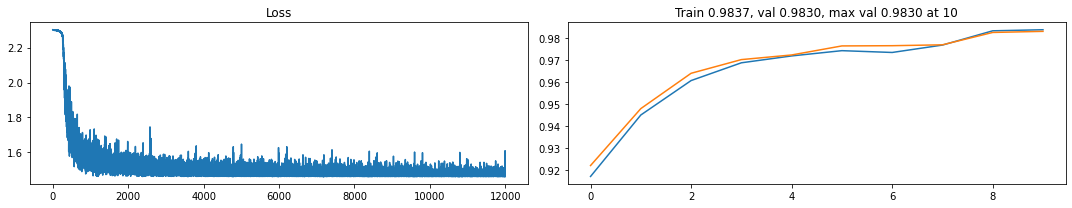

100%|██████████| 10/10 [23:15<00:00, 139.50s/it]


In [15]:
set_random_seeds(device=device)

#your file path where save gradients
#can be your local path ir google drive path
filepath = 'exp_ml/grads_batch_100'

#in case of google drive
#filepath='/content/gdrive/MyDrive/Gradient_exp/grads_batch_100'

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, num_workers=2)
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, num_workers=2)


#model = FullyConnected(input_dim=28*28, width=width, depth=depth, num_classes=10)
model=Lenetcnn
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)


mini_batch_100_model = train(model, optimizer, loss_function,
                             train_loader, val_loader,
                             device, filepath=filepath, epochs=epochs,
                             log_iter=100)

## 4 SG noise distribution's exploration

### 4.1 Calculating SGN and launching $\alpha$-estimator

We decided to start our investigation from the elementwise localization of parameters in a particuar network and the exploration of its distribution throughout all minibatches for a fixed epoch.   

In [16]:
def alpha_estimator(x):

    K = len(x)
    list1 = np.array([d for d in range (1, K // 2 + 1) if K % d == 0] + [K])
    difference = abs(np.sqrt(K) - list1)
    K_1 = list1[np.argmin(difference)]
    K_2 = int(K/K_1)
    y = np.zeros(K_2)
    for i in range(K_2):
        y[i] = sum((x[j + (i-1) * K_1] for j in range(K_1)))

    return 1 / ((1/np.log(K_1)) * ((1/K_2) * sum(np.log(abs(y))) - (1/len(x)) * sum(np.log(abs(x)))))

def alpha_dynamics(mean_alphas, params):
    plt.figure(figsize=(12, 8))
    plt.plot(params, mean_alphas, 'o-', label=r'$ \alpha $')
    plt.xlabel('Epochs', size=13)
    plt.ylabel(r'mean $ \alpha $', size=13)
    plt.title(r'$ \alpha $ dynamics', size=15)
    plt.legend(fontsize=15)
    plt.grid(True)
    plt.savefig(filepath + '_ep_50_alpha_dynamics.png')
    plt.show()


In [19]:
## This is quite slow block of code (takes about 10 minuets for 10 files with gradients from gDrive)
# amount of minibatches
N = 1200
alphas = []
sgn_storage = []

for itera in trange(1, int(total_iterations), 1):
    batch_grads = []
    with open(filepath + f'_logiter_{itera}.npy', 'rb') as file:
        for _ in range(N):
            batch_grads.append(np.load(file))
    
    sgn = (np.array(batch_grads) - np.array(batch_grads).sum(axis=0) / N).T
    del(batch_grads)
    # delete non-active neuron's sgn (zero-vectors sgn)
    sgn = sgn[~np.any(sgn == 0, axis=1), :]
    # store SGN for concrete epoch 
    sgn_storage.append(sgn)
    del(sgn)
    # calculating alpha for epoch
    alphas.append(np.apply_along_axis(alpha_estimator, axis=1, arr=sgn_storage[-1]))
    print(sgn_storage[-1].shape)
    

  1%|          | 1/119 [00:49<1:37:51, 49.76s/it]

(32503, 1200)


  2%|▏         | 2/119 [01:41<1:38:05, 50.30s/it]

(31993, 1200)


  3%|▎         | 3/119 [02:28<1:35:33, 49.43s/it]

(31275, 1200)


  3%|▎         | 4/119 [03:16<1:33:48, 48.95s/it]

(31161, 1200)


  4%|▍         | 5/119 [04:05<1:33:03, 48.98s/it]

(31756, 1200)


  5%|▌         | 6/119 [04:57<1:33:48, 49.81s/it]

(31784, 1200)


  6%|▌         | 7/119 [05:46<1:32:48, 49.72s/it]

(31790, 1200)


  7%|▋         | 8/119 [06:33<1:30:26, 48.89s/it]

(31803, 1200)


  8%|▊         | 9/119 [07:22<1:29:18, 48.72s/it]

(32063, 1200)


  8%|▊         | 10/119 [08:10<1:28:27, 48.69s/it]

(32362, 1200)


  9%|▉         | 11/119 [08:59<1:27:41, 48.72s/it]

(32412, 1200)


 10%|█         | 12/119 [09:50<1:27:54, 49.30s/it]

(32517, 1200)


 11%|█         | 13/119 [10:39<1:27:11, 49.36s/it]

(32593, 1200)


 12%|█▏        | 14/119 [11:28<1:26:03, 49.18s/it]

(32588, 1200)


 13%|█▎        | 15/119 [12:17<1:25:09, 49.13s/it]

(32870, 1200)


 13%|█▎        | 16/119 [13:05<1:23:58, 48.92s/it]

(32656, 1200)


 14%|█▍        | 17/119 [13:54<1:23:01, 48.84s/it]

(32662, 1200)


 15%|█▌        | 18/119 [14:44<1:22:49, 49.20s/it]

(33122, 1200)


 16%|█▌        | 19/119 [15:34<1:22:28, 49.48s/it]

(33771, 1200)


 17%|█▋        | 20/119 [16:24<1:21:56, 49.67s/it]

(33877, 1200)


 18%|█▊        | 21/119 [17:15<1:21:45, 50.06s/it]

(33972, 1200)


 18%|█▊        | 22/119 [18:05<1:20:54, 50.05s/it]

(34005, 1200)


 19%|█▉        | 23/119 [18:56<1:20:17, 50.18s/it]

(34001, 1200)


 20%|██        | 24/119 [32:27<7:20:50, 278.43s/it]

(33934, 1200)


 21%|██        | 25/119 [33:27<5:33:44, 213.03s/it]

(34056, 1200)


 22%|██▏       | 26/119 [34:19<4:15:12, 164.65s/it]

(34063, 1200)


 23%|██▎       | 27/119 [35:10<3:20:02, 130.47s/it]

(34107, 1200)


 24%|██▎       | 28/119 [36:01<2:41:40, 106.60s/it]

(34122, 1200)


 24%|██▍       | 29/119 [36:52<2:15:14, 90.16s/it] 

(34113, 1200)


 25%|██▌       | 30/119 [37:43<1:56:15, 78.37s/it]

(34175, 1200)


 26%|██▌       | 31/119 [38:34<1:42:47, 70.09s/it]

(34225, 1200)


 27%|██▋       | 32/119 [39:25<1:33:17, 64.34s/it]

(34294, 1200)


 28%|██▊       | 33/119 [40:17<1:26:50, 60.58s/it]

(34554, 1200)


 29%|██▊       | 34/119 [41:09<1:22:22, 58.15s/it]

(34341, 1200)


 29%|██▉       | 35/119 [42:01<1:18:41, 56.21s/it]

(34363, 1200)


 30%|███       | 36/119 [42:53<1:15:55, 54.89s/it]

(34666, 1200)


 31%|███       | 37/119 [1:21:01<16:30:50, 725.01s/it]

(34981, 1200)


 32%|███▏      | 38/119 [1:52:54<24:19:36, 1081.19s/it]

(34962, 1200)


 33%|███▎      | 39/119 [2:34:42<33:32:25, 1509.32s/it]

(35023, 1200)


 34%|███▎      | 40/119 [2:35:40<23:34:02, 1073.96s/it]

(34969, 1200)


 34%|███▍      | 41/119 [2:36:32<16:37:30, 767.31s/it] 

(34706, 1200)


 35%|███▌      | 42/119 [2:37:25<11:49:39, 552.97s/it]

(34765, 1200)


 36%|███▌      | 43/119 [2:38:17<8:30:19, 402.89s/it] 

(35011, 1200)


 37%|███▋      | 44/119 [2:39:12<6:12:58, 298.38s/it]

(35003, 1200)


 38%|███▊      | 45/119 [2:40:06<4:37:33, 225.05s/it]

(34780, 1200)


 39%|███▊      | 46/119 [2:41:03<3:32:26, 174.61s/it]

(34794, 1200)


 39%|███▉      | 47/119 [2:42:01<2:47:40, 139.73s/it]

(34811, 1200)


 40%|████      | 48/119 [2:42:56<2:15:21, 114.39s/it]

(34825, 1200)


 41%|████      | 49/119 [2:43:53<1:53:24, 97.20s/it] 

(35058, 1200)


 42%|████▏     | 50/119 [2:44:52<1:38:30, 85.66s/it]

(35020, 1200)


 43%|████▎     | 51/119 [2:45:49<1:27:07, 76.87s/it]

(35071, 1200)


 44%|████▎     | 52/119 [2:46:46<1:19:26, 71.15s/it]

(35070, 1200)


 45%|████▍     | 53/119 [2:47:43<1:13:28, 66.80s/it]

(34861, 1200)


 45%|████▌     | 54/119 [2:48:40<1:09:18, 63.98s/it]

(35093, 1200)


 46%|████▌     | 55/119 [2:49:37<1:06:00, 61.89s/it]

(35103, 1200)


 47%|████▋     | 56/119 [2:50:34<1:03:18, 60.29s/it]

(35130, 1200)


 48%|████▊     | 57/119 [2:51:31<1:01:18, 59.32s/it]

(35109, 1200)


 49%|████▊     | 58/119 [2:52:29<59:57, 58.98s/it]  

(35108, 1200)


 50%|████▉     | 59/119 [2:53:27<58:37, 58.62s/it]

(35111, 1200)


 50%|█████     | 60/119 [2:54:23<56:59, 57.95s/it]

(35050, 1200)


 51%|█████▏    | 61/119 [2:55:21<56:01, 57.95s/it]

(35120, 1200)


 52%|█████▏    | 62/119 [2:56:18<54:40, 57.55s/it]

(35035, 1200)


 53%|█████▎    | 63/119 [2:57:14<53:19, 57.13s/it]

(35131, 1200)


 54%|█████▍    | 64/119 [2:58:12<52:28, 57.25s/it]

(35144, 1200)


 55%|█████▍    | 65/119 [2:59:09<51:33, 57.29s/it]

(35104, 1200)


 55%|█████▌    | 66/119 [3:00:06<50:28, 57.15s/it]

(35210, 1200)


 56%|█████▋    | 67/119 [3:01:04<49:42, 57.36s/it]

(35152, 1200)


 57%|█████▋    | 68/119 [3:02:01<48:45, 57.37s/it]

(35175, 1200)


 58%|█████▊    | 69/119 [3:02:59<47:49, 57.40s/it]

(35226, 1200)


 59%|█████▉    | 70/119 [3:03:55<46:37, 57.10s/it]

(35194, 1200)


 60%|█████▉    | 71/119 [3:04:55<46:24, 58.01s/it]

(35215, 1200)


 61%|██████    | 72/119 [3:05:52<45:15, 57.78s/it]

(35222, 1200)


 61%|██████▏   | 73/119 [3:06:50<44:16, 57.74s/it]

(35251, 1200)


 62%|██████▏   | 74/119 [3:07:46<42:59, 57.32s/it]

(35242, 1200)


 63%|██████▎   | 75/119 [3:08:45<42:18, 57.69s/it]

(35244, 1200)


 64%|██████▍   | 76/119 [3:09:45<41:52, 58.44s/it]

(35215, 1200)


 65%|██████▍   | 77/119 [3:10:43<40:44, 58.20s/it]

(35226, 1200)


 66%|██████▌   | 78/119 [3:11:39<39:28, 57.77s/it]

(35262, 1200)


 66%|██████▋   | 79/119 [3:12:37<38:24, 57.61s/it]

(35307, 1200)


 67%|██████▋   | 80/119 [3:13:34<37:21, 57.48s/it]

(35265, 1200)


 68%|██████▊   | 81/119 [3:14:32<36:28, 57.58s/it]

(35320, 1200)


 69%|██████▉   | 82/119 [3:15:31<35:49, 58.10s/it]

(35287, 1200)


 70%|██████▉   | 83/119 [3:16:29<34:49, 58.05s/it]

(35272, 1200)


 71%|███████   | 84/119 [3:17:27<33:47, 57.93s/it]

(35265, 1200)


 71%|███████▏  | 85/119 [3:18:25<32:50, 57.96s/it]

(35281, 1200)


 72%|███████▏  | 86/119 [3:19:22<31:48, 57.84s/it]

(35343, 1200)


 73%|███████▎  | 87/119 [3:20:19<30:43, 57.62s/it]

(35336, 1200)


 74%|███████▍  | 88/119 [3:21:18<29:55, 57.93s/it]

(35342, 1200)


 75%|███████▍  | 89/119 [3:22:18<29:18, 58.63s/it]

(35373, 1200)


 76%|███████▌  | 90/119 [3:23:16<28:10, 58.30s/it]

(35366, 1200)


 76%|███████▋  | 91/119 [3:24:14<27:10, 58.24s/it]

(35397, 1200)


 77%|███████▋  | 92/119 [3:25:12<26:10, 58.18s/it]

(35391, 1200)


 78%|███████▊  | 93/119 [3:26:10<25:09, 58.07s/it]

(35373, 1200)


 79%|███████▉  | 94/119 [3:27:07<24:05, 57.83s/it]

(35397, 1200)


 80%|███████▉  | 95/119 [3:28:05<23:12, 58.02s/it]

(35360, 1200)


 81%|████████  | 96/119 [3:29:03<22:14, 58.04s/it]

(35353, 1200)


 82%|████████▏ | 97/119 [3:30:03<21:28, 58.55s/it]

(35268, 1200)


 82%|████████▏ | 98/119 [3:31:00<20:20, 58.14s/it]

(35331, 1200)


 83%|████████▎ | 99/119 [3:31:58<19:20, 58.03s/it]

(35374, 1200)


 84%|████████▍ | 100/119 [3:32:56<18:18, 57.84s/it]

(35351, 1200)


 85%|████████▍ | 101/119 [3:33:53<17:18, 57.72s/it]

(35408, 1200)


 86%|████████▌ | 102/119 [3:34:51<16:20, 57.67s/it]

(35423, 1200)


 87%|████████▋ | 103/119 [3:35:48<15:22, 57.63s/it]

(35430, 1200)


 87%|████████▋ | 104/119 [3:36:49<14:37, 58.48s/it]

(35375, 1200)


 88%|████████▊ | 105/119 [3:37:46<13:32, 58.03s/it]

(35375, 1200)


 89%|████████▉ | 106/119 [3:38:44<12:34, 58.05s/it]

(35364, 1200)


 90%|████████▉ | 107/119 [3:39:41<11:34, 57.91s/it]

(35357, 1200)


 91%|█████████ | 108/119 [3:40:38<10:31, 57.45s/it]

(35334, 1200)


 92%|█████████▏| 109/119 [3:41:35<09:33, 57.36s/it]

(35290, 1200)


 92%|█████████▏| 110/119 [3:42:32<08:36, 57.42s/it]

(35314, 1200)


 93%|█████████▎| 111/119 [3:43:31<07:43, 57.93s/it]

(35399, 1200)


 94%|█████████▍| 112/119 [3:44:28<06:43, 57.61s/it]

(35399, 1200)


 95%|█████████▍| 113/119 [3:45:25<05:43, 57.33s/it]

(35361, 1200)


 96%|█████████▌| 114/119 [3:46:21<04:45, 57.08s/it]

(35387, 1200)


 97%|█████████▋| 115/119 [3:47:19<03:48, 57.19s/it]

(35391, 1200)


 97%|█████████▋| 116/119 [3:48:17<02:52, 57.47s/it]

(35314, 1200)


 98%|█████████▊| 117/119 [3:49:13<01:54, 57.13s/it]

(35348, 1200)


 99%|█████████▉| 118/119 [3:50:09<00:56, 56.82s/it]

(35327, 1200)


100%|██████████| 119/119 [3:51:09<00:00, 116.55s/it]

(35278, 1200)


In [ ]:
mean_alphas = []
for alpha_vec in alphas:
    mean_alphas.append(alpha_vec.mean())

alpha_dynamics(mean_alphas, [epoch for epoch in range(5, epochs+1, 5)])

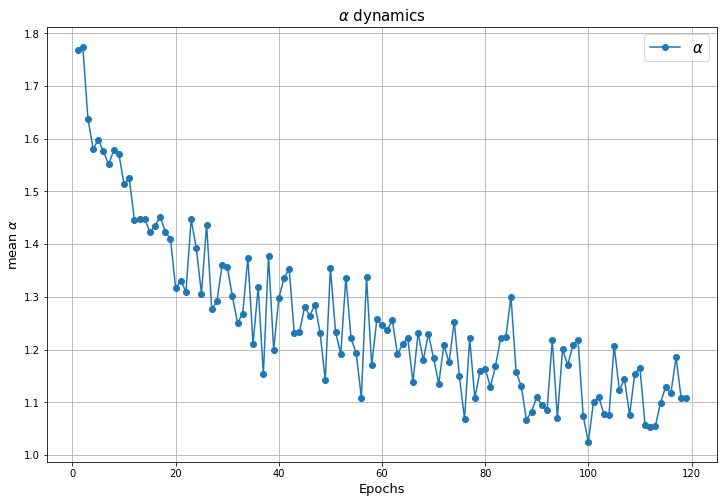

In [21]:
mean_alphas = []
for alpha_vec in alphas:
    mean_alphas.append(alpha_vec.mean())

alpha_dynamics(mean_alphas, [itera for itera in range(1, int(total_iterations), 1)])

# Mean alpha for a layer

In [ ]:
alpha_layers={'Conv1':[],'Conv2':[],'Linear1':[],'Linear2':[]}

In [130]:
filepath = 'exp_ml/grads_batch_100'
batch_grads = []
with open(filepath + f'_logiter_{itera}.npy', 'rb') as file:
    for _ in range(N):
        batch_grads.append(np.load(file))

In [133]:
sgn = (np.array(batch_grads) - np.array(batch_grads).sum(axis=0) / N).T
sgn.shape

(35570, 1200)

In [93]:
150+864+33600+840

35454

In [95]:
batch_grads[7].shape

(35570,)

In [87]:
[150,864,33600,840,]
alphas[0].shape

(32503,)

In [83]:
sgn_storage[0].shape

(32503, 1200)

In [115]:
list_num_neurons=[]
for p in model.parameters():
    print(*p.shape)
    res=1
    for elem in list(p.shape):
        res=elem*res
    list_num_neurons.append(res)
    
print(list_num_neurons)       

cum_neuro=0
ind_layers=[]
for dum in list_num_neurons:
    cum_neuro+=dum
    ind_layers.append(cum_neuro)
print(ind_layers)

6 1 5 5
6
16 6 3 3
16
84 400
84
10 84
10
[150, 6, 864, 16, 33600, 84, 840, 10]
[150, 156, 1020, 1036, 34636, 34720, 35560, 35570]


In [121]:
total_iterations

120.0

In [123]:
filepath='exp_ml/grads_batch_100'
layers=[0,150, 156, 1020, 1036, 34636, 34720, 35560, 35570]
alpha_layers={'Conv1':[],'Relu1':[],'Conv2':[],'Relu2':[],'Linear1':[],'Relu3':[],'Linear2':[],'Softmax':[]}
layer_names=['Conv1','Relu1','Conv2','Relu2','Linear1','Relu3','Linear2','Softmax']
for itera in trange(1, int(total_iterations), 5):
    batch_grads = []
    with open(filepath + f'_logiter_{itera}.npy', 'rb') as file:
        for _ in range(N):
            batch_grads.append(np.load(file))
    
    sgn = (np.array(batch_grads) - np.array(batch_grads).sum(axis=0) / N).T
    del(batch_grads)
    for number in range(0,len(layers)-1):
        gradients_layer=sgn[layers[number]:layers[number+1],:]
        gradients_layer=gradients_layer[~np.any(gradients_layer == 0, axis=1), :]
        
        alpha_layers[layer_names[number]].append(np.apply_along_axis(alpha_estimator, axis=1, arr=gradients_layer))
        



100%|██████████| 24/24 [20:56<00:00, 52.37s/it]


Text(0.5, 0, 'Iterations')

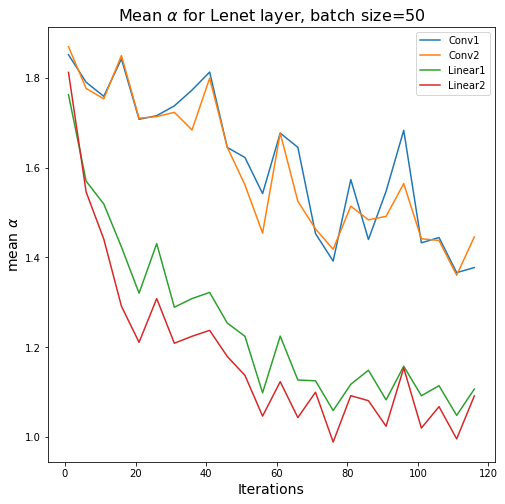

In [163]:
fig=plt.figure(figsize=[8,8])
plot_list=['Conv1','Conv2','Linear1','Linear2']
for name in layer_names:
    mean_layer_list=[]
    for i in range(len(alpha_layers[name])):
        mean_layer_list.append(np.mean(alpha_layers[name][i]))
    if name in plot_list:
        plt.plot(np.arange(1, int(total_iterations), 5),mean_layer_list,label=name)
    
plt.legend()
plt.title(r'Mean $ \alpha $ for Lenet layer, batch size=50',size=16)
plt.ylabel(r'mean $ \alpha $', size=14)
plt.xlabel('Iterations', size=14)

# Batch size 150

100%|██████████| 39/39 [11:48<00:00, 18.16s/it]


ValueError: x and y must have same first dimension, but have shapes (8,) and (39,)

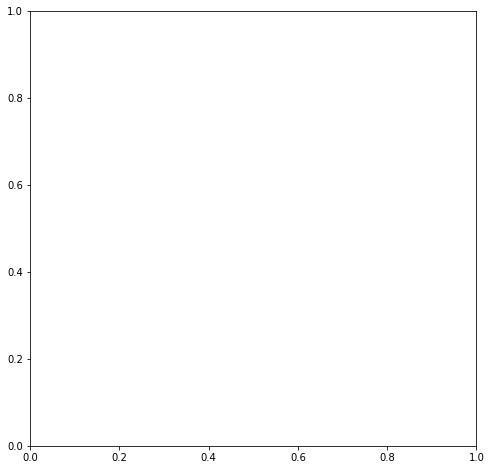

In [165]:
filepath='exp_ml/grads_batch_150'
total_iterations=epochs*(60000/150)/log_iter

N = int(60000/150)

layers=[0,150, 156, 1020, 1036, 34636, 34720, 35560, 35570]
alpha_layers={'Conv1':[],'Relu1':[],'Conv2':[],'Relu2':[],'Linear1':[],'Relu3':[],'Linear2':[],'Softmax':[]}
layer_names=['Conv1','Relu1','Conv2','Relu2','Linear1','Relu3','Linear2','Softmax']
for itera in trange(1, int(total_iterations), 1):
    batch_grads = []
    with open(filepath + f'_logiter_{itera}.npy', 'rb') as file:
        for _ in range(N):
            batch_grads.append(np.load(file))
    
    sgn = (np.array(batch_grads) - np.array(batch_grads).sum(axis=0) / N).T
    del(batch_grads)
    for number in range(0,len(layers)-1):
        gradients_layer=sgn[layers[number]:layers[number+1],:]
        gradients_layer=gradients_layer[~np.any(gradients_layer == 0, axis=1), :]
        
        alpha_layers[layer_names[number]].append(np.apply_along_axis(alpha_estimator, axis=1, arr=gradients_layer))



Text(0.5, 0, 'Iterations')

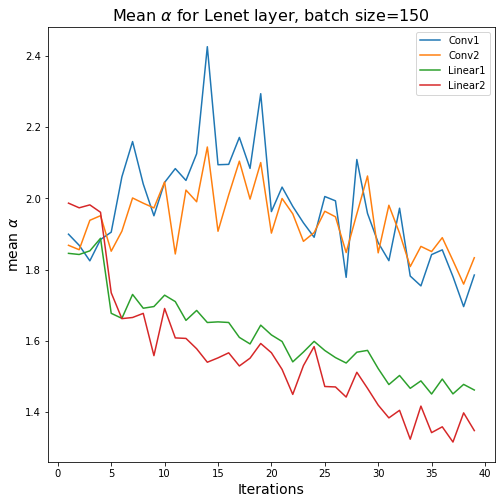

In [166]:
fig=plt.figure(figsize=[8,8])
plot_list=['Conv1','Conv2','Linear1','Linear2']
for name in layer_names:
    mean_layer_list=[]
    for i in range(len(alpha_layers[name])):
        mean_layer_list.append(np.mean(alpha_layers[name][i]))
    if name in plot_list:
        plt.plot(np.arange(1, int(total_iterations), 1),mean_layer_list,label=name)
    
plt.legend()
plt.title(r'Mean $ \alpha $ for Lenet layer, batch size=150',size=16)
plt.ylabel(r'mean $ \alpha $', size=14)
plt.xlabel('Iterations', size=14)

# Batch size 200, layer plot 

100%|██████████| 29/29 [07:11<00:00, 14.88s/it]


Text(0.5, 0, 'Iterations')

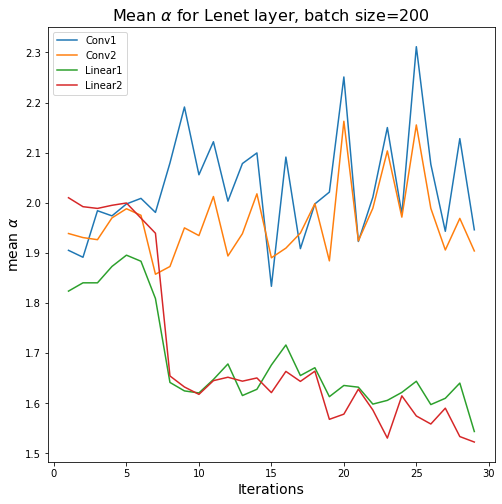

In [167]:
filepath='exp_ml/grads_batch_200'
total_iterations=epochs*(60000/200)/log_iter

N = int(60000/200)

layers=[0,150, 156, 1020, 1036, 34636, 34720, 35560, 35570]
alpha_layers={'Conv1':[],'Relu1':[],'Conv2':[],'Relu2':[],'Linear1':[],'Relu3':[],'Linear2':[],'Softmax':[]}
layer_names=['Conv1','Relu1','Conv2','Relu2','Linear1','Relu3','Linear2','Softmax']
for itera in trange(1, int(total_iterations), 1):
    batch_grads = []
    with open(filepath + f'_logiter_{itera}.npy', 'rb') as file:
        for _ in range(N):
            batch_grads.append(np.load(file))
    
    sgn = (np.array(batch_grads) - np.array(batch_grads).sum(axis=0) / N).T
    del(batch_grads)
    for number in range(0,len(layers)-1):
        gradients_layer=sgn[layers[number]:layers[number+1],:]
        gradients_layer=gradients_layer[~np.any(gradients_layer == 0, axis=1), :]
        
        alpha_layers[layer_names[number]].append(np.apply_along_axis(alpha_estimator, axis=1, arr=gradients_layer))

fig=plt.figure(figsize=[8,8])
plot_list=['Conv1','Conv2','Linear1','Linear2']
for name in layer_names:
    mean_layer_list=[]
    for i in range(len(alpha_layers[name])):
        mean_layer_list.append(np.mean(alpha_layers[name][i]))
    if name in plot_list:
        plt.plot(np.arange(1, int(total_iterations), 1),mean_layer_list,label=name)
    
plt.legend()
plt.title(r'Mean $ \alpha $ for Lenet layer, batch size=200',size=16)
plt.ylabel(r'mean $ \alpha $', size=14)
plt.xlabel('Iterations', size=14)

# Batch size 300, layer plot 

100%|██████████| 19/19 [03:12<00:00, 10.11s/it]


Text(0.5, 0, 'Iterations')

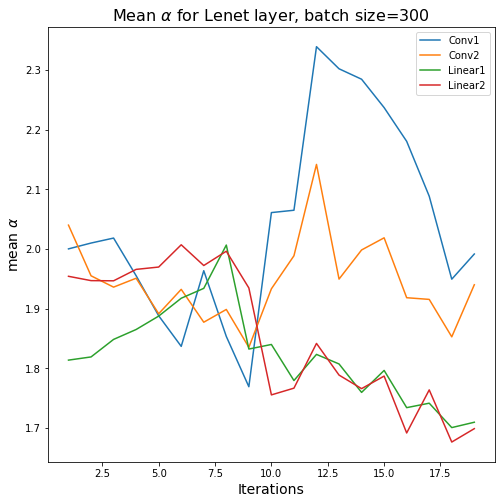

In [168]:
filepath='exp_ml/grads_batch_300'
total_iterations=epochs*(60000/300)/log_iter

N = int(60000/300)

layers=[0,150, 156, 1020, 1036, 34636, 34720, 35560, 35570]
alpha_layers={'Conv1':[],'Relu1':[],'Conv2':[],'Relu2':[],'Linear1':[],'Relu3':[],'Linear2':[],'Softmax':[]}
layer_names=['Conv1','Relu1','Conv2','Relu2','Linear1','Relu3','Linear2','Softmax']
for itera in trange(1, int(total_iterations), 1):
    batch_grads = []
    with open(filepath + f'_logiter_{itera}.npy', 'rb') as file:
        for _ in range(N):
            batch_grads.append(np.load(file))
    
    sgn = (np.array(batch_grads) - np.array(batch_grads).sum(axis=0) / N).T
    del(batch_grads)
    for number in range(0,len(layers)-1):
        gradients_layer=sgn[layers[number]:layers[number+1],:]
        gradients_layer=gradients_layer[~np.any(gradients_layer == 0, axis=1), :]
        
        alpha_layers[layer_names[number]].append(np.apply_along_axis(alpha_estimator, axis=1, arr=gradients_layer))

fig=plt.figure(figsize=[8,8])
plot_list=['Conv1','Conv2','Linear1','Linear2']
for name in layer_names:
    mean_layer_list=[]
    for i in range(len(alpha_layers[name])):
        mean_layer_list.append(np.mean(alpha_layers[name][i]))
    if name in plot_list:
        plt.plot(np.arange(1, int(total_iterations), 1),mean_layer_list,label=name)
    
plt.legend()
plt.title(r'Mean $ \alpha $ for Lenet layer, batch size=300',size=16)
plt.ylabel(r'mean $ \alpha $', size=14)
plt.xlabel('Iterations', size=14)

### 4.2 Visualizing SGN distribution

In [22]:
def SGD_noise_distplots(SGD_noise, distribution, dist_name, bins):

  params = distribution.fit(SGD_noise)
  Theoretical_dist = distribution(*params)
  x = np.linspace(SGD_noise.min(), SGD_noise.max(), len(SGD_noise))

  SGD_noise_hist = np.histogram(SGD_noise ,bins = bins)

  fig, axs = plt.subplots(4, 1, figsize=(16, 40))
  # axs[0].hist(SGD_noise, density=True, bins=bins, color='white', ec='black', label='SGD Noise')
  axs[0].hist(SGD_noise, density=True, bins=bins, label='SGD Noise')
  axs[0].hist(Theoretical_dist.rvs(size=len(SGD_noise)), density=True, bins=bins, label=dist_name)
  # axs[0].plot(x, Theoretical_dist.pdf(x), '--', color='black', label='Gaussian')
  axs[0].set_xlabel('SGD noise', size=13)
  axs[0].set_ylabel('Density', size=13)
  axs[0].set_title('SGD noise hist', size=15)
  axs[0].legend(fontsize=15)

  axs[1].plot(SGD_noise_hist[1][:-1],SGD_noise_hist[0],'o',  color='black', label='SGD Noise')
  axs[1].plot(x, Theoretical_dist.pdf(x), '--', color='black', label=dist_name)
  axs[1].set_xlabel('SGD noise', size=13)
  axs[1].set_ylabel('Density', size=13)
  axs[1].set_title('SGD noise dotted hist', size=15)
  axs[1].legend(fontsize=15)

  axs[2].set_yscale('log')
  axs[2].plot(SGD_noise_hist[1][:-1],SGD_noise_hist[0],'o',  color='black', label='SGD Noise')
  axs[2].plot(x, Theoretical_dist.pdf(x), '--', color='black', label=dist_name)
  axs[2].set_xlabel('SGD noise', size=13)
  axs[2].set_ylabel('log-scaled Density', size=13)
  axs[2].set_title('SGD noise dotted log hist', size=15)
  axs[2].legend(fontsize=15)

  stats.probplot(SGD_noise, dist=Theoretical_dist, plot=plt)
  plt.title('SGD noise QQ-plot', size=15)
  plt.xlabel('Theoretical Quantiles', size=13)
  plt.ylabel('Sample Quantiles', size=13)

  plt.grid()
  

  plt.show()  

# Stochastic gradient distribution graphs


## Iteration 0

In [23]:
# amount of epochs
len(sgn_storage)

119

In [24]:
# 1200 gradients per batch for 89911 neurons in 5th epoch
sgn_storage[0].shape

(32503, 1200)

## Conv1

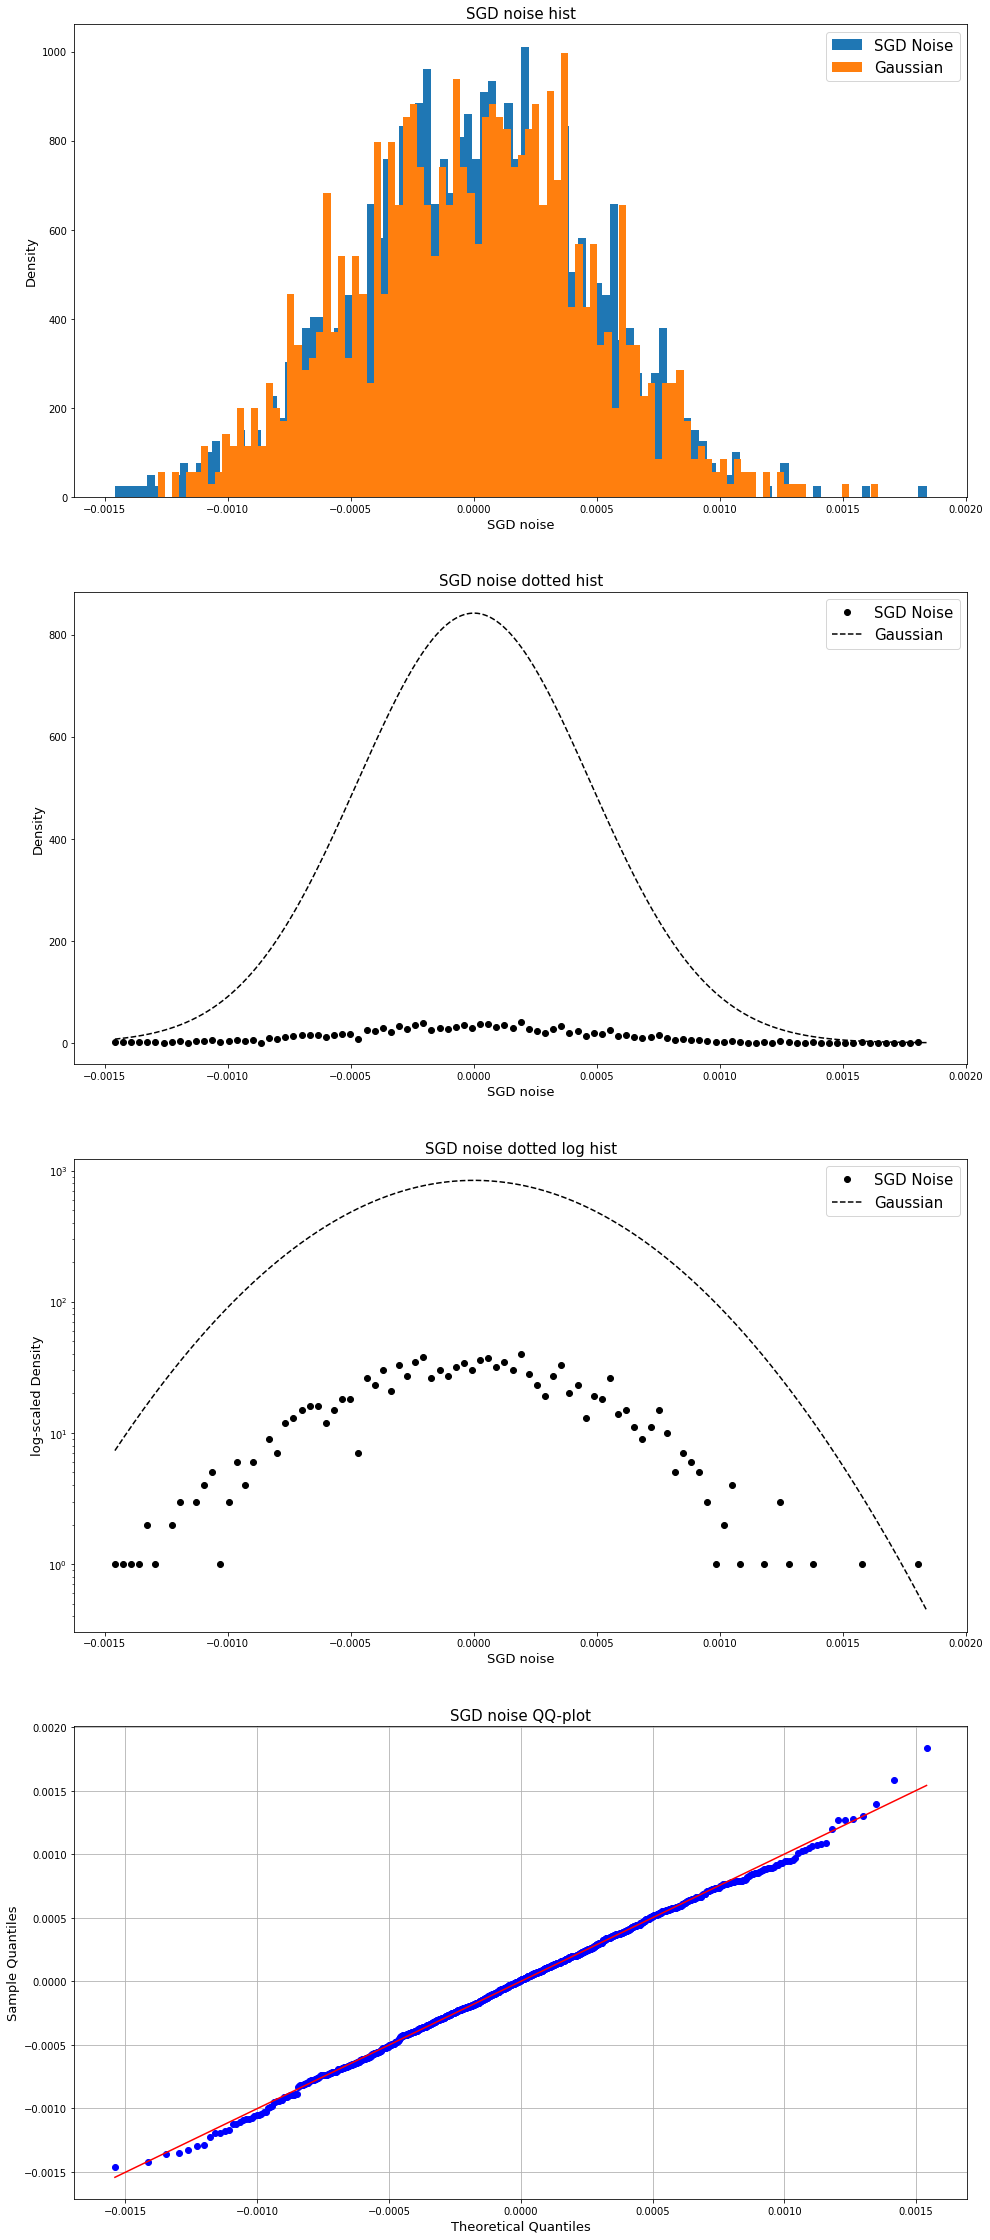

In [40]:
SGD_noise_distplots(SGD_noise=sgn_storage[0][111], distribution=norm, dist_name='Gaussian', bins=100)

## Conv2

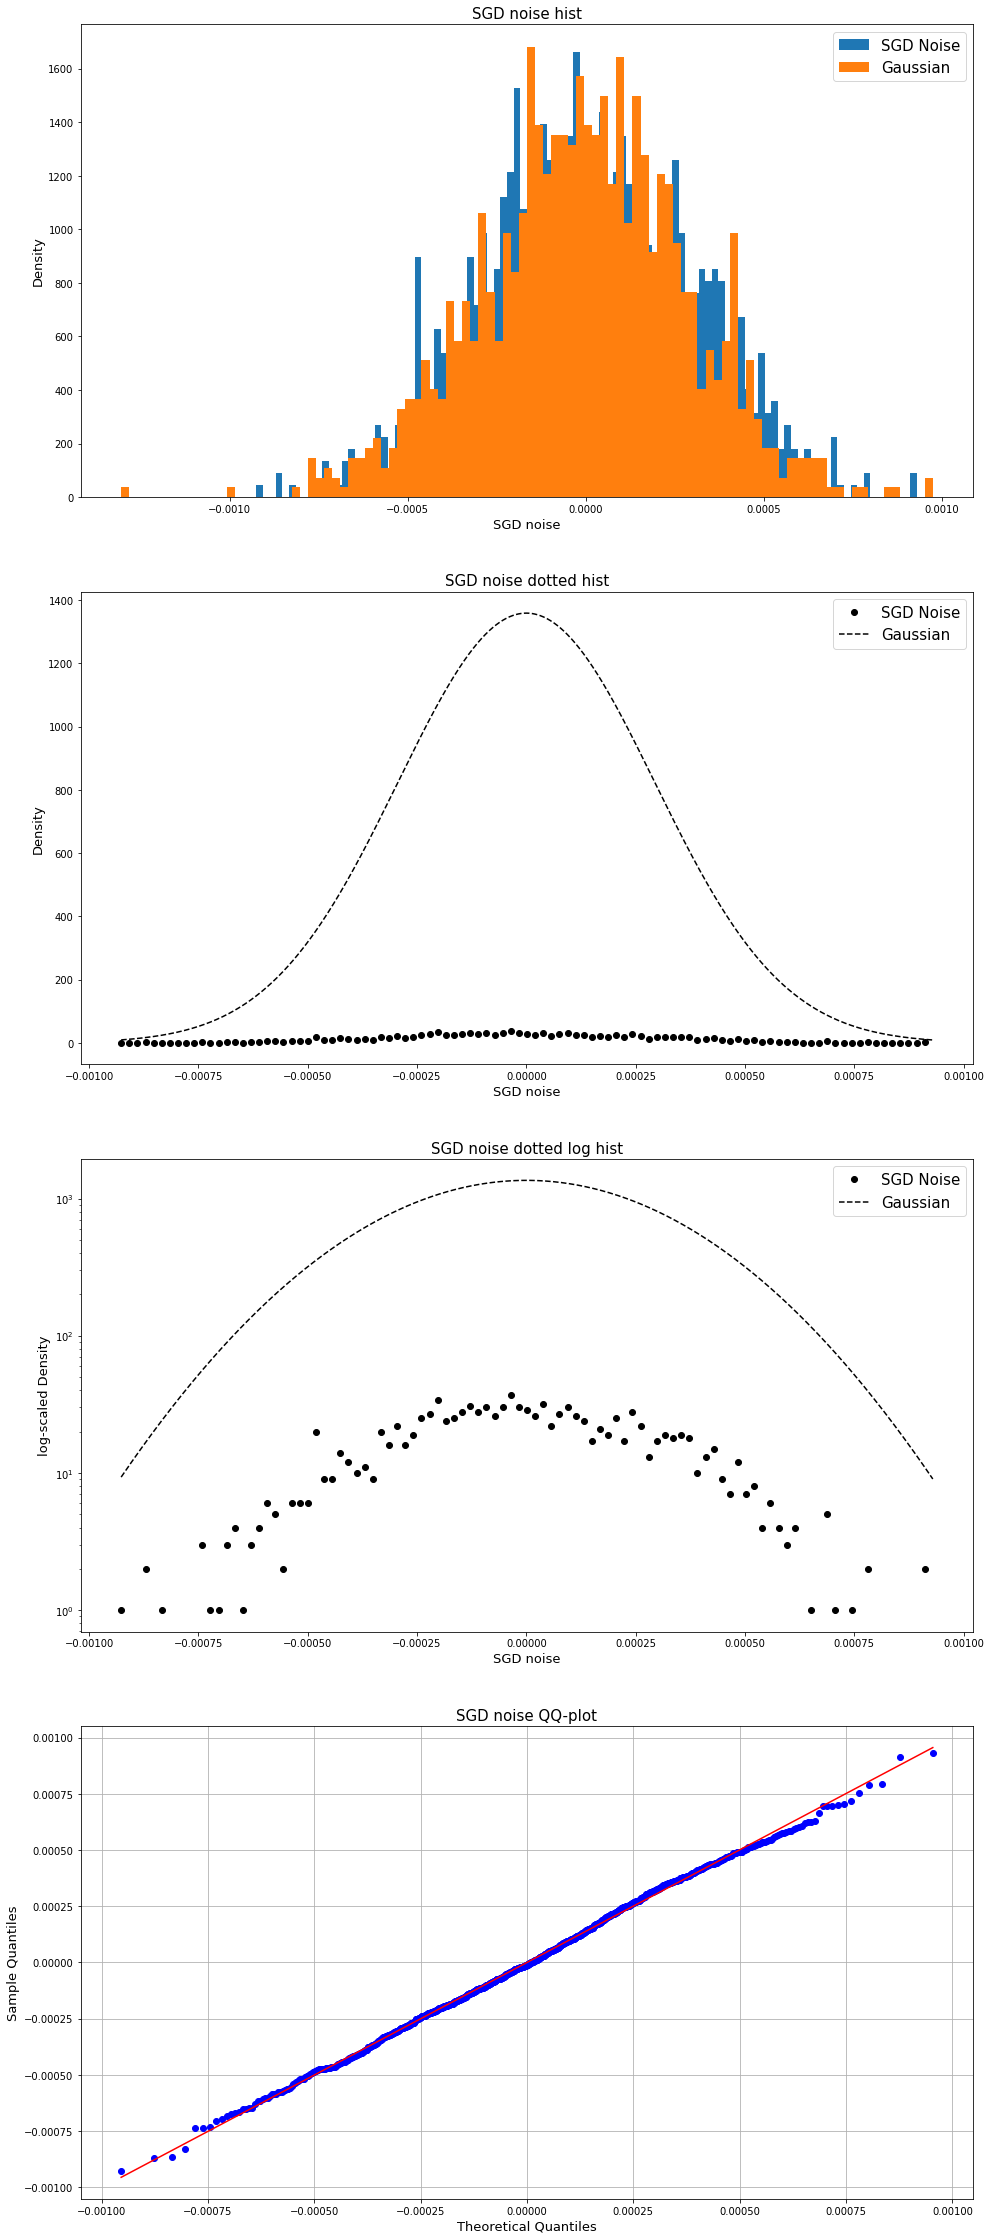

In [41]:
SGD_noise_distplots(SGD_noise=sgn_storage[0][300], distribution=norm, dist_name='Gaussian', bins=100)

## Linear 1

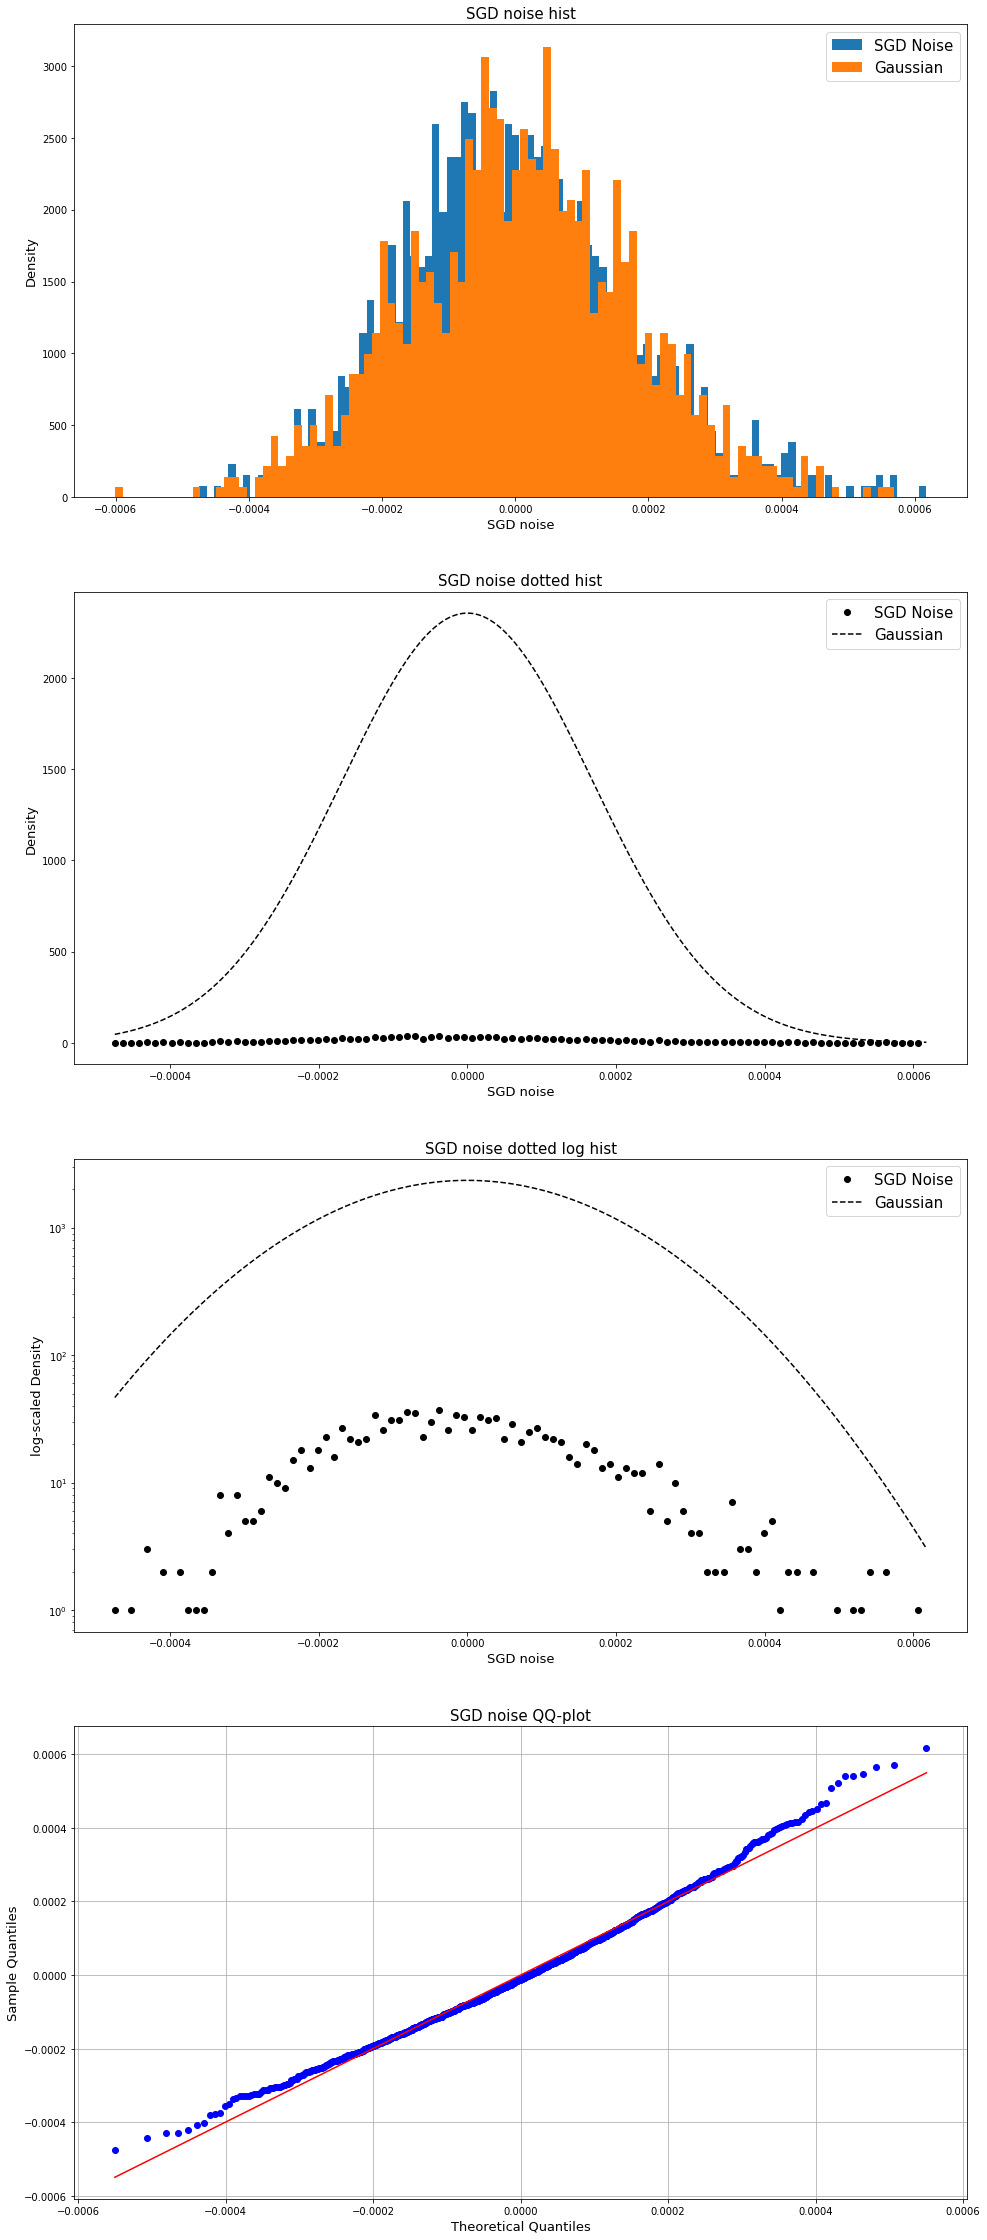

In [43]:
SGD_noise_distplots(SGD_noise=sgn_storage[0][20000], distribution=norm, dist_name='Gaussian', bins=100)

## Linear 2

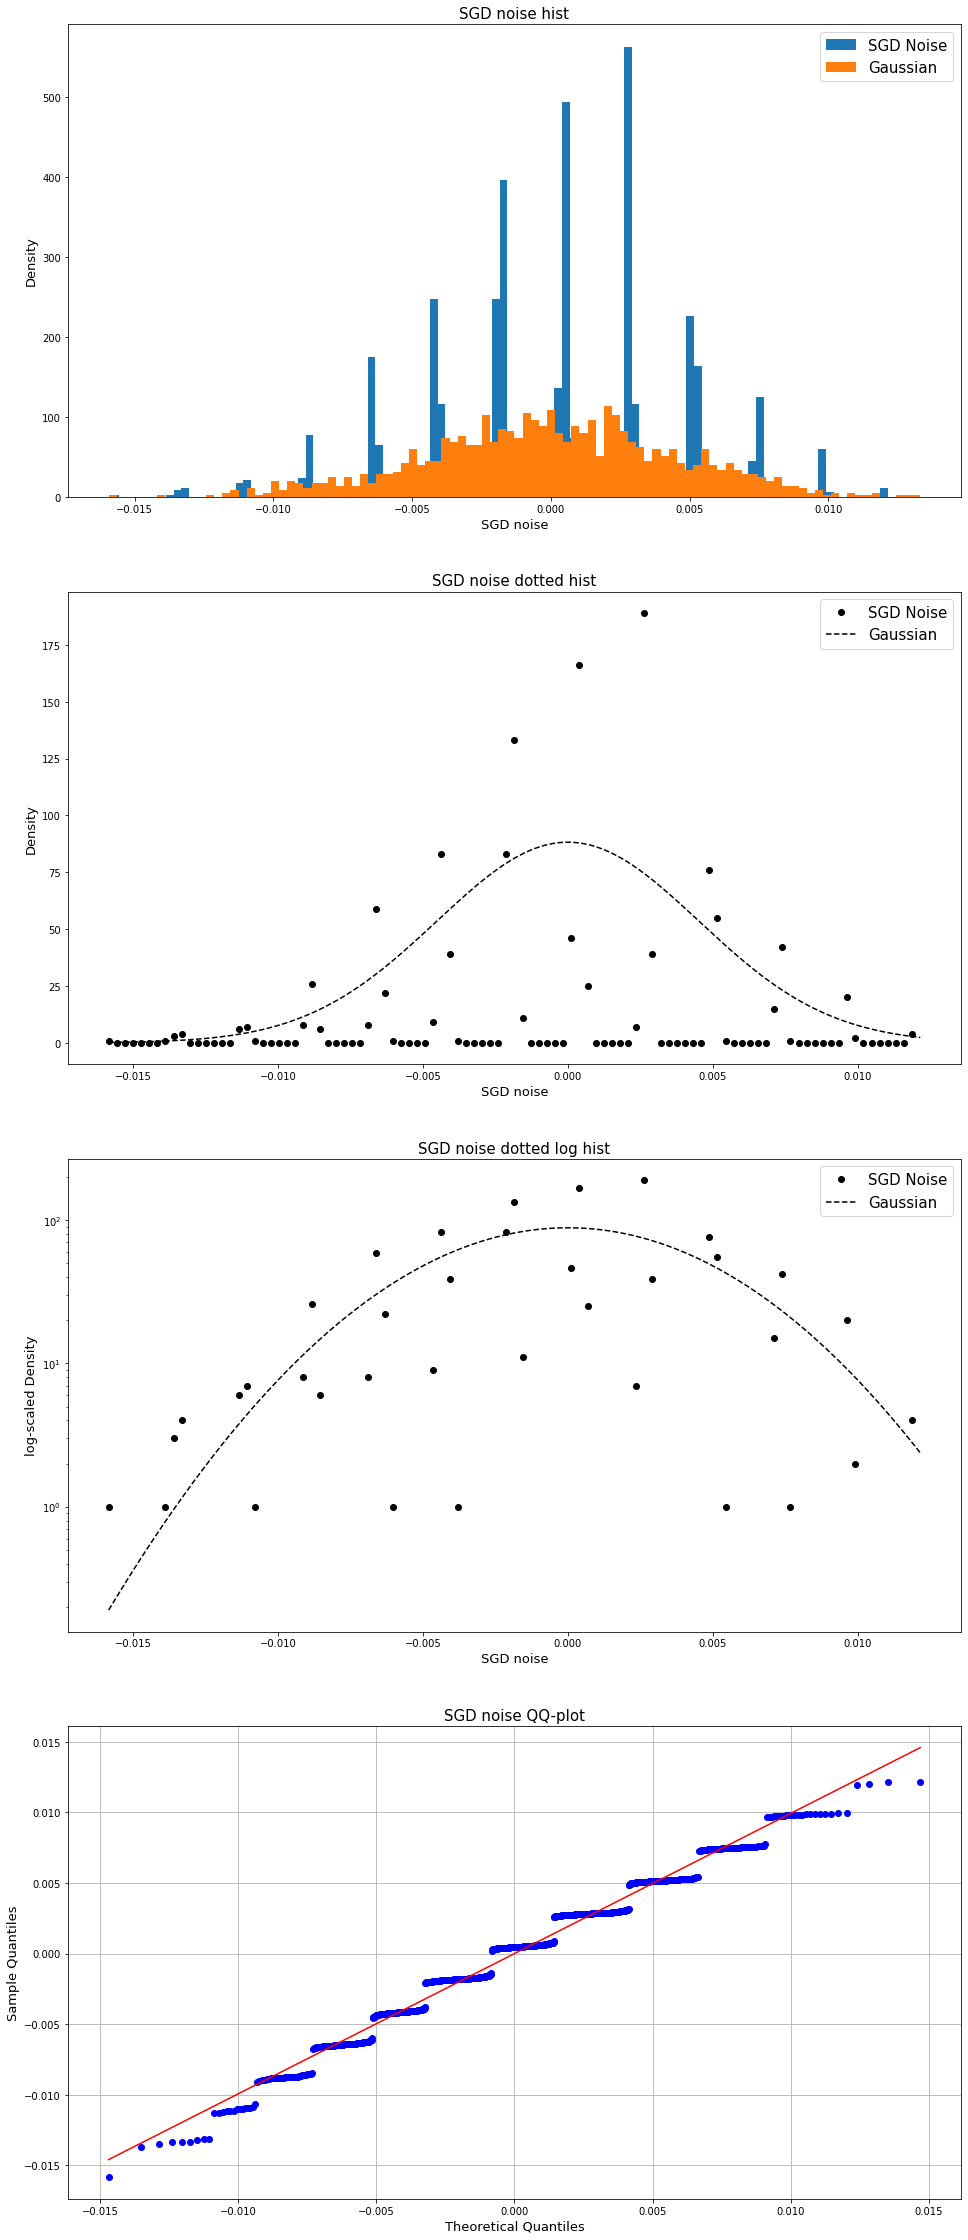

In [46]:
SGD_noise_distplots(SGD_noise=sgn_storage[0][32500], distribution=norm, dist_name='Gaussian', bins=100)

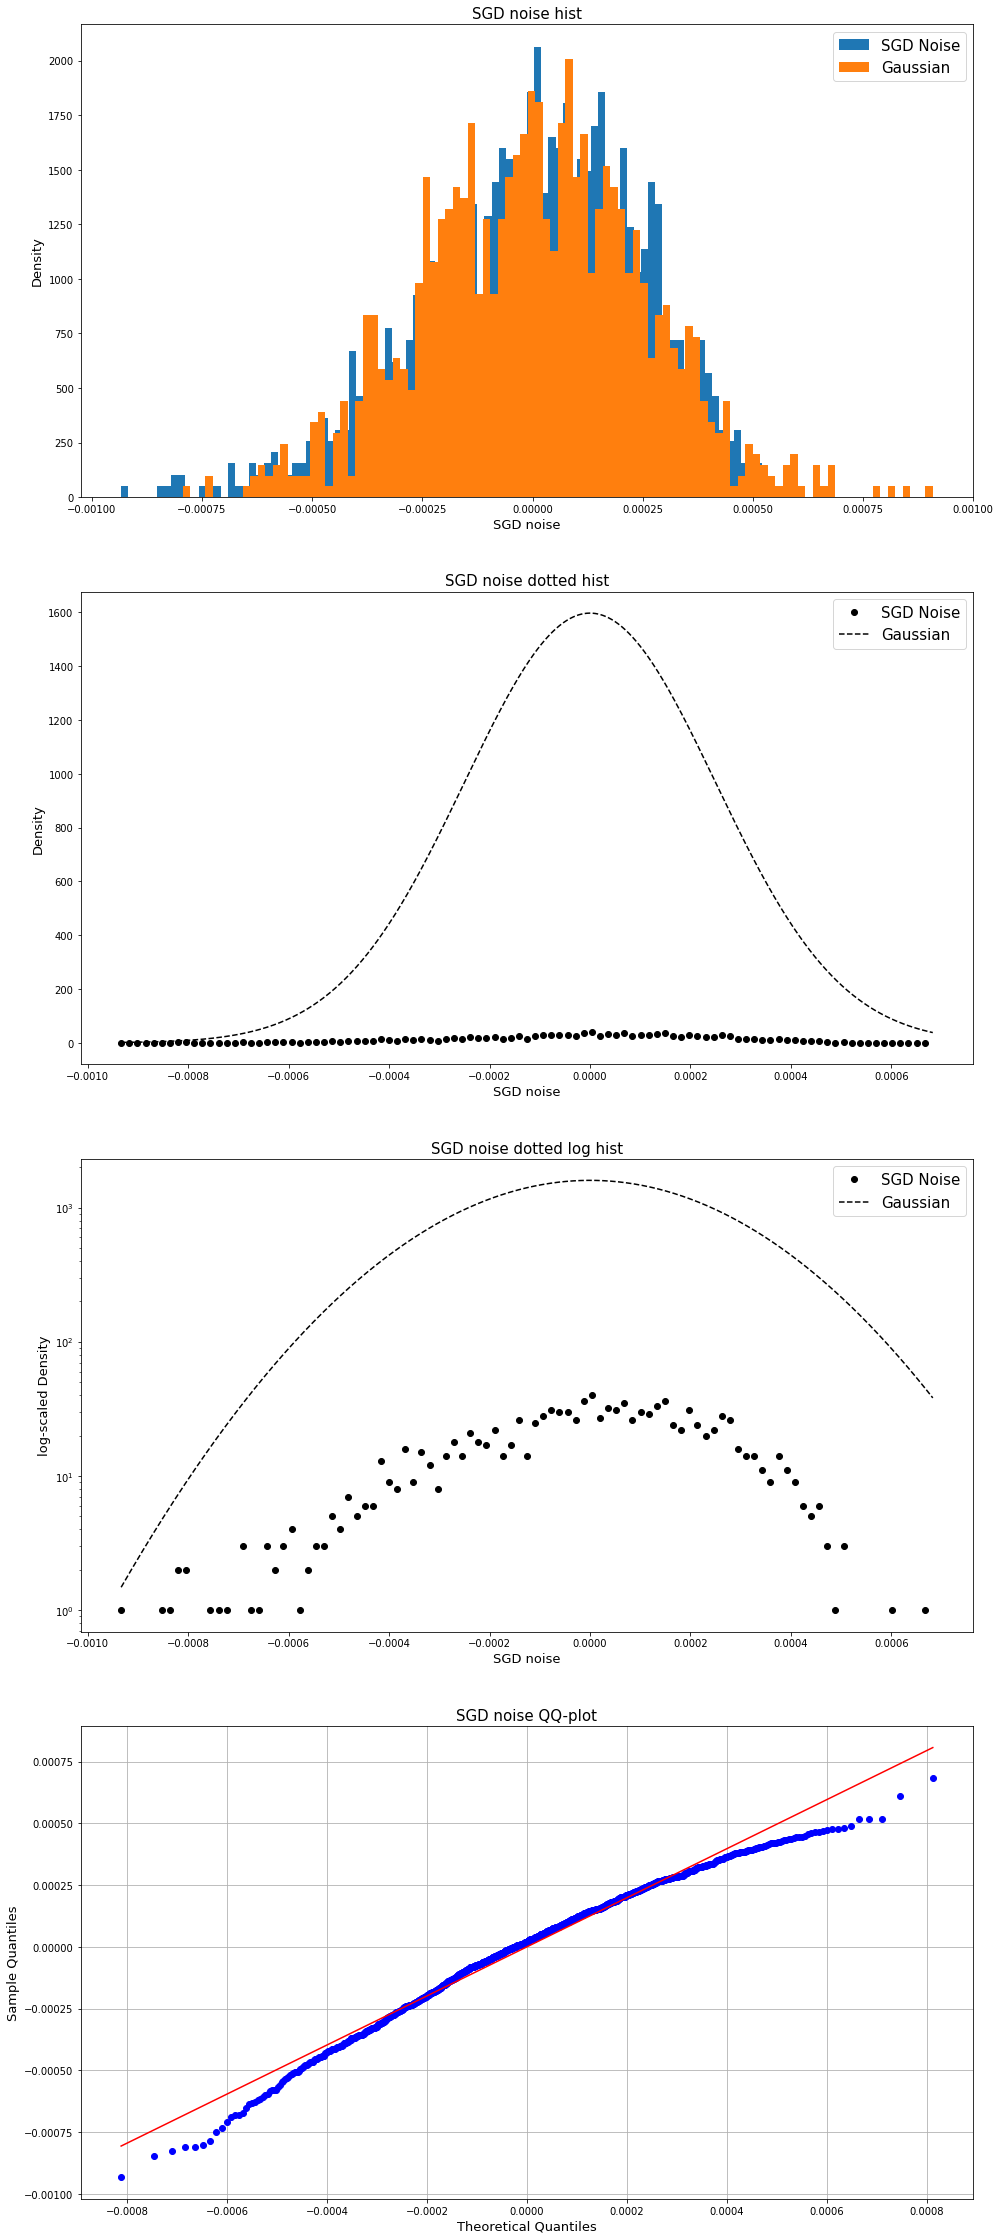

In [47]:
SGD_noise_distplots(SGD_noise=sgn_storage[0][32000], distribution=norm, dist_name='Gaussian', bins=100)

# Found zero gradient

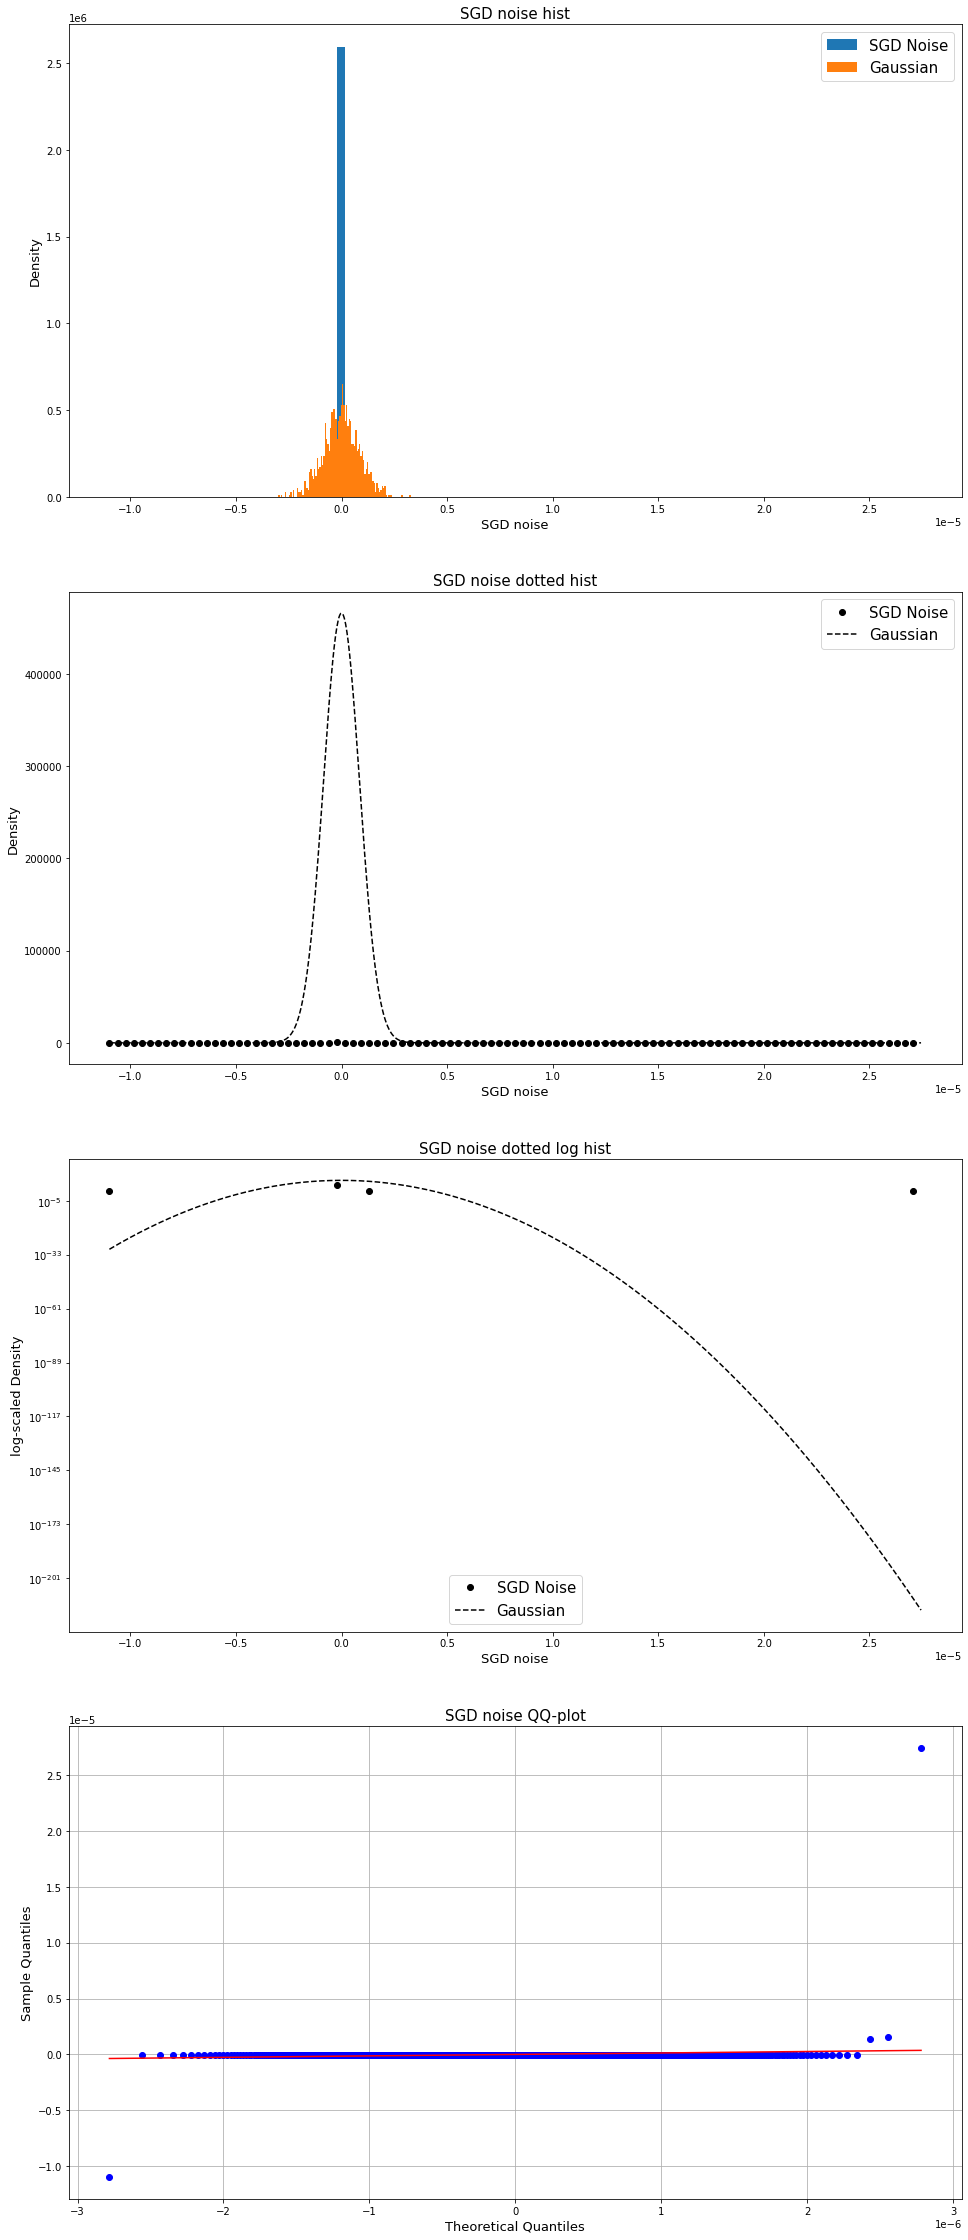

In [48]:
SGD_noise_distplots(SGD_noise=sgn_storage[0][31000], distribution=norm, dist_name='Gaussian', bins=100)

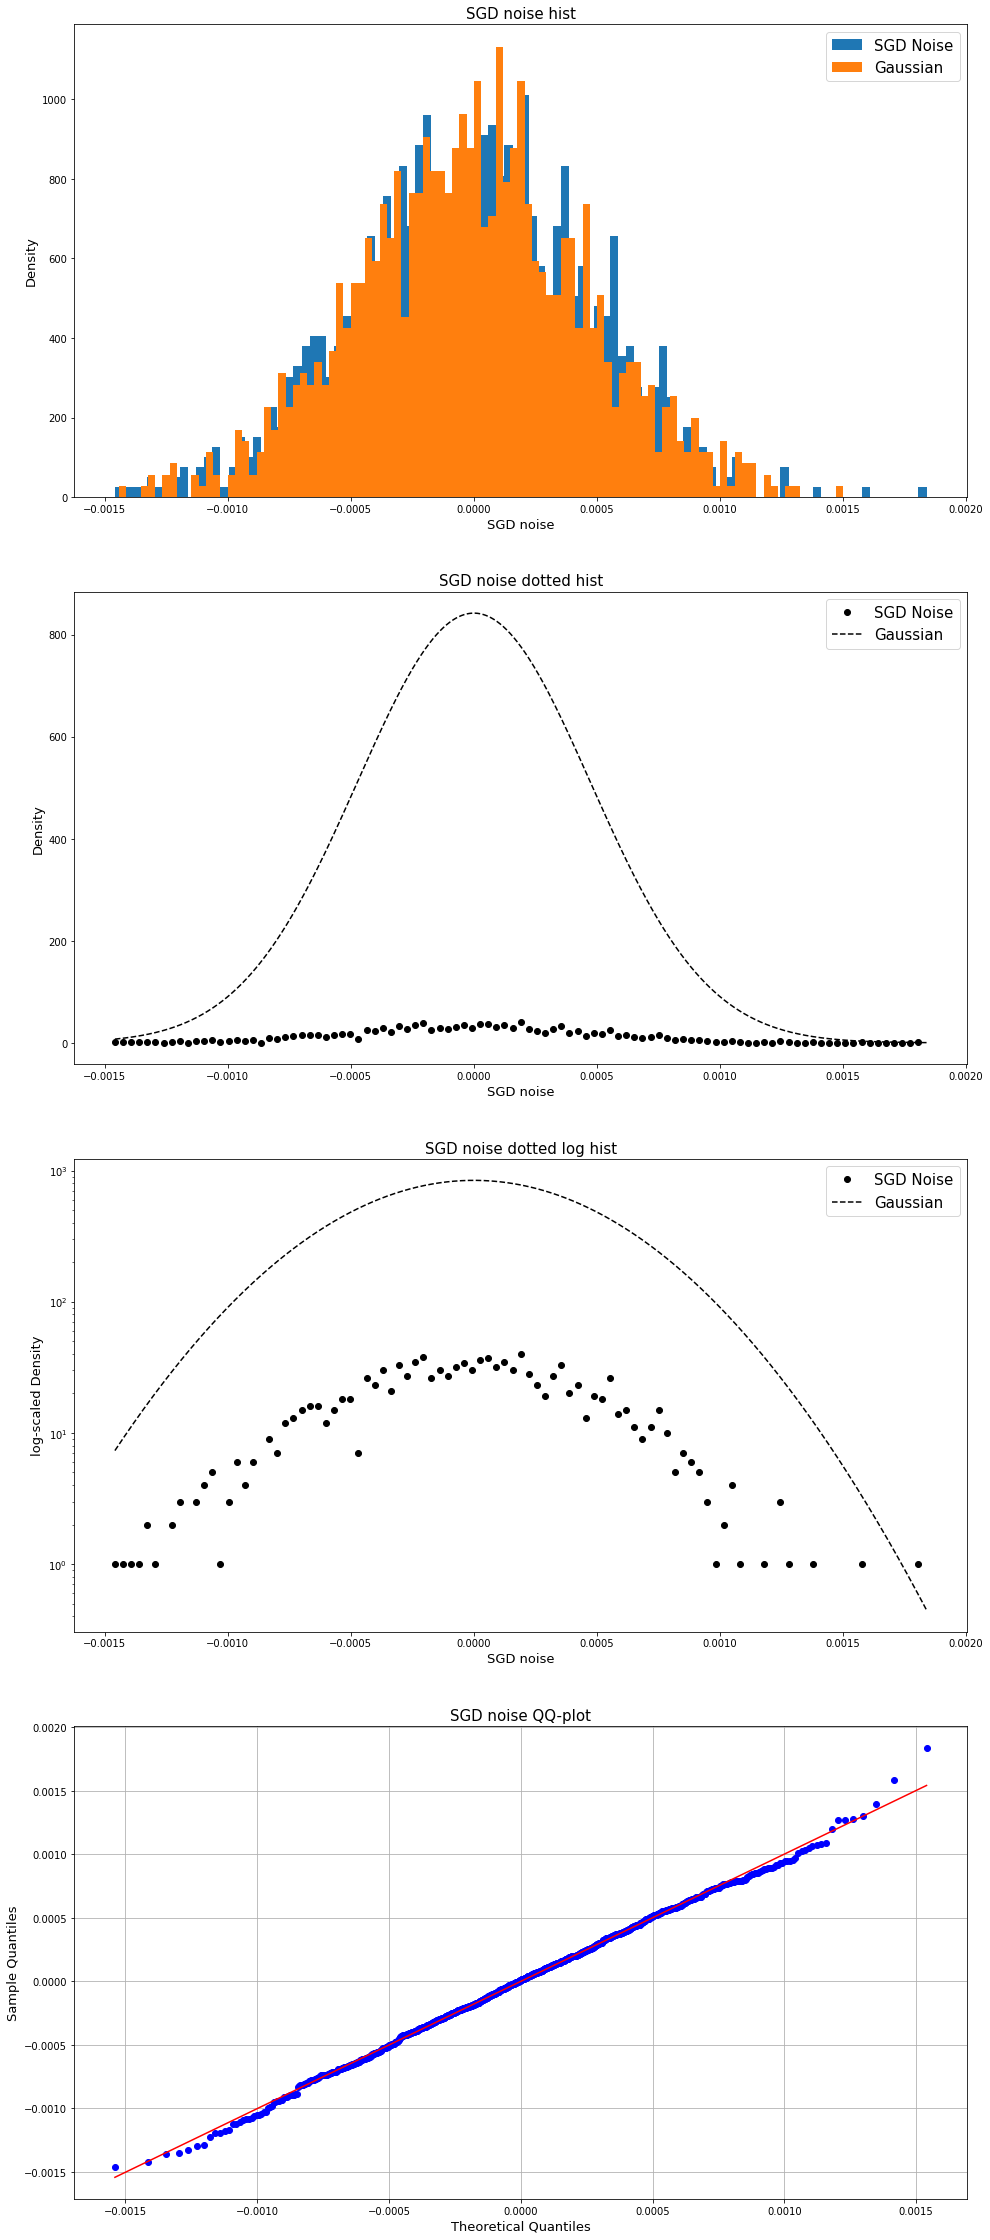

In [25]:
SGD_noise_distplots(SGD_noise=sgn_storage[0][111], distribution=norm, dist_name='Gaussian', bins=100)

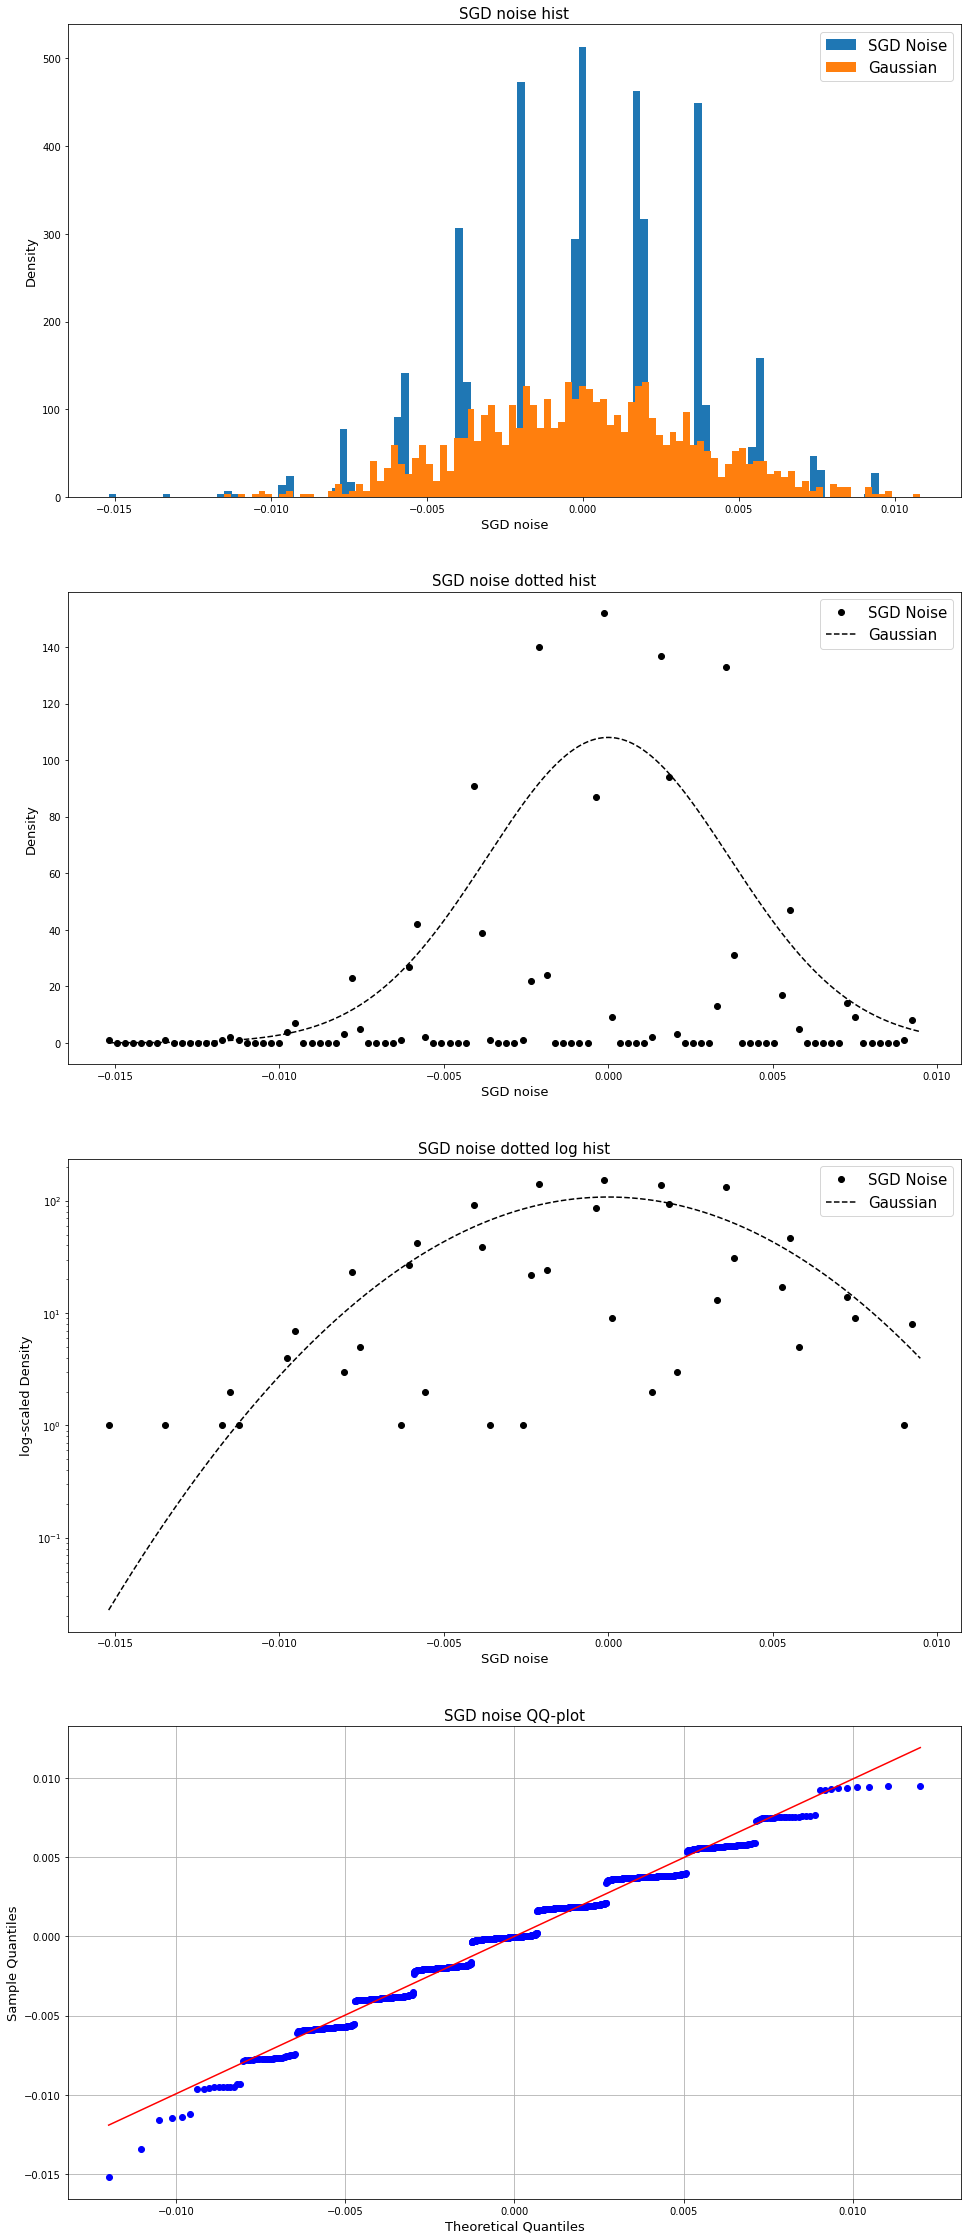

In [26]:
SGD_noise_distplots(SGD_noise=sgn_storage[0][-1], distribution=norm, dist_name='Gaussian', bins=100)

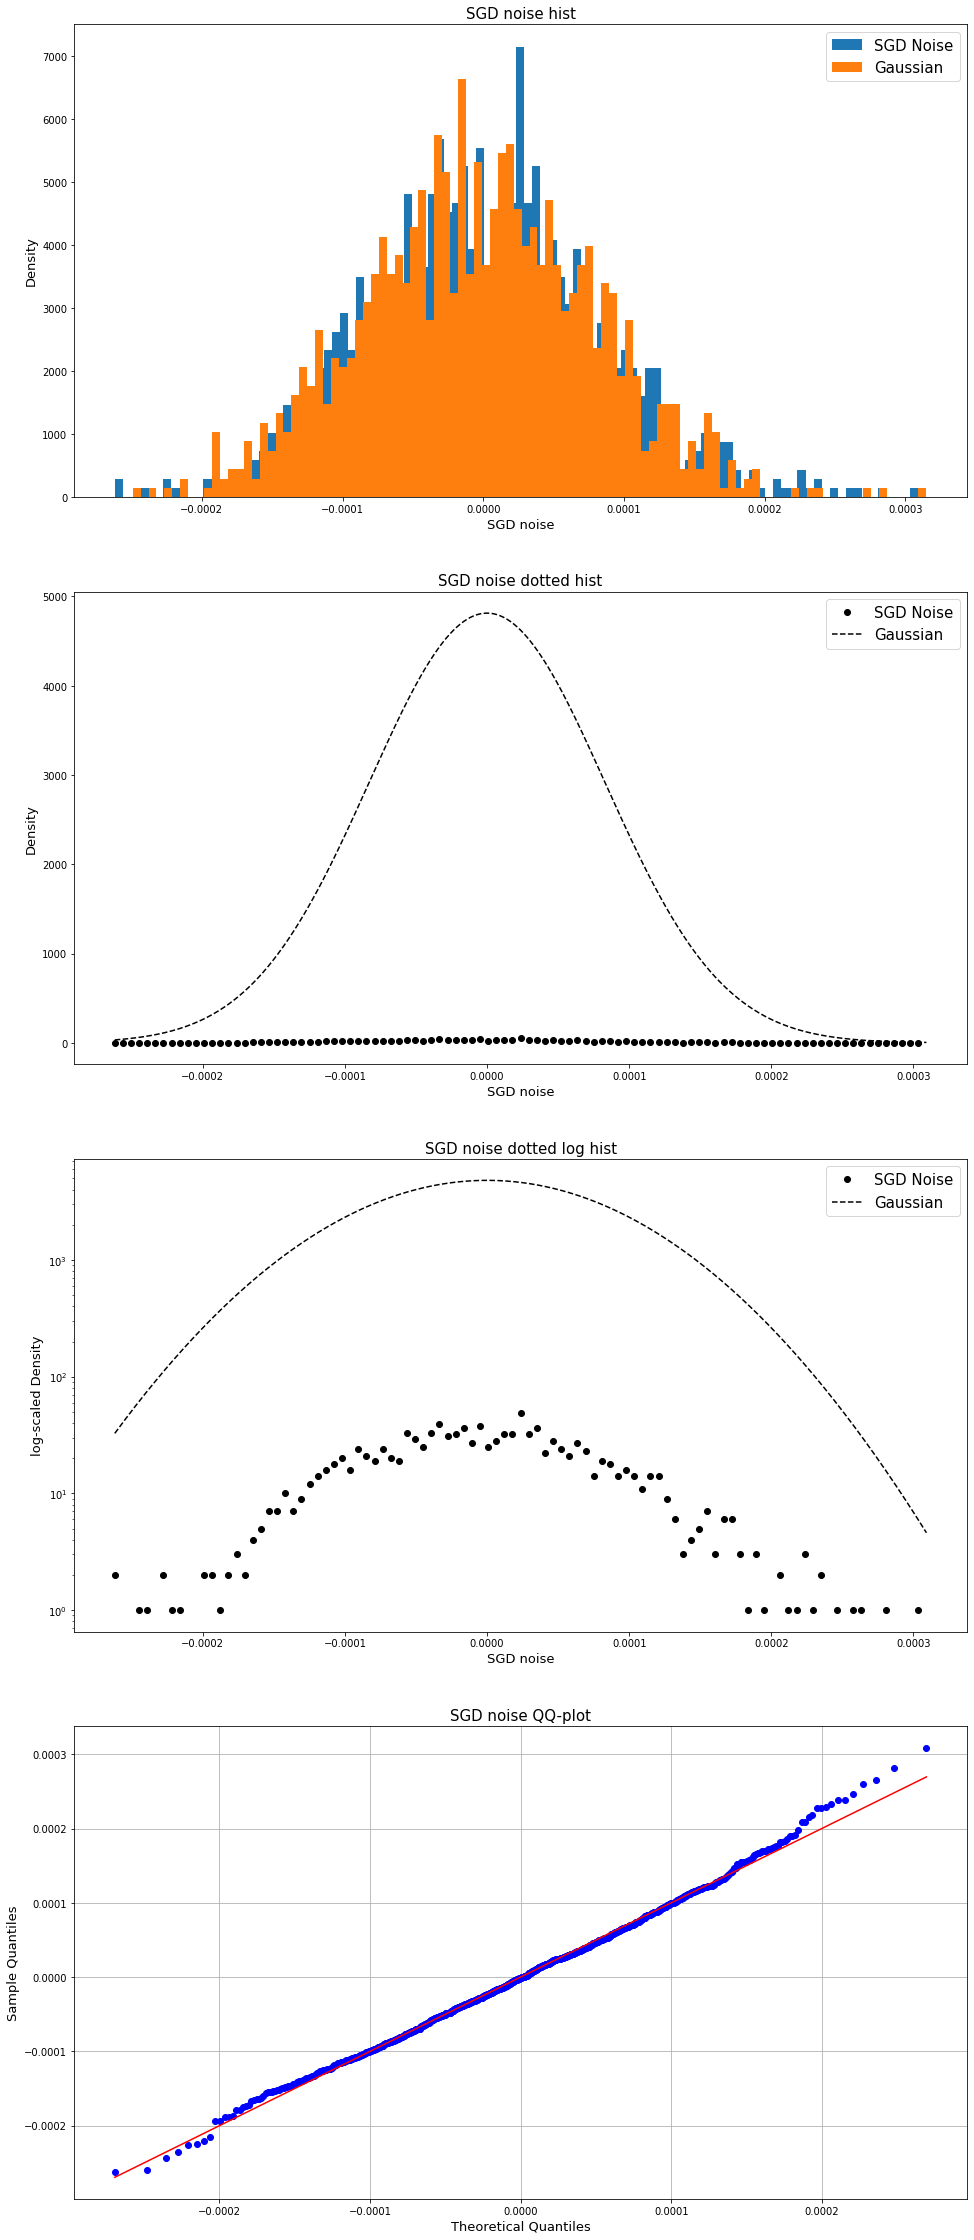

In [27]:
SGD_noise_distplots(SGD_noise=sgn_storage[0][586], distribution=norm, dist_name='Gaussian', bins=100)

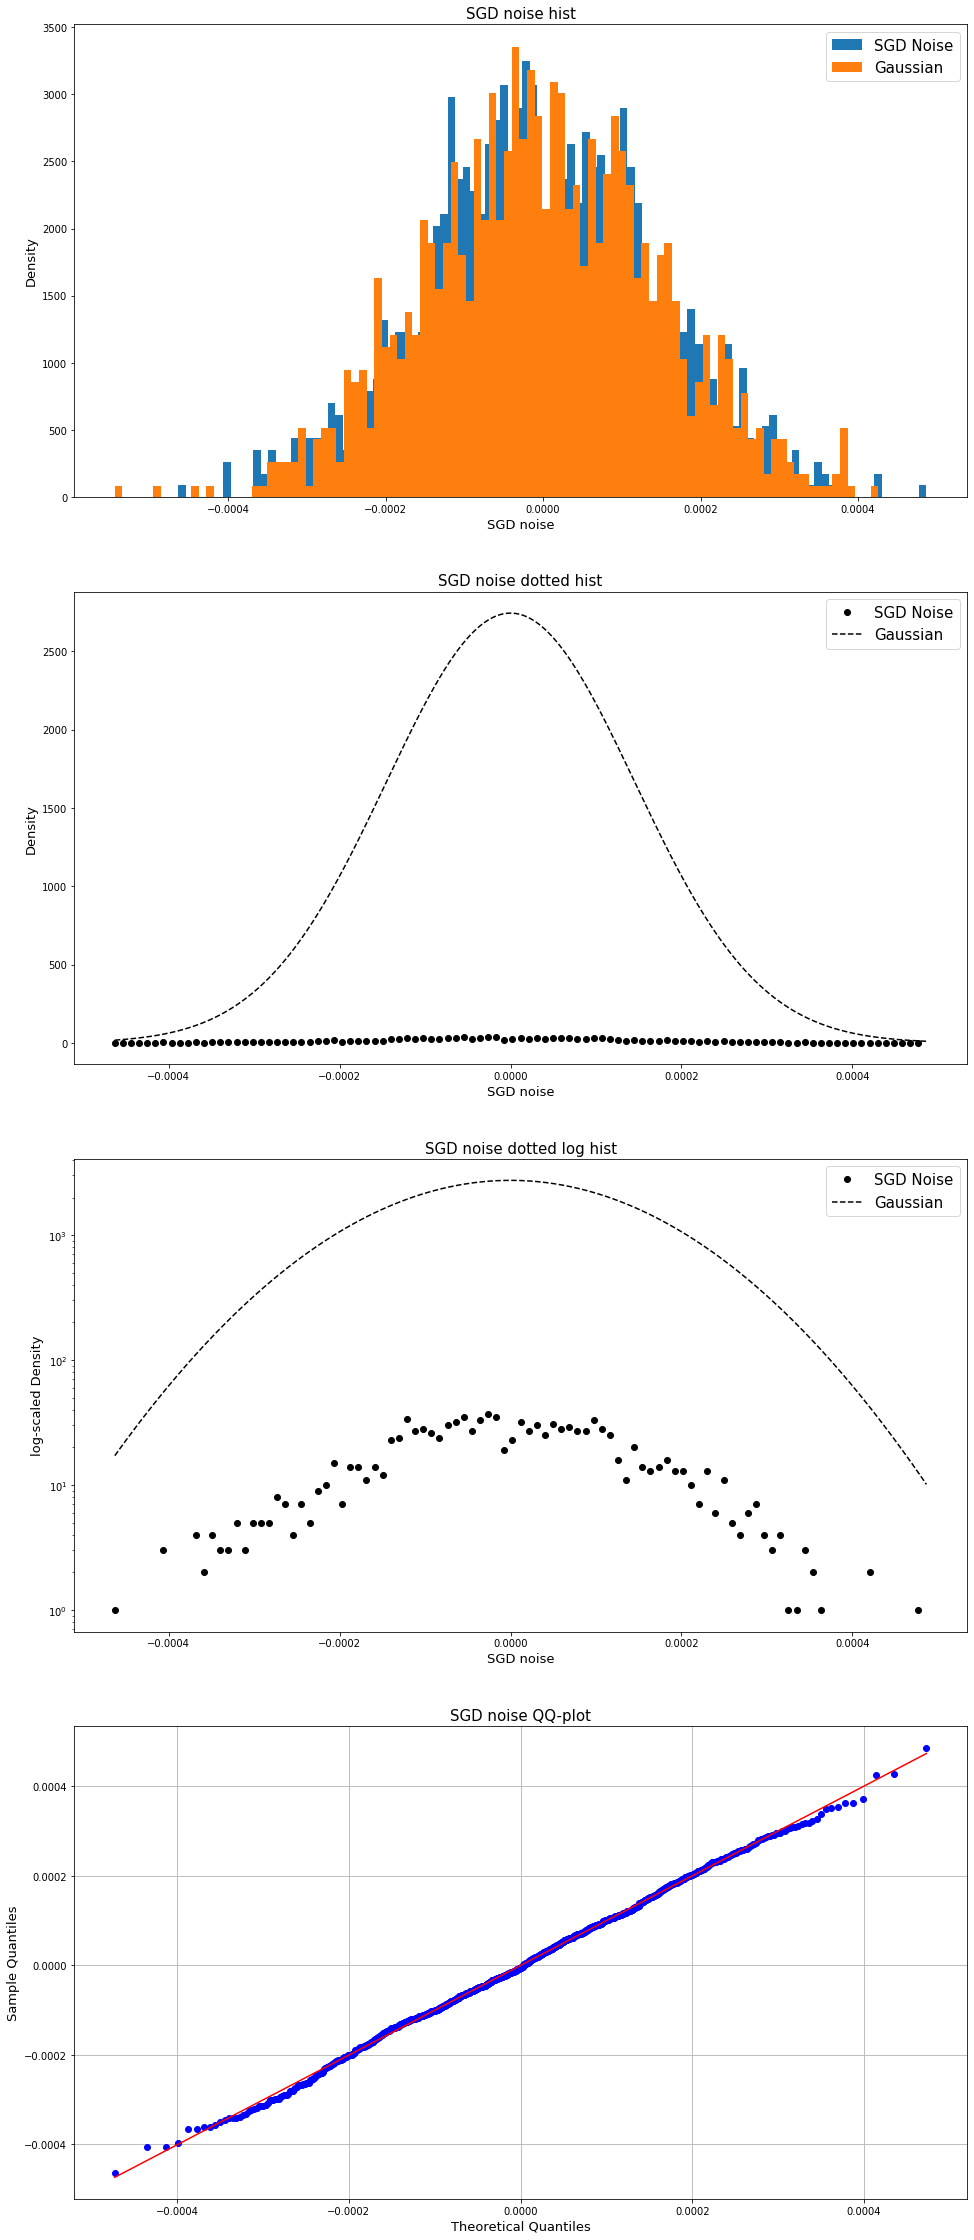

In [28]:
SGD_noise_distplots(SGD_noise=sgn_storage[0][839], distribution=norm, dist_name='Gaussian', bins=100)

## Iteration #10

In [53]:
# 1200 gradients per batch for 89848 neurons in 10th epoch
sgn_storage[10].shape

(32412, 1200)

## Conv1

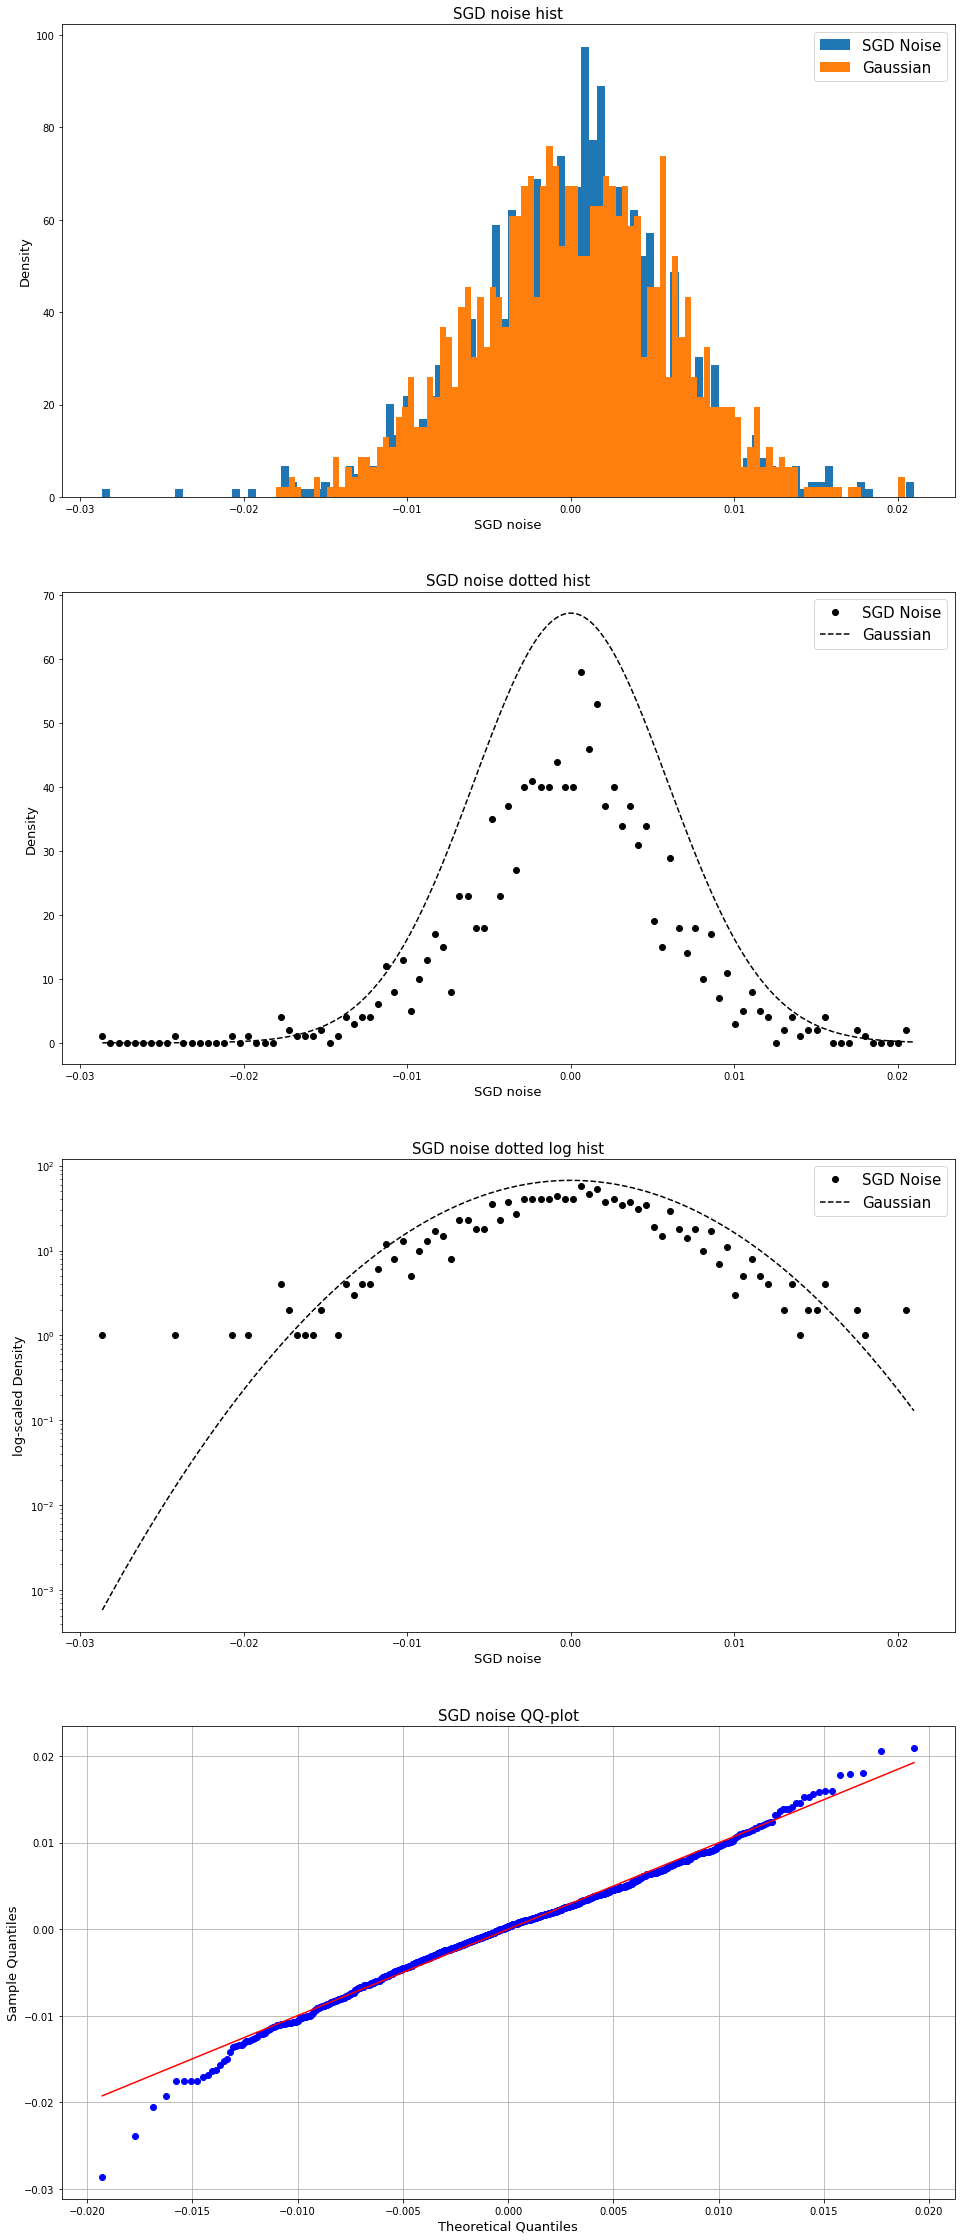

In [71]:
SGD_noise_distplots(SGD_noise=sgn_storage[10][111], distribution=norm, dist_name='Gaussian', bins=100)

## Conv2

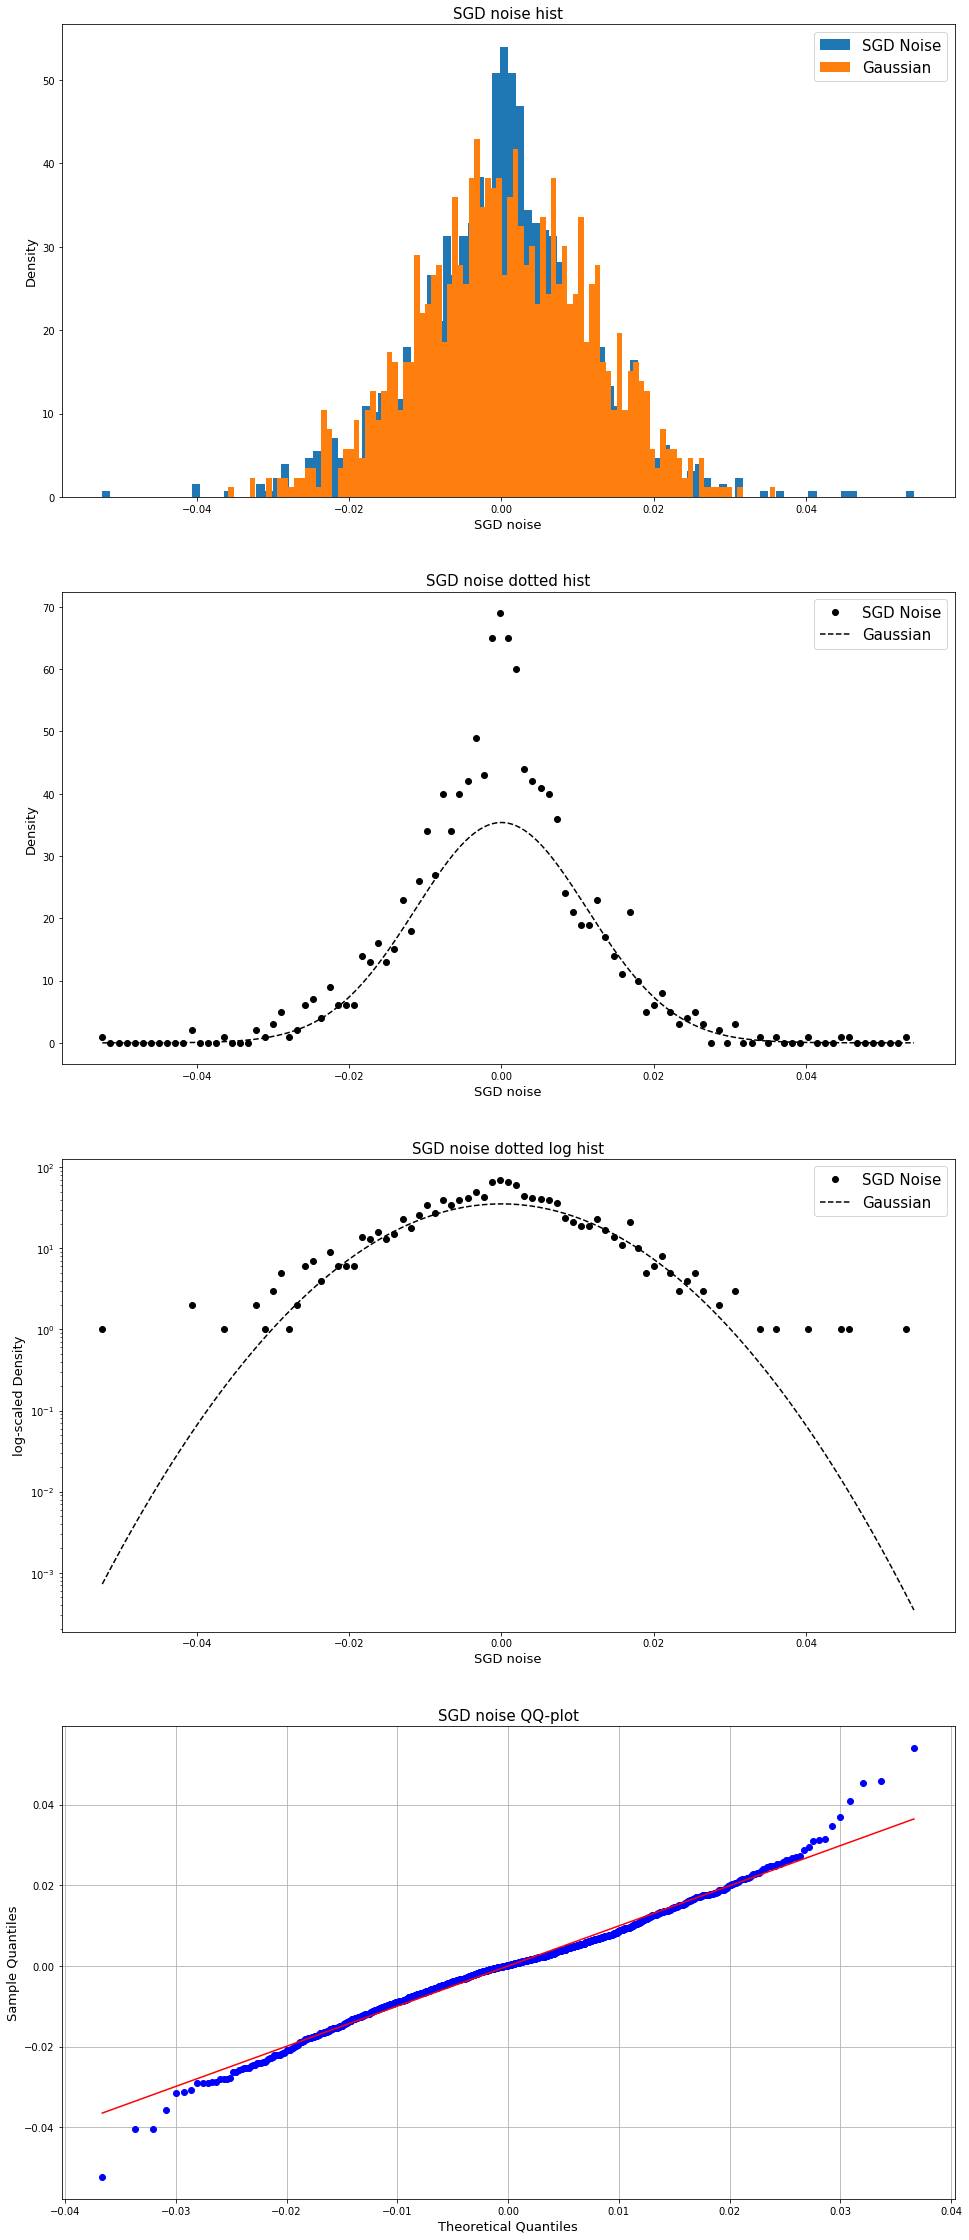

In [70]:
SGD_noise_distplots(SGD_noise=sgn_storage[10][300], distribution=norm, dist_name='Gaussian', bins=100)

## Linear 1

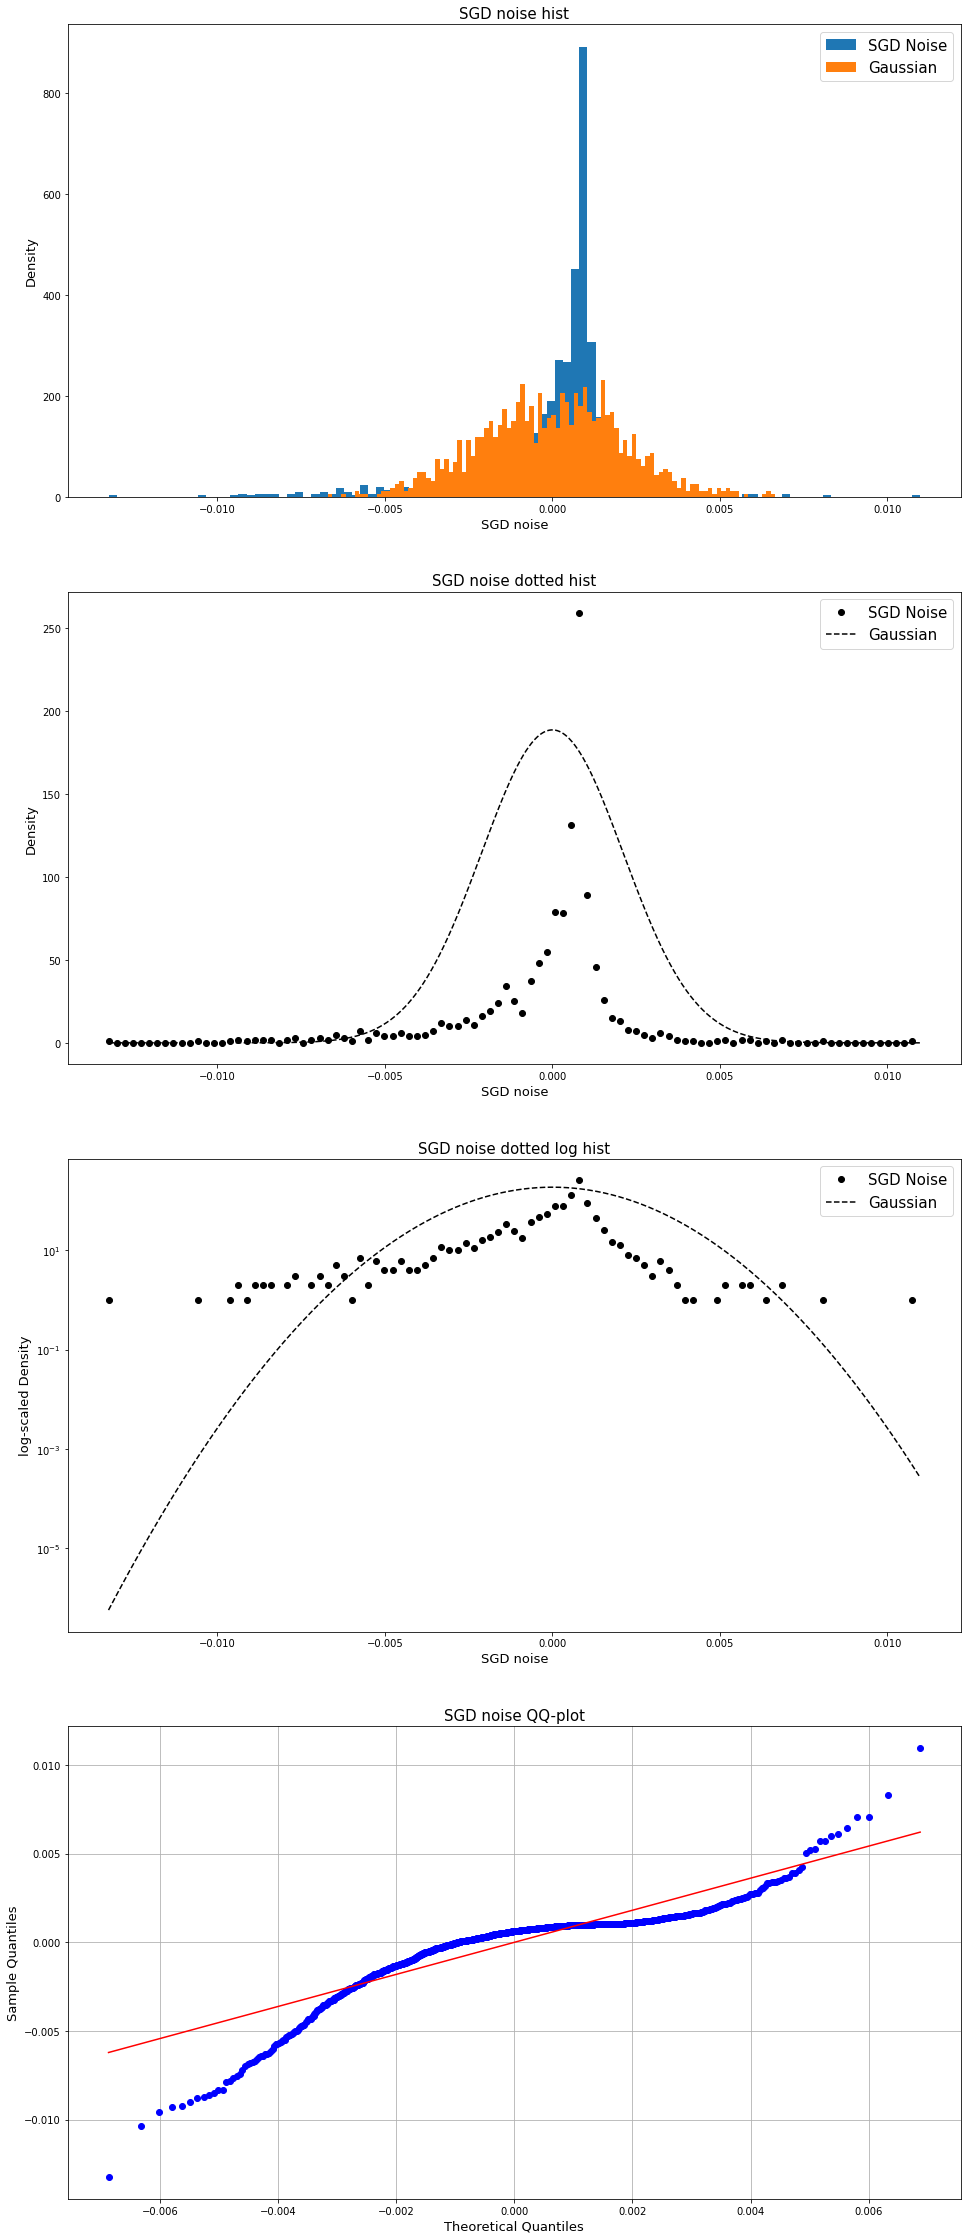

In [69]:
SGD_noise_distplots(SGD_noise=sgn_storage[10][20000], distribution=norm, dist_name='Gaussian', bins=100)

## Linear 2

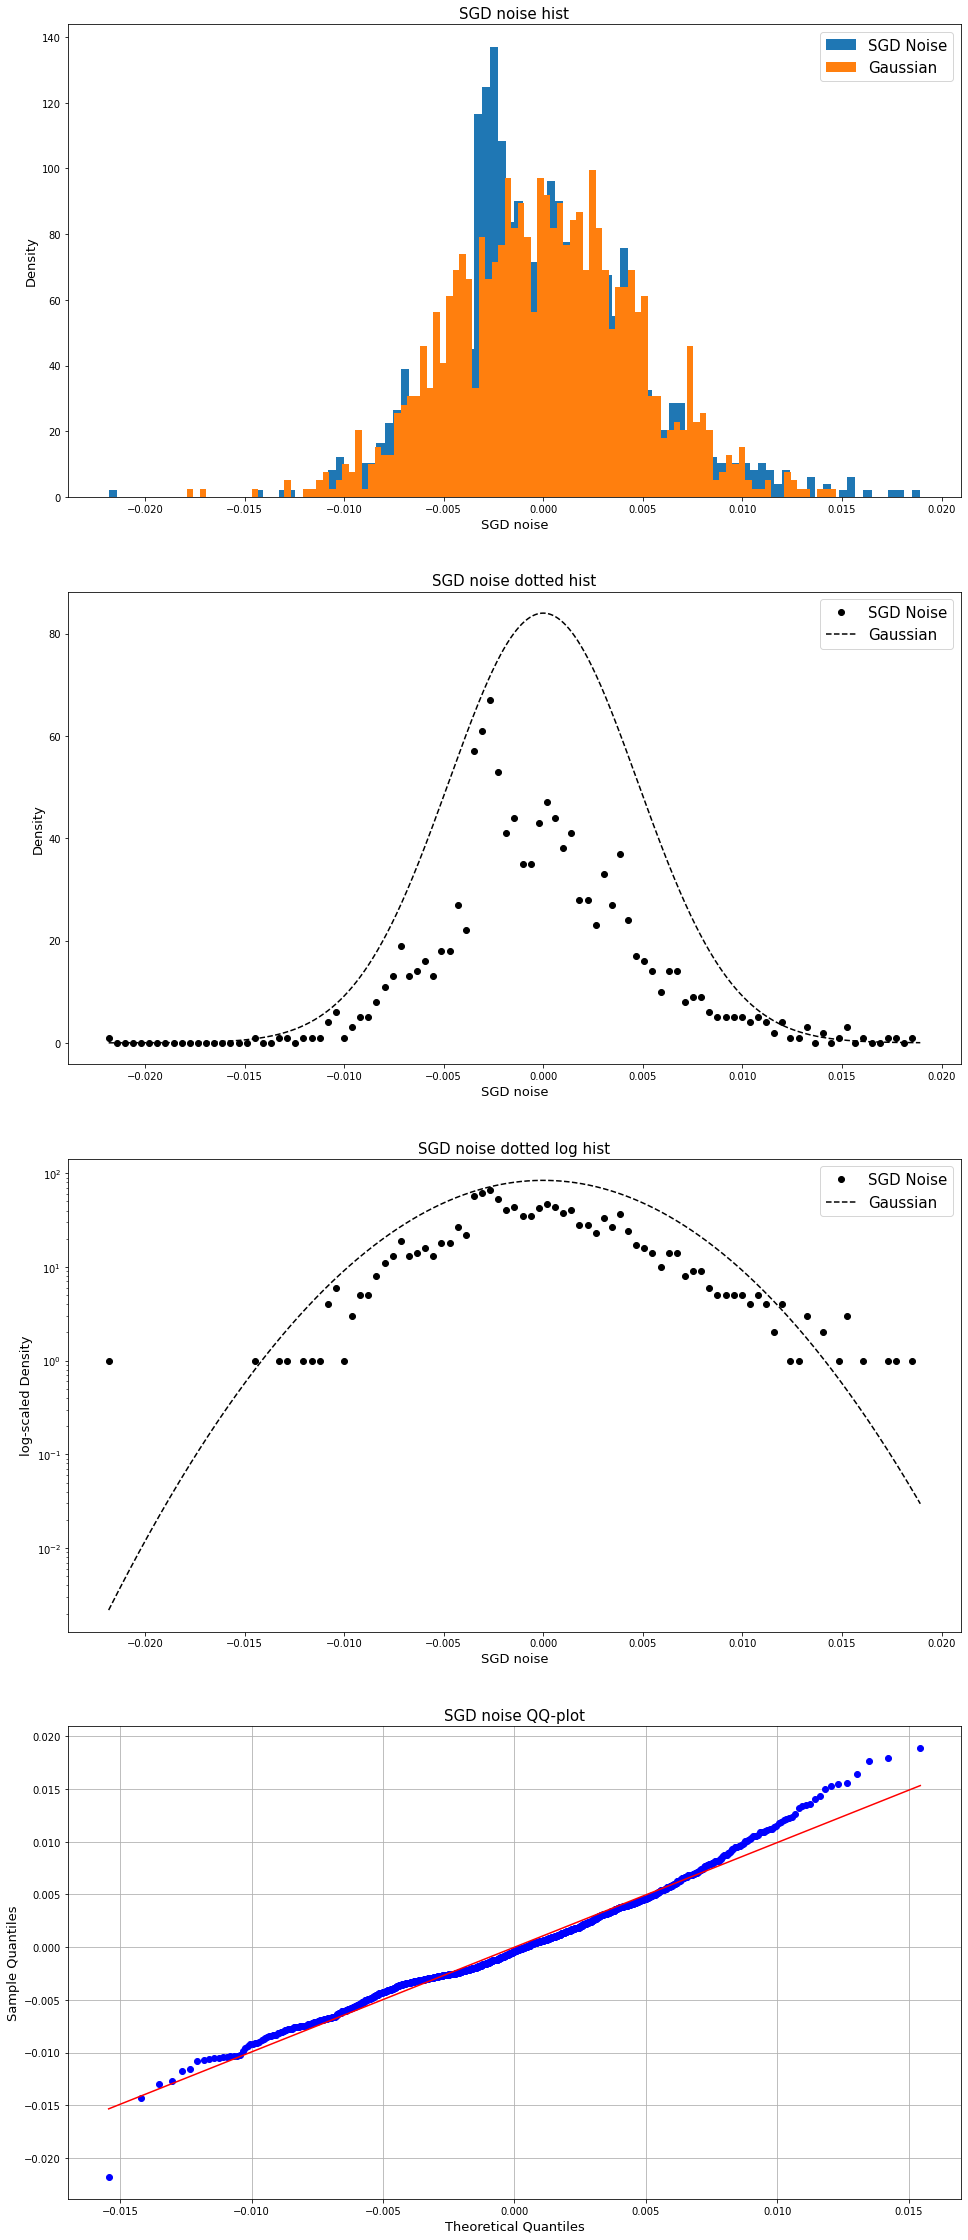

In [68]:
SGD_noise_distplots(SGD_noise=sgn_storage[10][-1], distribution=norm, dist_name='Gaussian', bins=100)

## Iteration #50

In [50]:
# 1200 gradients per batch for 89838 neurons in 15th epoch
sgn_storage[15].shape

(32656, 1200)

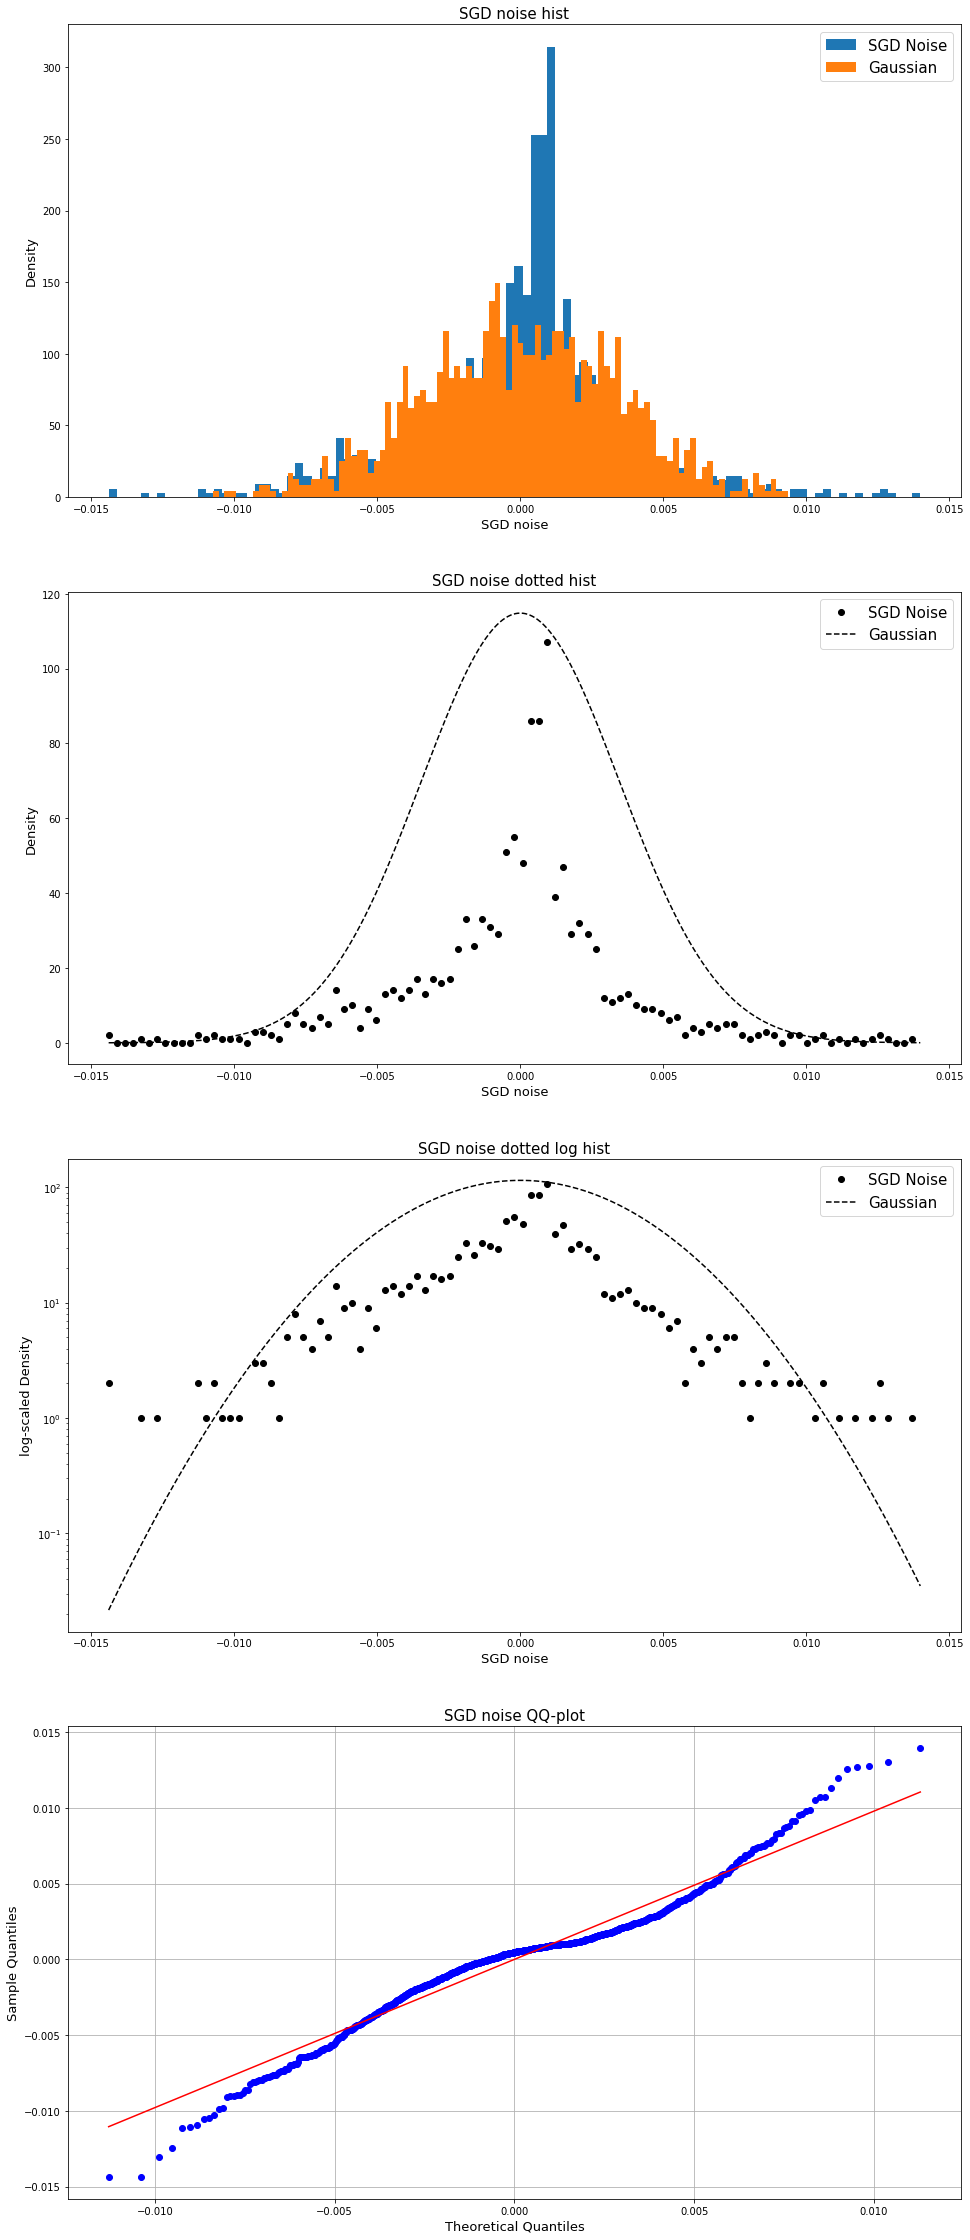

In [58]:
SGD_noise_distplots(SGD_noise=sgn_storage[50][111], distribution=norm, dist_name='Gaussian', bins=100)

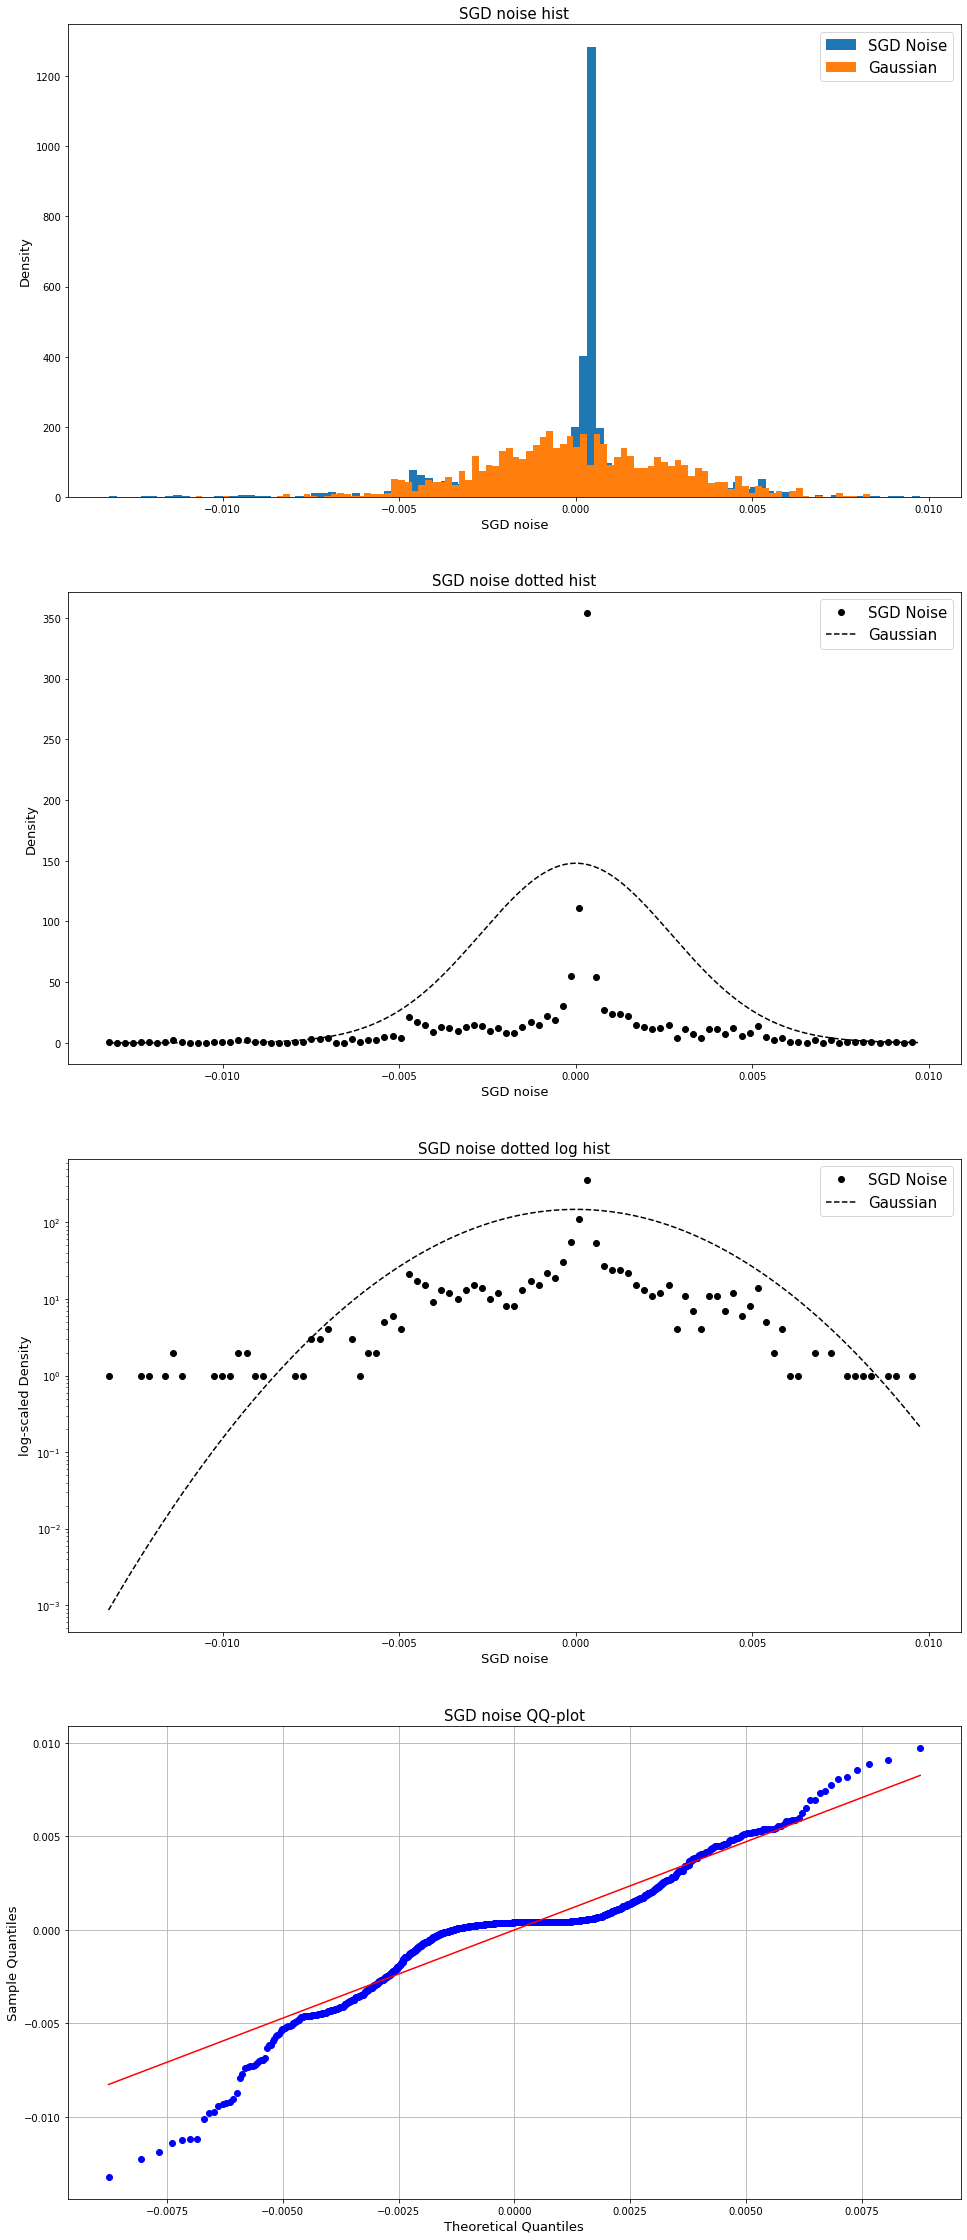

In [59]:
SGD_noise_distplots(SGD_noise=sgn_storage[50][-1], distribution=norm, dist_name='Gaussian', bins=100)

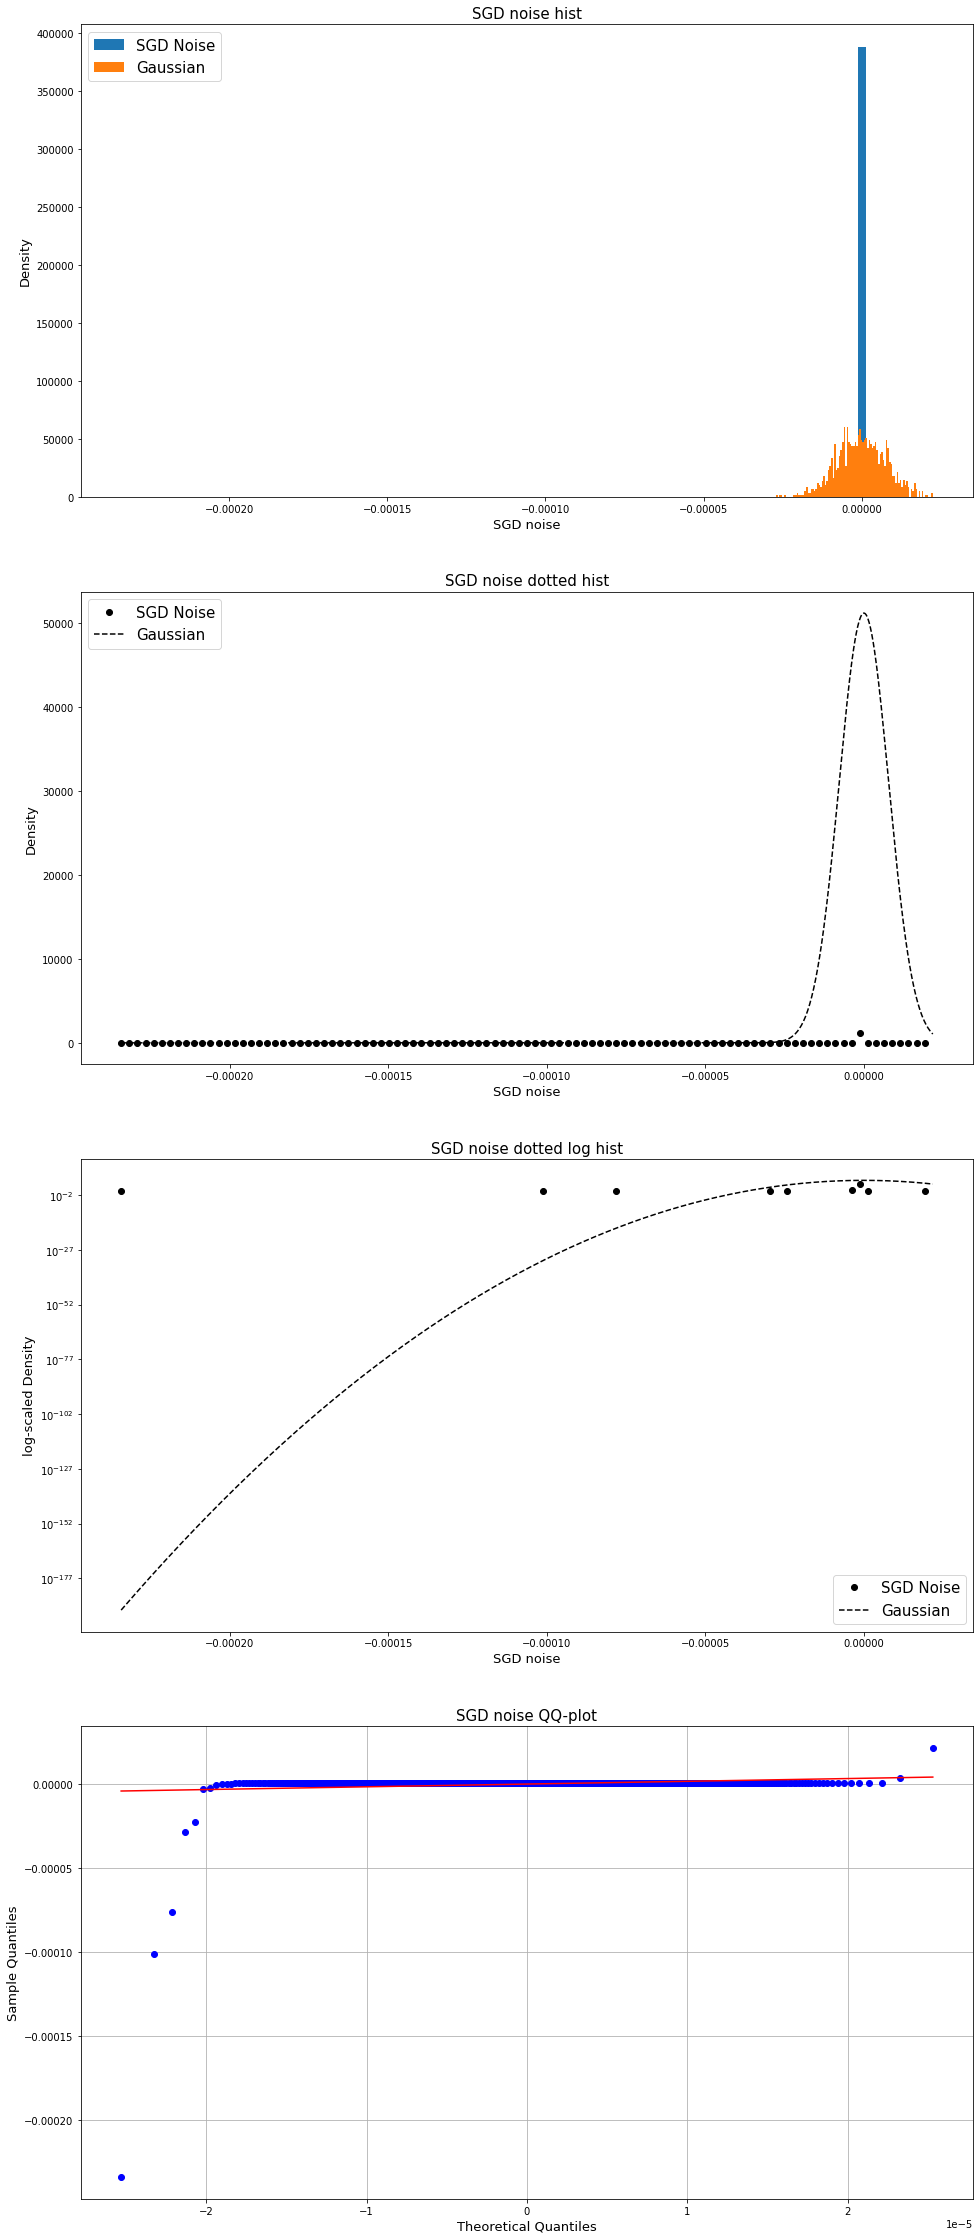

In [173]:
SGD_noise_distplots(SGD_noise=sgn_storage[50][20000], distribution=norm, dist_name='Gaussian', bins=100)

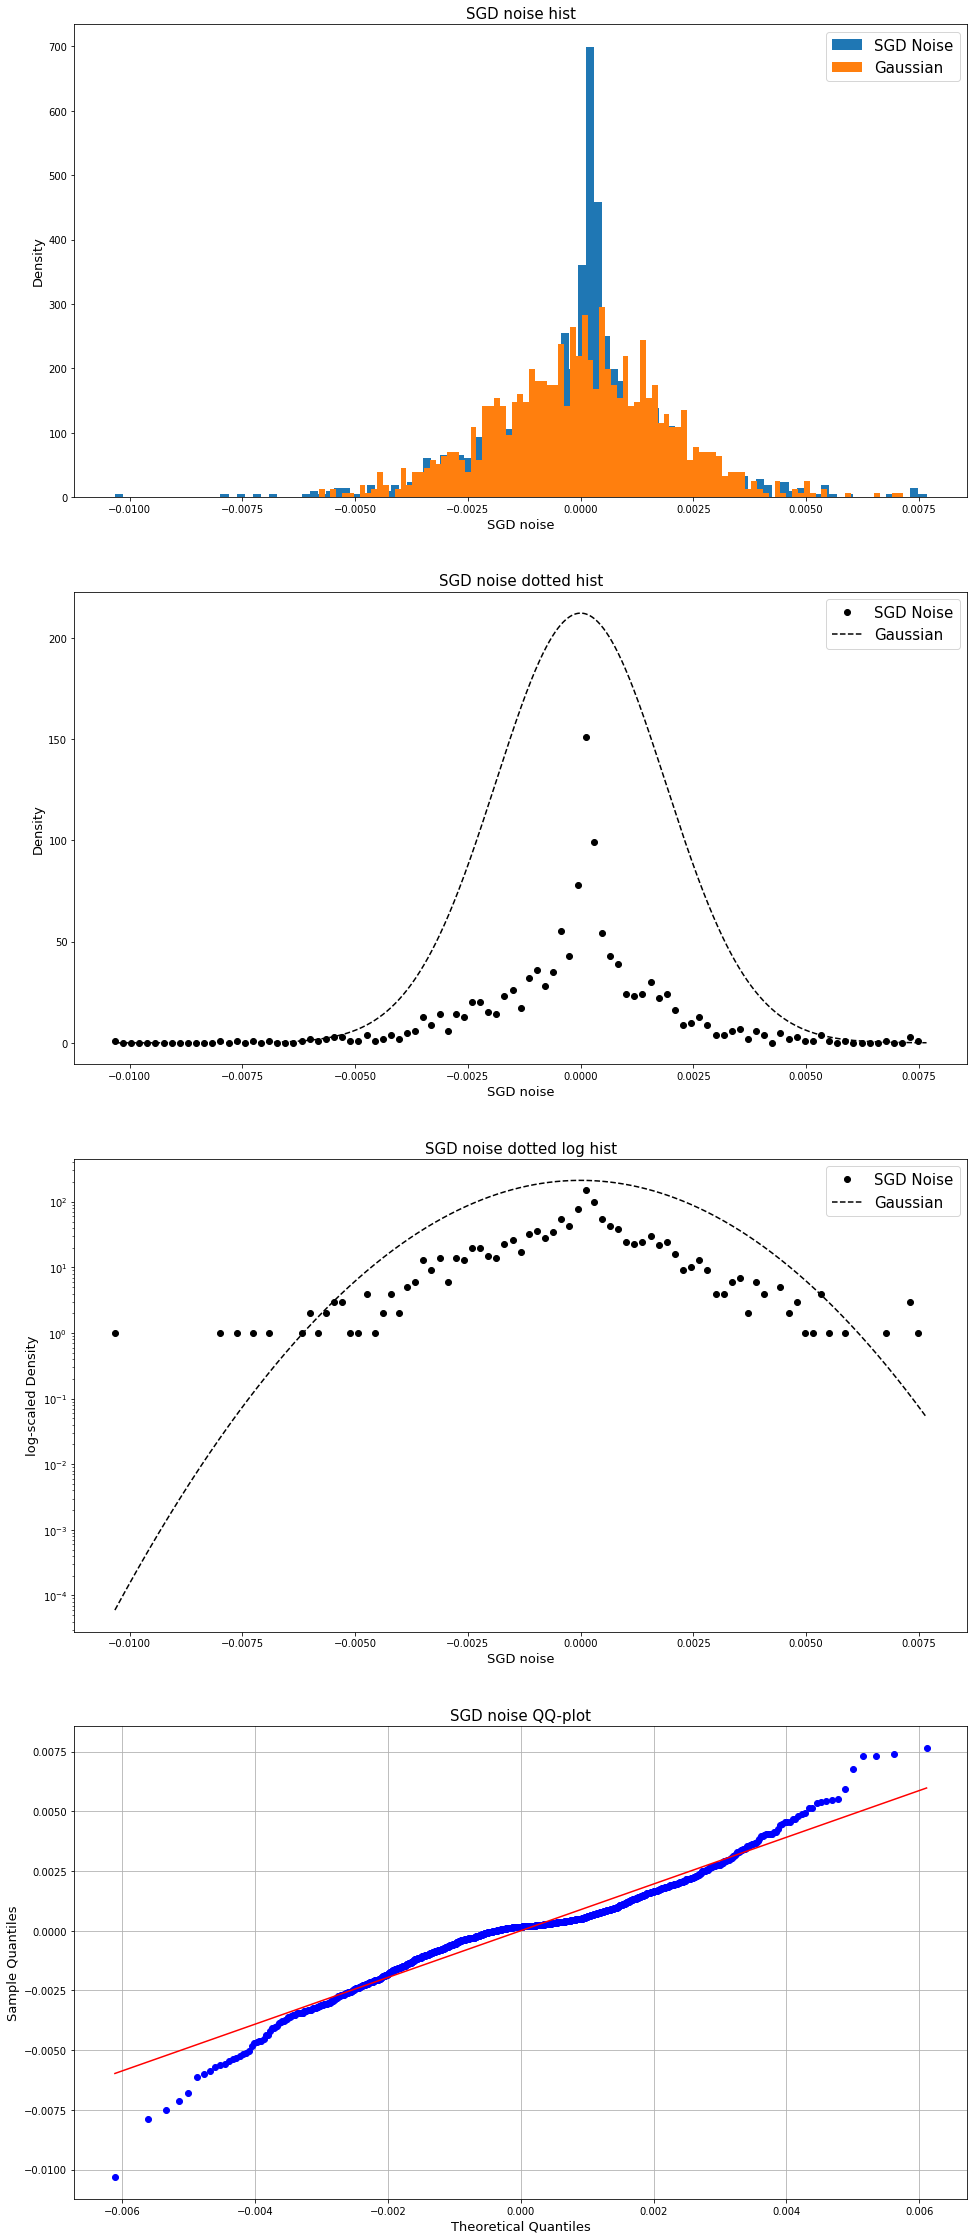

In [61]:
SGD_noise_distplots(SGD_noise=sgn_storage[50][839], distribution=norm, dist_name='Gaussian', bins=100)

## And so on untill last Iteration

## Saved iteration #100

In [62]:
# 1200 gradients for 1200 batch for 89985 neurons in 50th epoch
sgn_storage[100].shape

(35408, 1200)

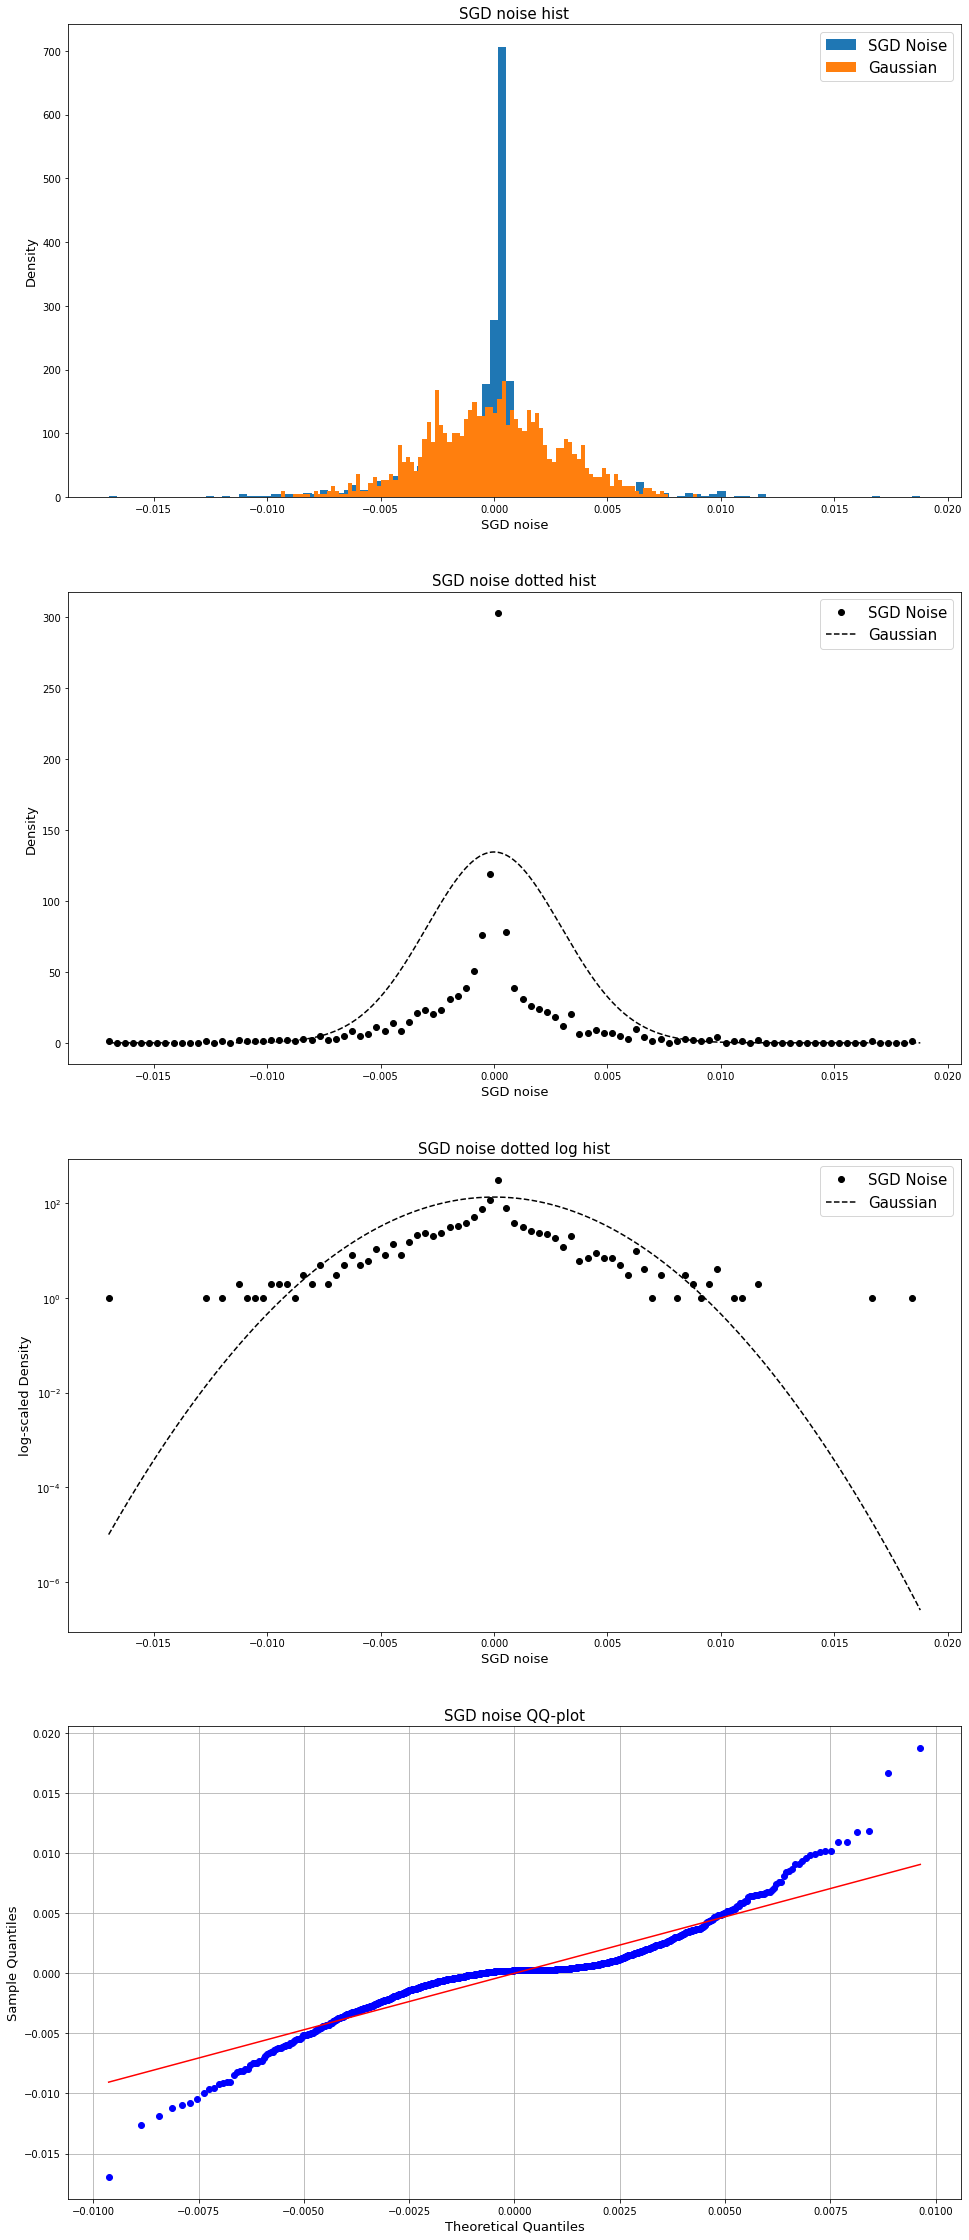

In [63]:
SGD_noise_distplots(SGD_noise=sgn_storage[100][111], distribution=norm, dist_name='Gaussian', bins=100)

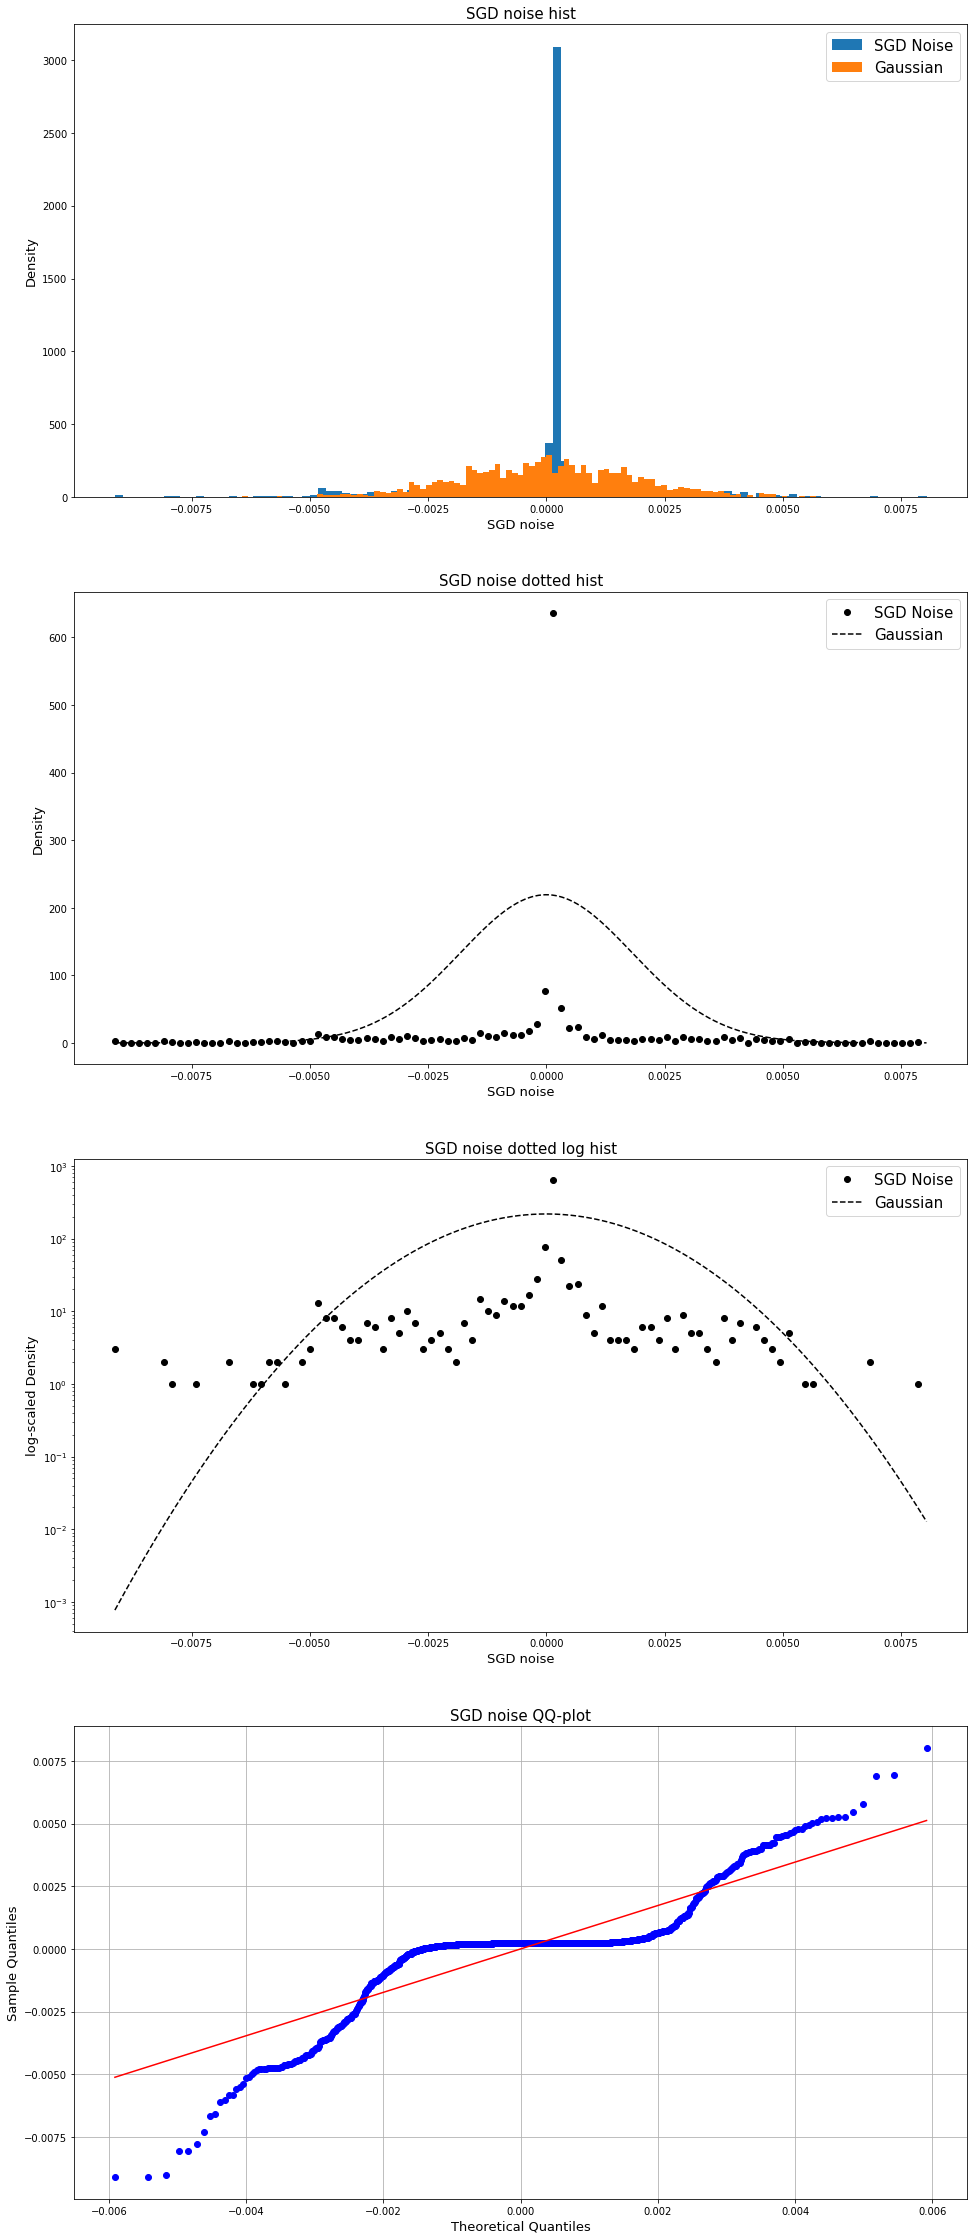

In [64]:
SGD_noise_distplots(SGD_noise=sgn_storage[100][-1], distribution=norm, dist_name='Gaussian', bins=100)

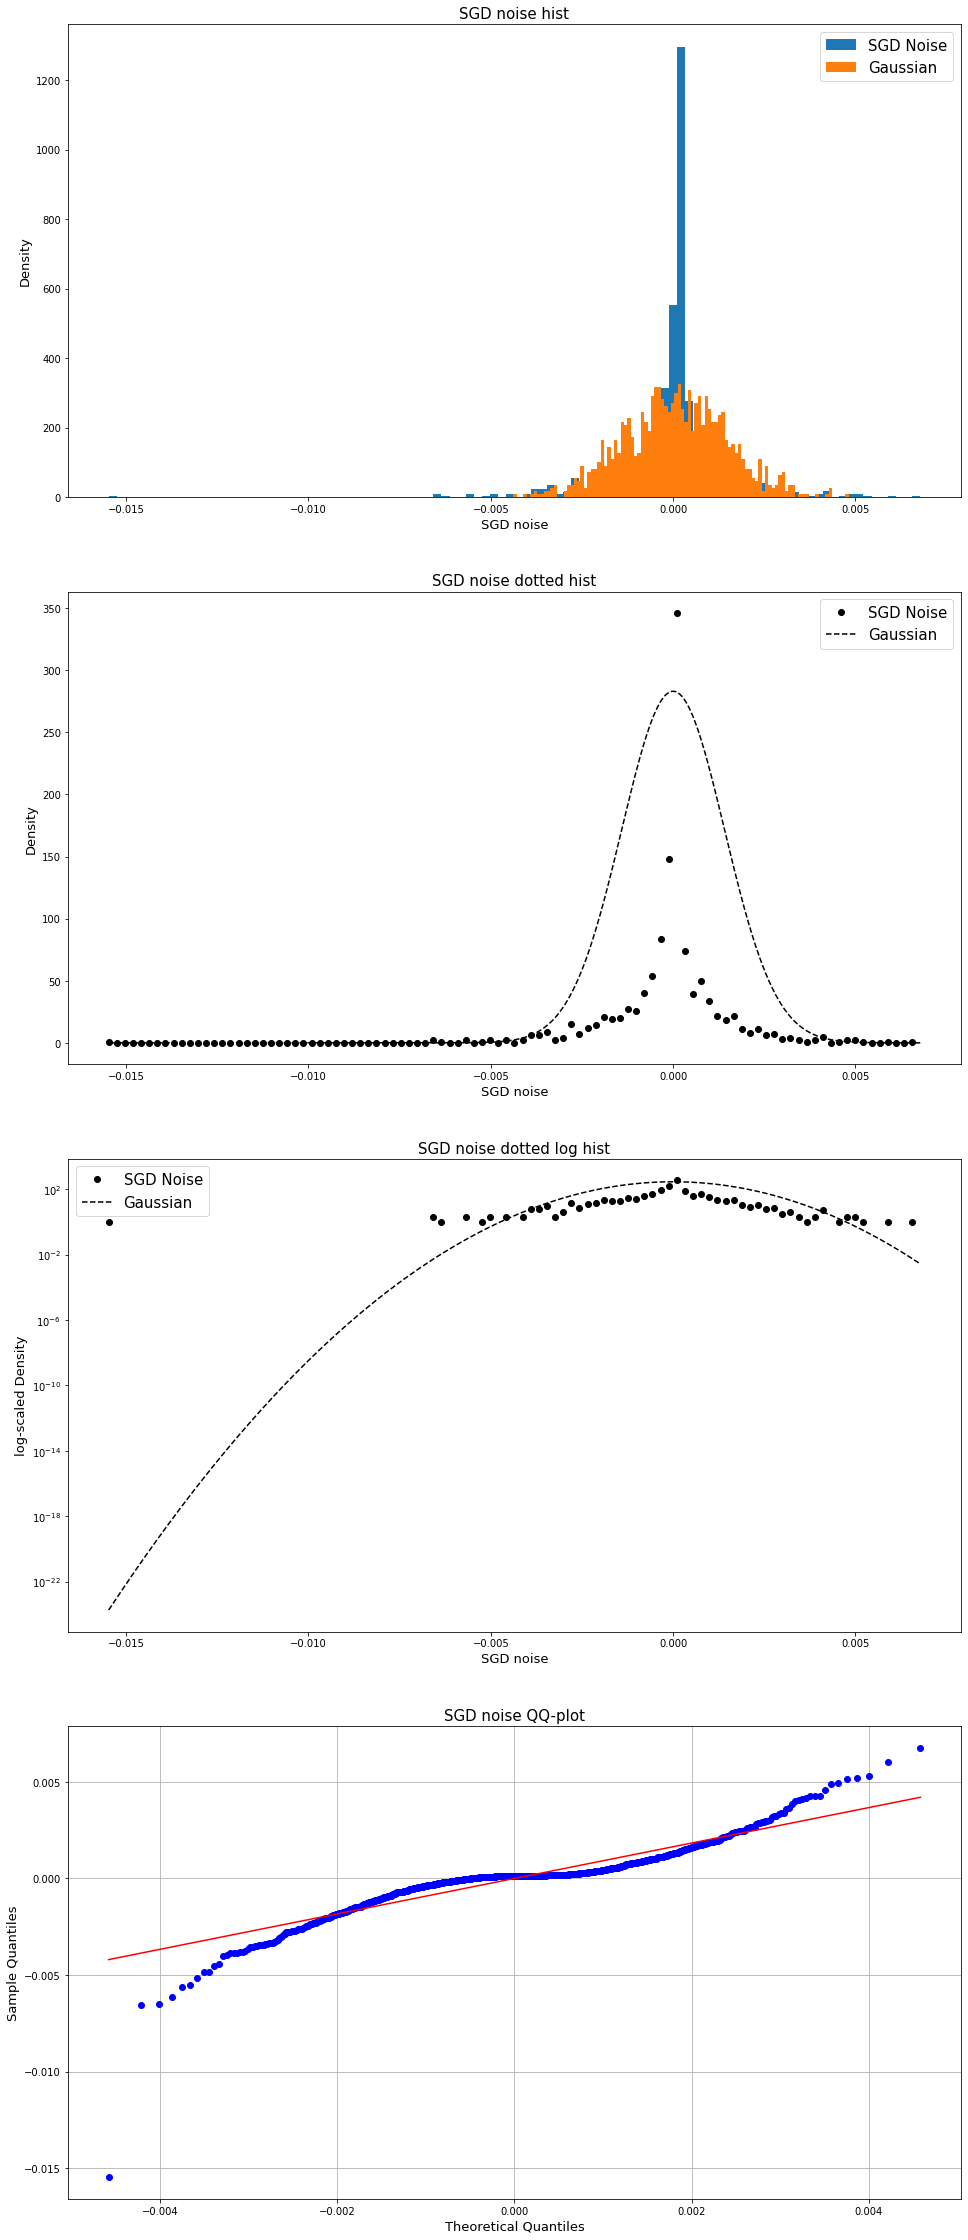

In [65]:
SGD_noise_distplots(SGD_noise=sgn_storage[100][586], distribution=norm, dist_name='Gaussian', bins=100)

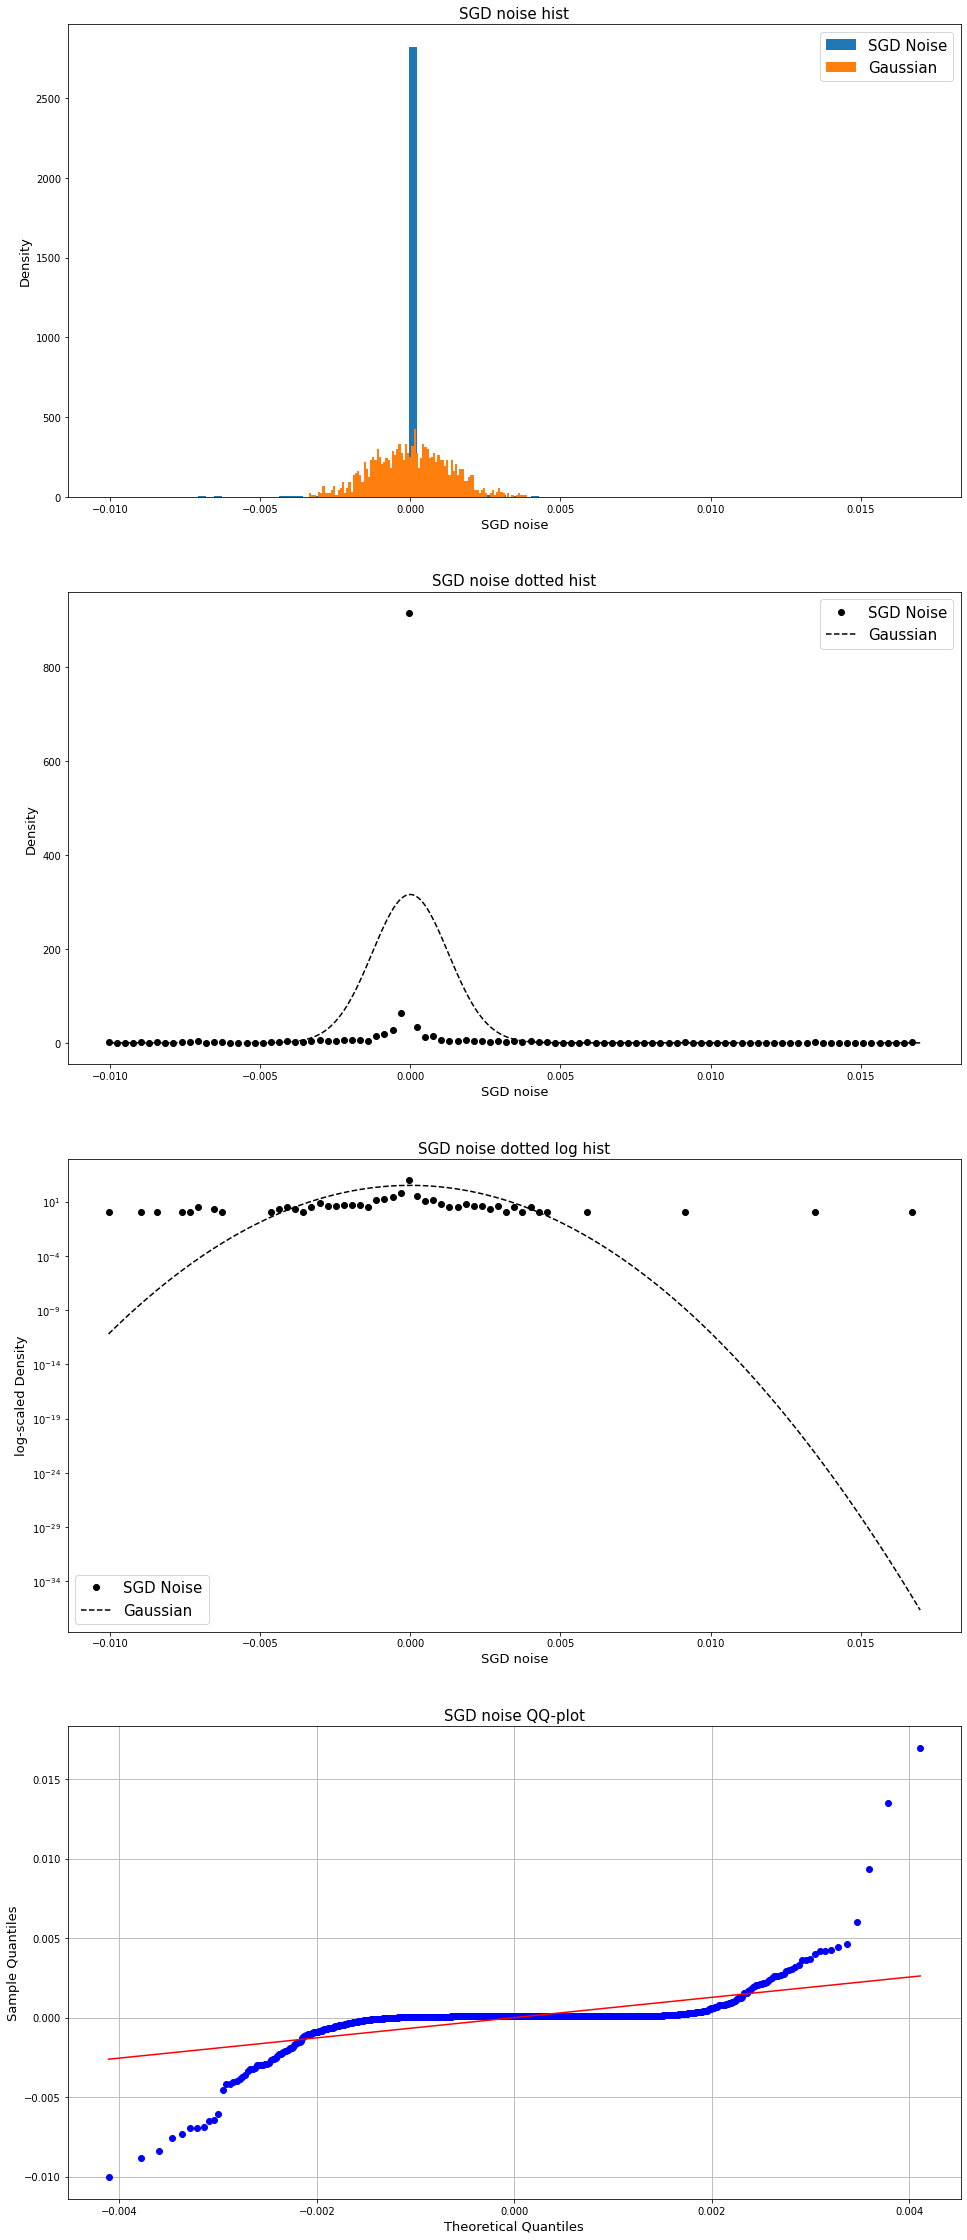

In [169]:
SGD_noise_distplots(SGD_noise=sgn_storage[100][20000], distribution=norm, dist_name='Gaussian', bins=100)

## Saved iteration #120

In [72]:
# 1200 gradients for 1200 batch for 89985 neurons in 50th epoch
sgn_storage[-1].shape

(35278, 1200)

## Conv1

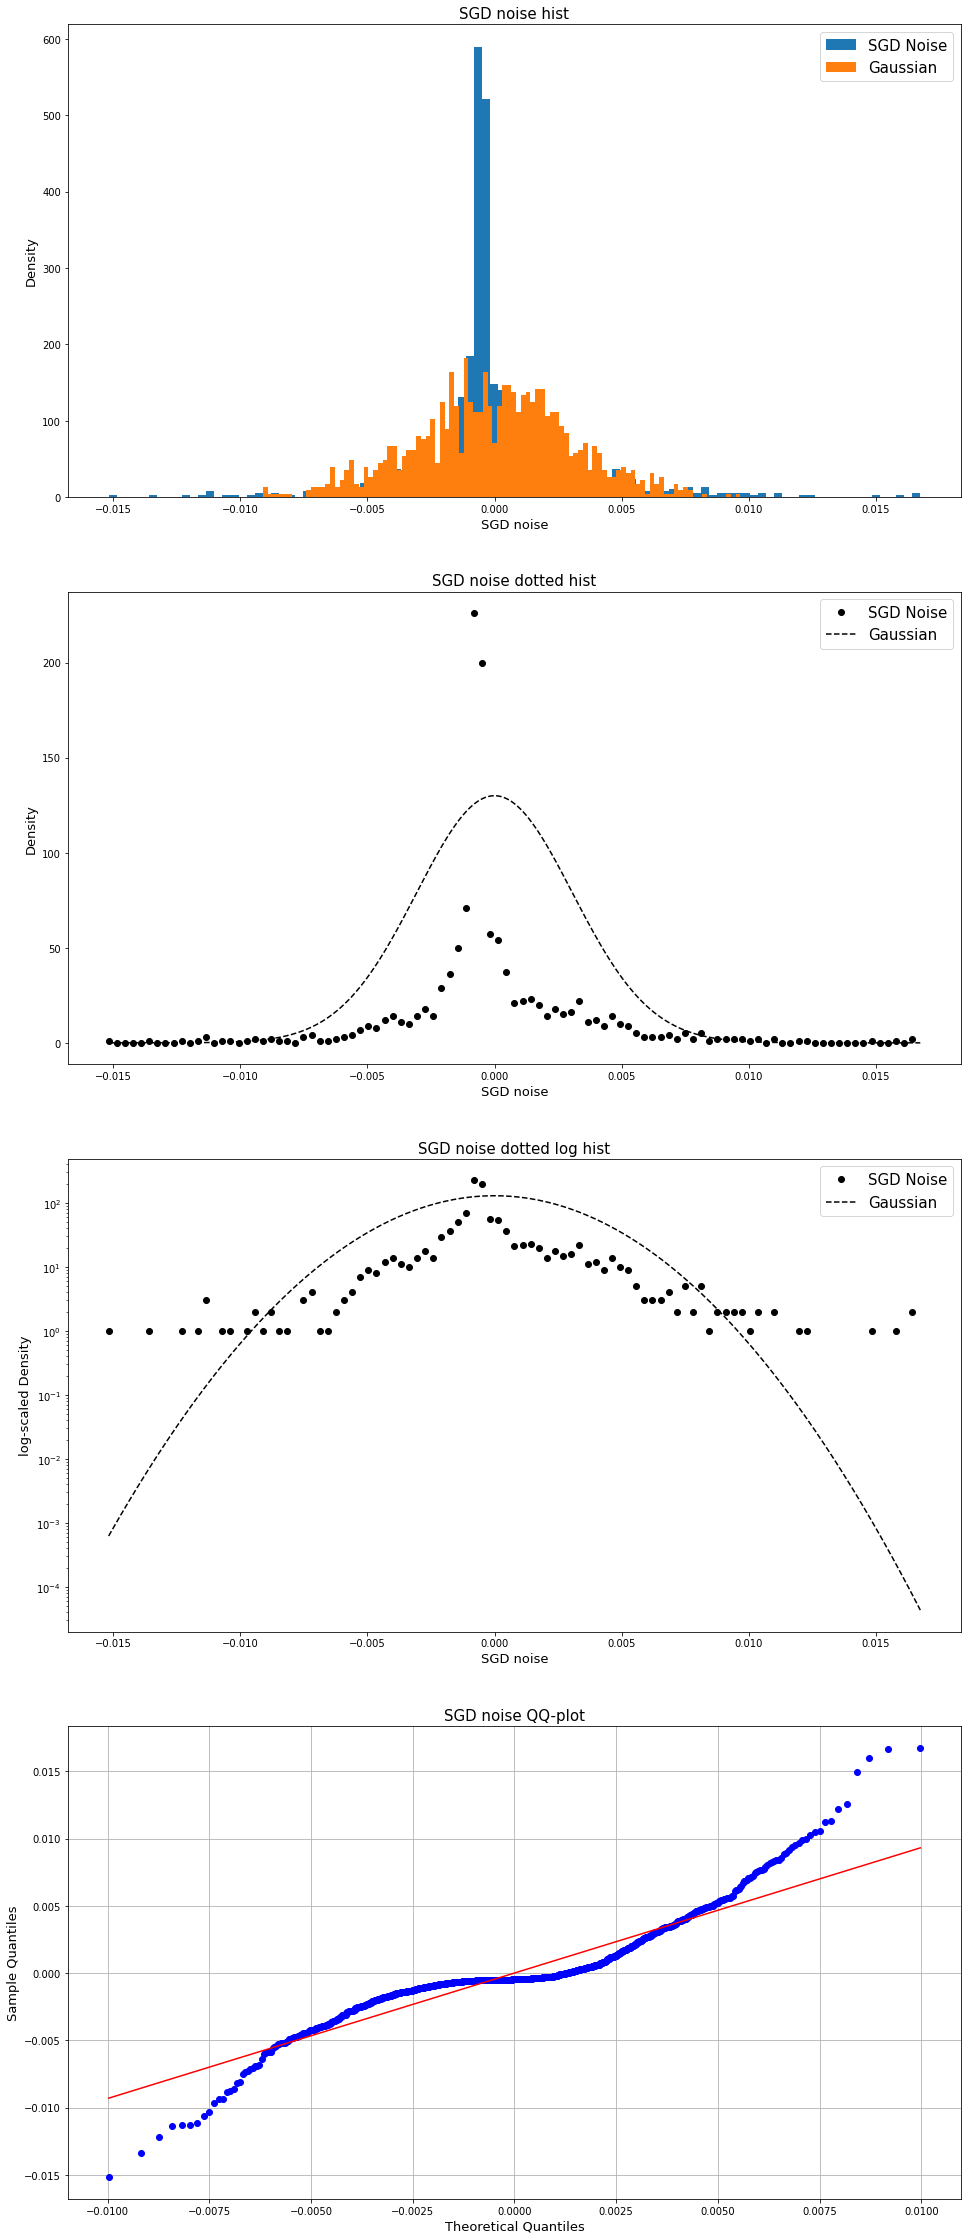

In [73]:
SGD_noise_distplots(SGD_noise=sgn_storage[-1][111], distribution=norm, dist_name='Gaussian', bins=100)

## Conv2

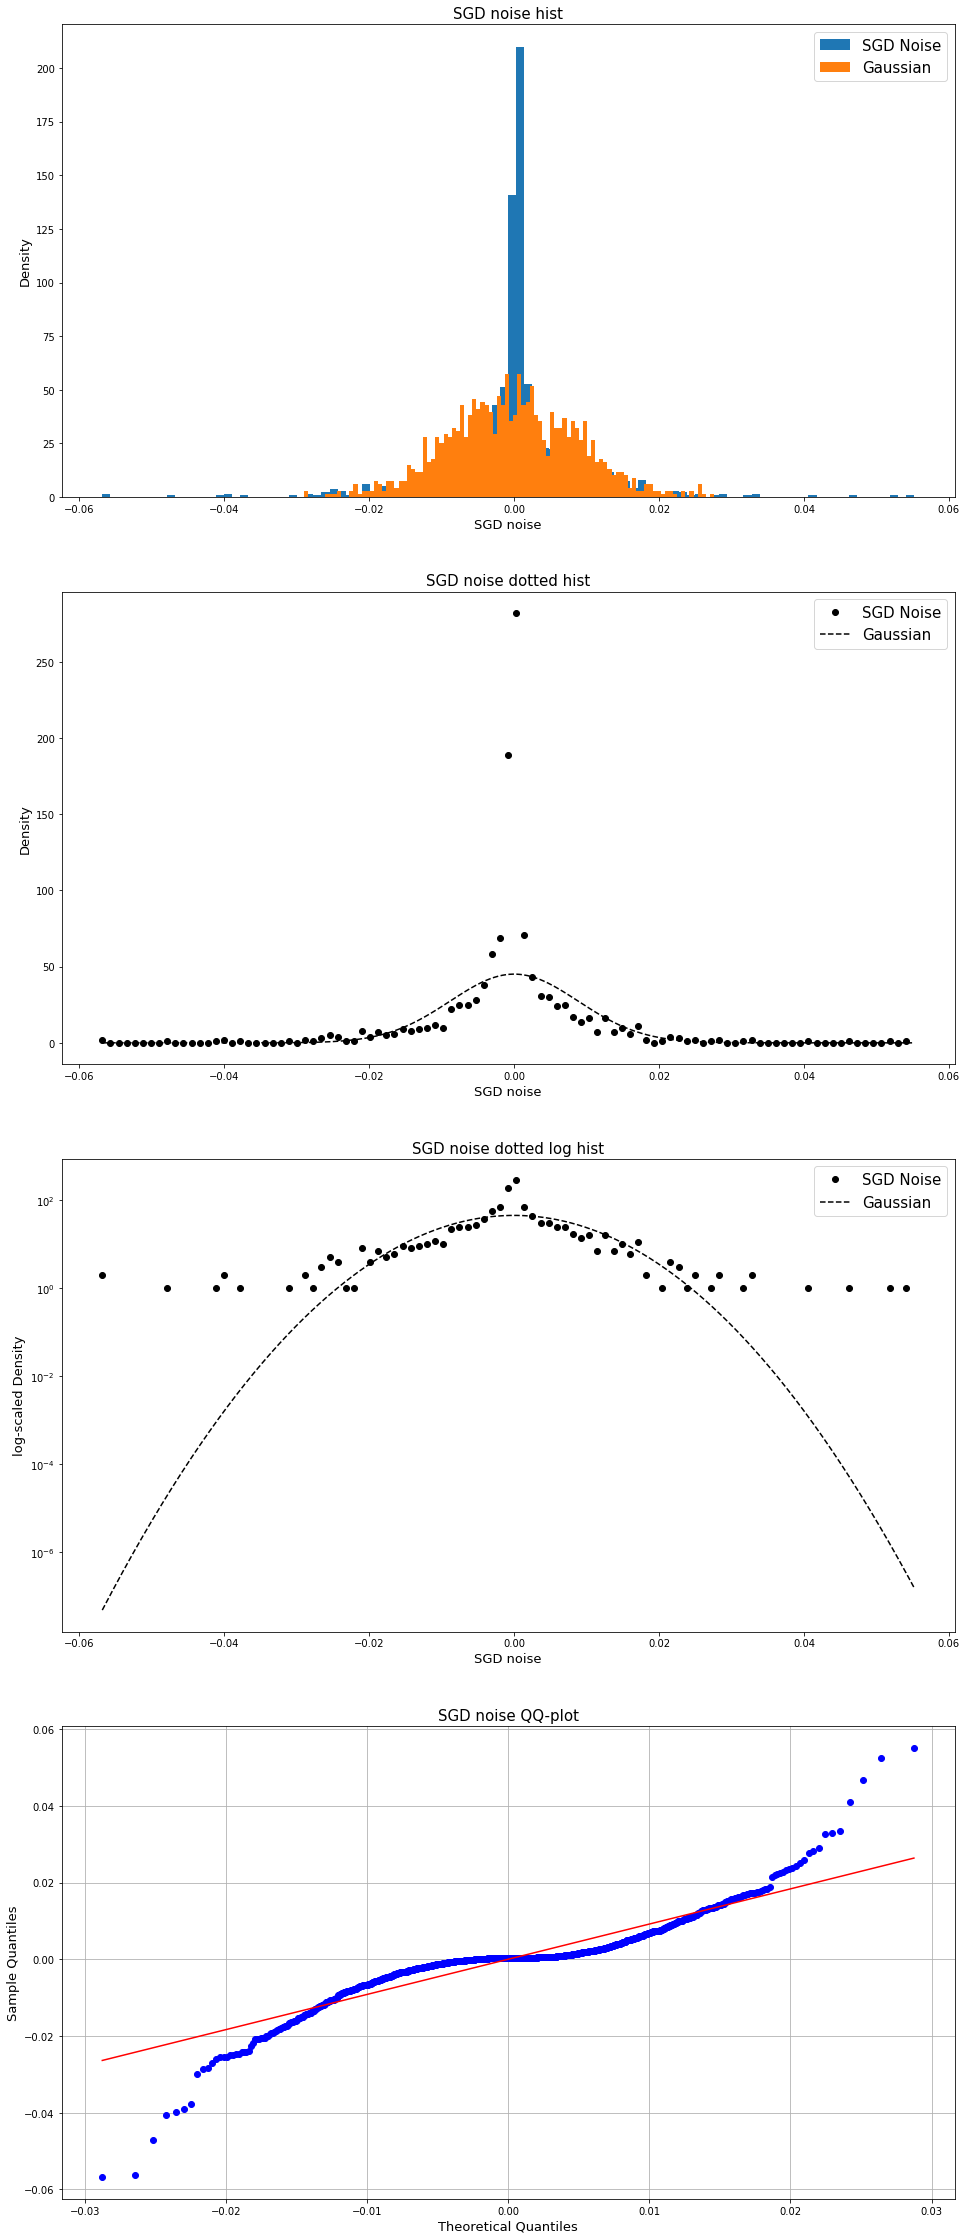

In [74]:
SGD_noise_distplots(SGD_noise=sgn_storage[-1][300], distribution=norm, dist_name='Gaussian', bins=100)

## Linear 1

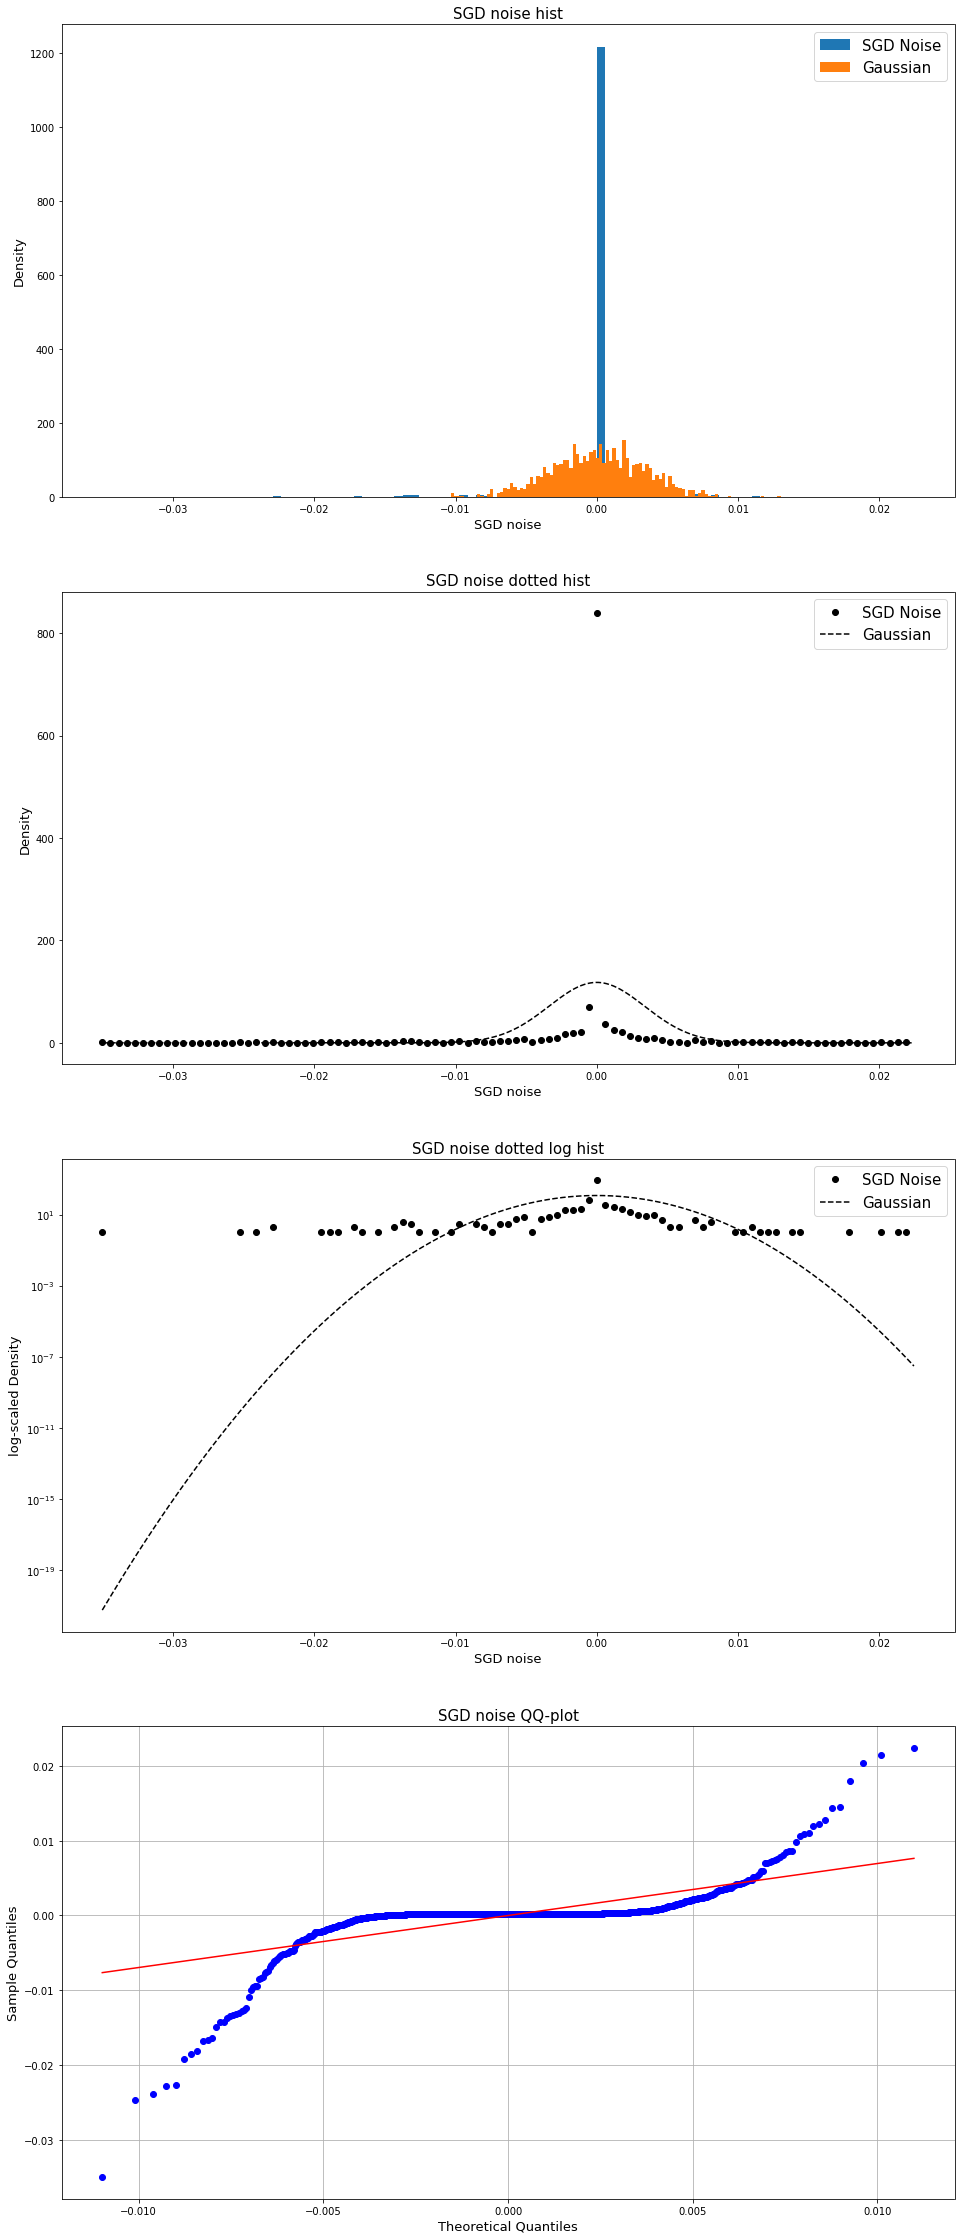

In [77]:
SGD_noise_distplots(SGD_noise=sgn_storage[-1][20000], distribution=norm, dist_name='Gaussian', bins=100)

## Linear 2

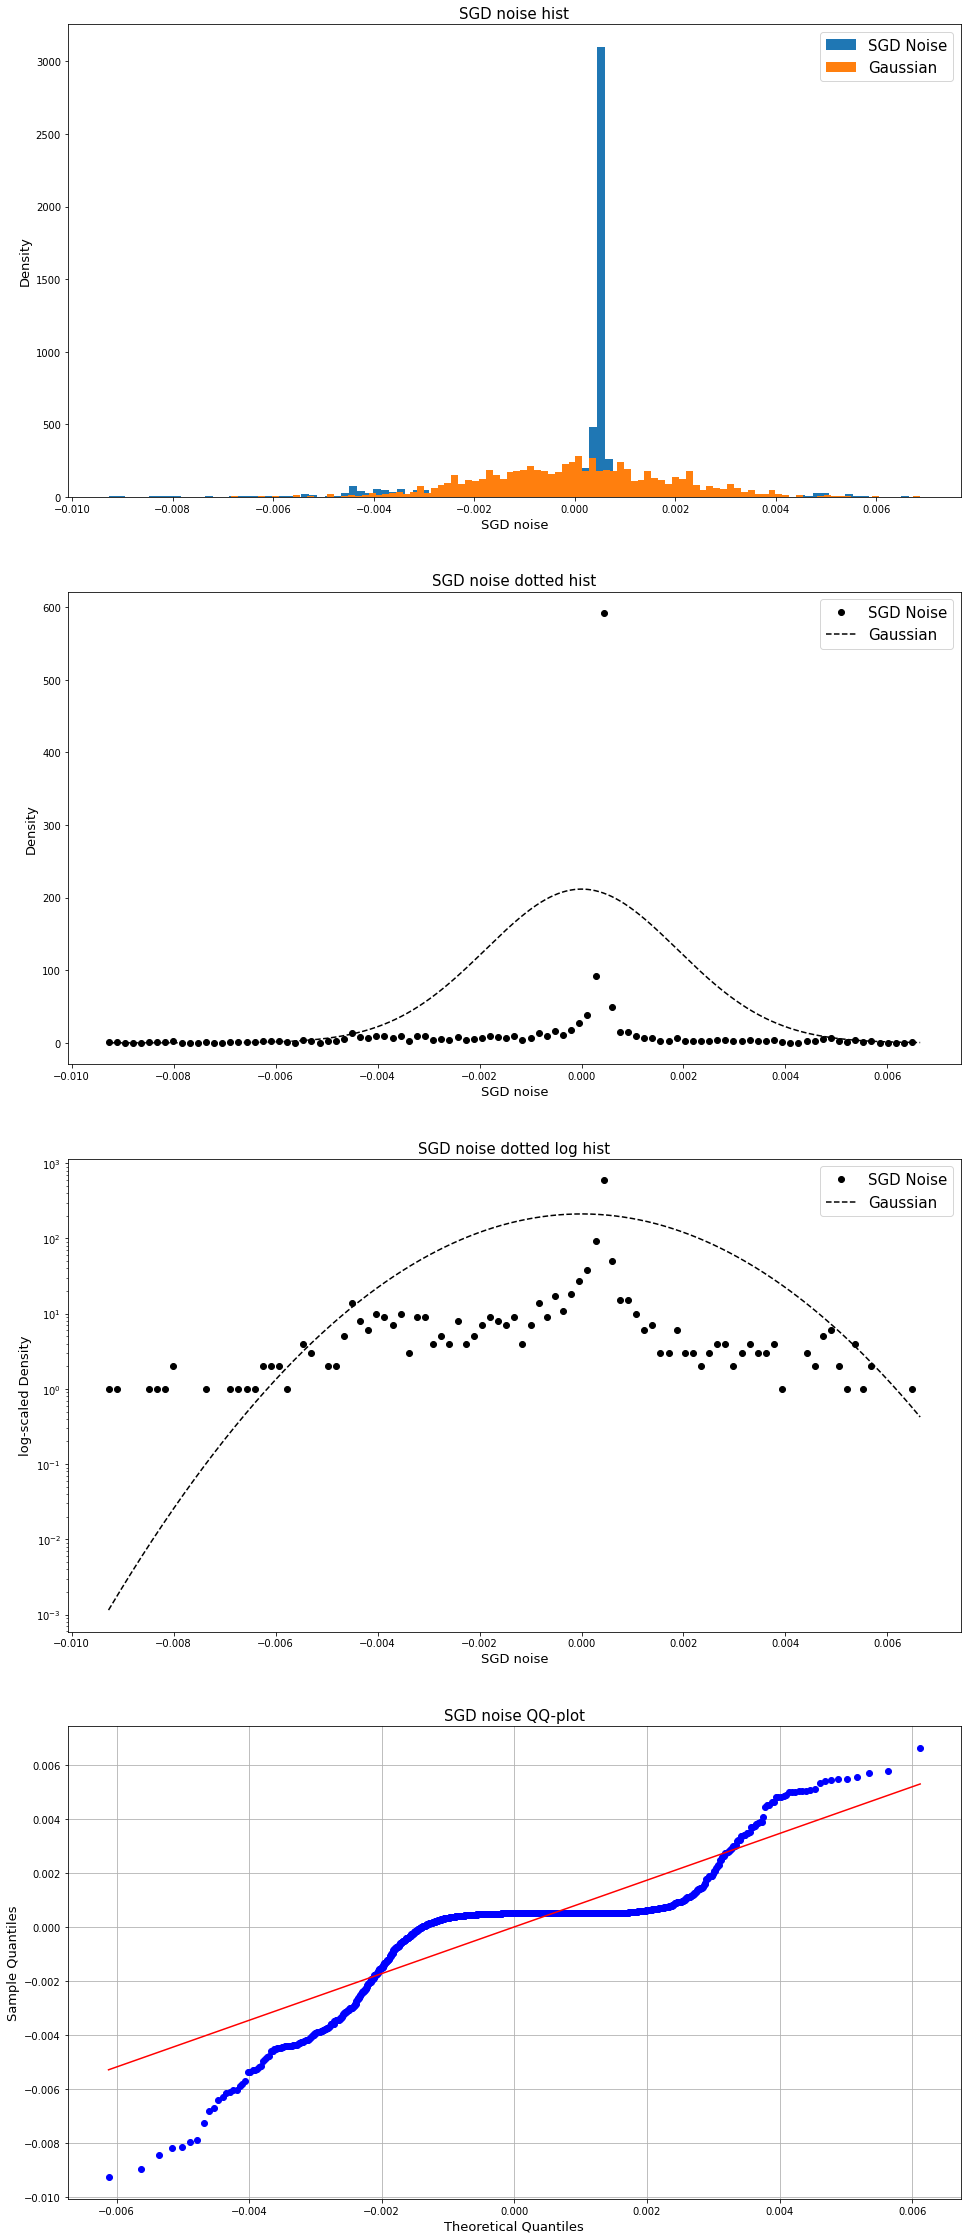

In [78]:
SGD_noise_distplots(SGD_noise=sgn_storage[-1][-1], distribution=norm, dist_name='Gaussian', bins=100)

# Alpha  distribution over neurons and layers

In [174]:
from scipy.stats import levy_stable
import numpy as np

points = 1000000
jennys_constant = 8675309
alpha, beta = 1.8, -0.5

draw = levy_stable.rvs(alpha, beta, size=points, random_state=jennys_constant)

# use scipy's quantile estimator to estimate the parameters and convert to S parameterization
pconv = lambda alpha, beta, mu, sigma: (alpha, beta, mu - sigma * beta * np.tan(np.pi * alpha / 2.0), sigma)
pconv(*levy_stable._fitstart(draw))

(1.7990380668349144,
 -0.5661063359664295,
 -0.012873575589969516,
 0.9982760037056841)

In [176]:
len(sgn_storage)

119

In [178]:
sgn_storage[-1][-1].shape

(1200,)

In [191]:
pconv = lambda alpha, beta, mu, sigma: (alpha, beta, mu - sigma * beta * np.tan(np.pi * alpha / 2.0), sigma)
pconv(*levy_stable._fitstart(sgn_storage[-1][18000]))

/Users/fingon/.pyenv/versions/3.7.8/envs/my-l-environ-3.7.8/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4792: RuntimeWarning: invalid value encountered in double_scalars
  nu_alpha = (p95 - p05)/(p75 - p25)
/Users/fingon/.pyenv/versions/3.7.8/envs/my-l-environ-3.7.8/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4793: RuntimeWarning: invalid value encountered in double_scalars
  nu_beta = (p95 + p05 - 2*p50)/(p95 - p05)


(2.0, nan, nan, nan)

## Last iteration

/Users/fingon/.pyenv/versions/3.7.8/envs/my-l-environ-3.7.8/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

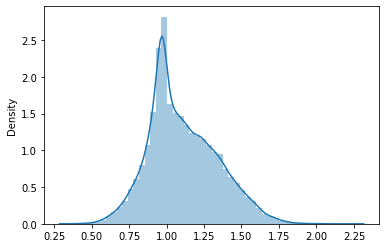

In [223]:
alpha_stab_12000=np.apply_along_axis(alpha_estimator,axis=1, arr=sgn_storage[-1])
sns.distplot(alpha_stab_12000,norm_hist=True)

## First iteration

/Users/fingon/.pyenv/versions/3.7.8/envs/my-l-environ-3.7.8/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

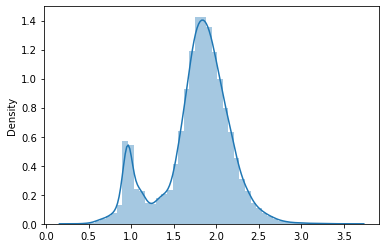

In [224]:

alpha_stab_first=np.apply_along_axis(alpha_estimator,axis=1, arr=sgn_storage[0])
sns.distplot(alpha_stab_first,norm_hist=True)

/Users/fingon/.pyenv/versions/3.7.8/envs/my-l-environ-3.7.8/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

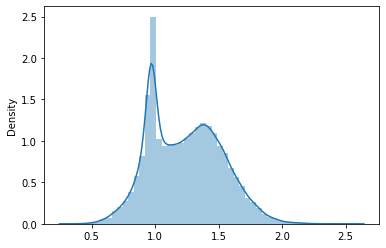

In [226]:
alpha_stab_middle=np.apply_along_axis(alpha_estimator,axis=1, arr=sgn_storage[50])
sns.distplot(alpha_stab_middle,norm_hist=True)

/Users/fingon/.pyenv/versions/3.7.8/envs/my-l-environ-3.7.8/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

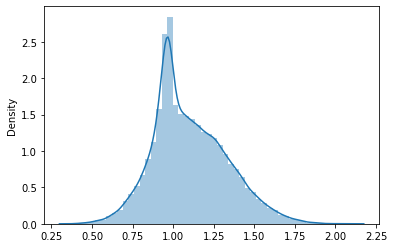

In [227]:
alpha_stab_100=np.apply_along_axis(alpha_estimator,axis=1, arr=sgn_storage[100])
sns.distplot(alpha_stab_100,norm_hist=True)

# Alpha distribution over layers
we look at distribution of alpha for 2 convolutional and 2 linear layers separately

In [248]:
filepath='exp_ml/grads_batch_100'
layers=[0,150, 156, 1020, 1036, 34636, 34720, 35560, 35570]
ax={1:ax1,50:ax50,100:ax100,120:ax120}
alpha_layers_dist_list={1:{'Conv1':[],'Relu1':[],'Conv2':[],'Relu2':[],'Linear1':[],'Relu3':[],'Linear2':[],'Softmax':[]},
                       50:{'Conv1':[],'Relu1':[],'Conv2':[],'Relu2':[],'Linear1':[],'Relu3':[],'Linear2':[],'Softmax':[]},
                       100: {'Conv1':[],'Relu1':[],'Conv2':[],'Relu2':[],'Linear1':[],'Relu3':[],'Linear2':[],'Softmax':[]},
                        120:{'Conv1':[],'Relu1':[],'Conv2':[],'Relu2':[],'Linear1':[],'Relu3':[],'Linear2':[],'Softmax':[]}
                        }
layer_names=['Conv1','Relu1','Conv2','Relu2','Linear1','Relu3','Linear2','Softmax']
for itera in [1,50,100,120]:
    batch_grads = []
    with open(filepath + f'_logiter_{itera}.npy', 'rb') as file:
        for _ in range(N):
            batch_grads.append(np.load(file))
    
    sgn = (np.array(batch_grads) - np.array(batch_grads).sum(axis=0) / N).T
    del(batch_grads)
    for number in range(0,len(layers)-1):
        gradients_layer=sgn[layers[number]:layers[number+1],:]
        print(gradients_layer.shape)
        gradients_layer=gradients_layer[~np.any(gradients_layer == 0, axis=1), :]
        
        alpha_layers_dist_list[itera][layer_names[number]].append(np.apply_along_axis(alpha_estimator, axis=1, arr=gradients_layer))

        


(150, 200)
(6, 200)
(864, 200)
(16, 200)
(33600, 200)
(84, 200)
(840, 200)
(10, 200)
(150, 200)
(6, 200)
(864, 200)
(16, 200)
(33600, 200)
(84, 200)
(840, 200)
(10, 200)
(150, 200)
(6, 200)
(864, 200)
(16, 200)
(33600, 200)
(84, 200)
(840, 200)
(10, 200)
(150, 200)
(6, 200)
(864, 200)
(16, 200)
(33600, 200)
(84, 200)
(840, 200)
(10, 200)


# Batch size=50

In [254]:
alpha_layers_dist_list[itera][layer_names[number]]

[array([1.13824564, 1.49438287, 1.71724181, 0.9450563 , 0.56976215,
        1.33250185, 1.07464956, 0.88119817, 1.26417514, 1.56059166])]

/Users/fingon/.pyenv/versions/3.7.8/envs/my-l-environ-3.7.8/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/fingon/.pyenv/versions/3.7.8/envs/my-l-environ-3.7.8/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/fingon/.pyenv/versions/3.7.8/envs/my-l-environ-3.7.8/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a futur

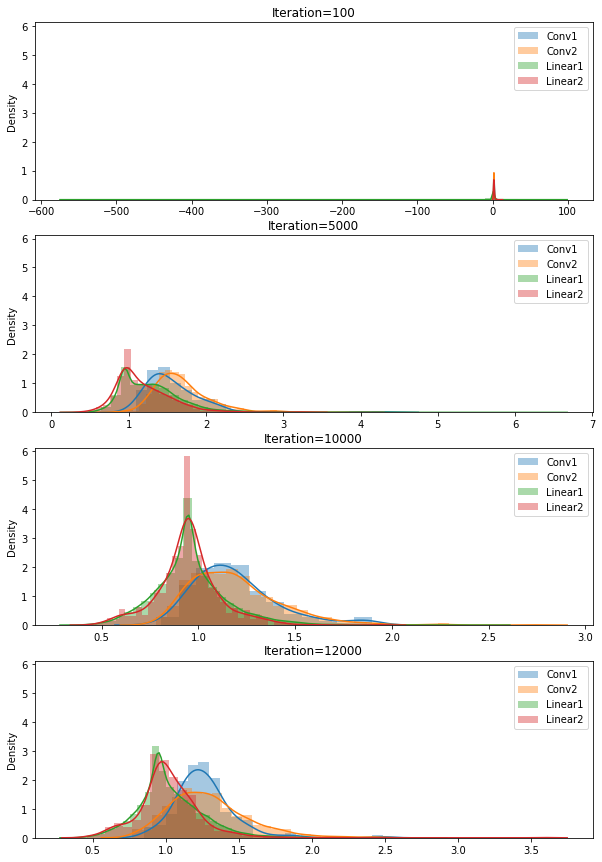

In [260]:

f, (ax1, ax50,ax100,ax120) = plt.subplots(4, 1, sharey=True,figsize=(10,15))
ax={1:ax1,50:ax50,100:ax100,120:ax120}
plot_list=['Conv1','Conv2','Linear1','Linear2']
for itera in [1,50,100,120]:
    for number in range(0,len(layers)-1):
        if layer_names[number] in plot_list:
            sns.distplot(alpha_layers_dist_list[itera][layer_names[number]],label=layer_names[number],ax=ax[itera],
                    norm_hist=True)
            ax[itera].legend()
            ax[itera].set_title(f'Iteration={itera*100}')
            #ax[itera].set_xlim(-1,7)

400.0

/Users/fingon/.pyenv/versions/3.7.8/envs/my-l-environ-3.7.8/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/fingon/.pyenv/versions/3.7.8/envs/my-l-environ-3.7.8/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/fingon/.pyenv/versions/3.7.8/envs/my-l-environ-3.7.8/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a futur

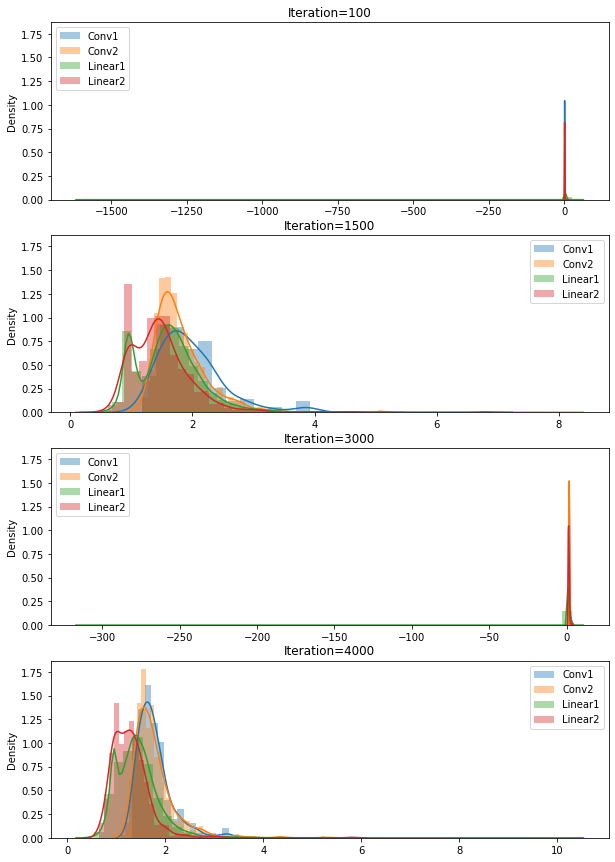

In [264]:
filepath='exp_ml/grads_batch_150'

layers=[0,150, 156, 1020, 1036, 34636, 34720, 35560, 35570]
ax={1:ax1,15:ax50,30:ax100,40:ax120}
alpha_layers_dist_list={1:{'Conv1':[],'Relu1':[],'Conv2':[],'Relu2':[],'Linear1':[],'Relu3':[],'Linear2':[],'Softmax':[]},
                       15:{'Conv1':[],'Relu1':[],'Conv2':[],'Relu2':[],'Linear1':[],'Relu3':[],'Linear2':[],'Softmax':[]},
                       30: {'Conv1':[],'Relu1':[],'Conv2':[],'Relu2':[],'Linear1':[],'Relu3':[],'Linear2':[],'Softmax':[]},
                        40:{'Conv1':[],'Relu1':[],'Conv2':[],'Relu2':[],'Linear1':[],'Relu3':[],'Linear2':[],'Softmax':[]}
                        }
layer_names=['Conv1','Relu1','Conv2','Relu2','Linear1','Relu3','Linear2','Softmax']
for itera in [1,15,30,40]:
    batch_grads = []
    with open(filepath + f'_logiter_{itera}.npy', 'rb') as file:
        for _ in range(N):
            batch_grads.append(np.load(file))
    
    sgn = (np.array(batch_grads) - np.array(batch_grads).sum(axis=0) / N).T
    del(batch_grads)
    for number in range(0,len(layers)-1):
        gradients_layer=sgn[layers[number]:layers[number+1],:]
        
        gradients_layer=gradients_layer[~np.any(gradients_layer == 0, axis=1), :]
        
        alpha_layers_dist_list[itera][layer_names[number]].append(np.apply_along_axis(alpha_estimator, axis=1, arr=gradients_layer))

        
f, (ax1, ax50,ax100,ax120) = plt.subplots(4, 1, sharey=True,figsize=(10,15))
ax={1:ax1,15:ax50,30:ax100,40:ax120}
plot_list=['Conv1','Conv2','Linear1','Linear2']
for itera in [1,15,30,40]:
    for number in range(0,len(layers)-1):
        if layer_names[number] in plot_list:
            sns.distplot(alpha_layers_dist_list[itera][layer_names[number]],label=layer_names[number],ax=ax[itera],
                    norm_hist=True)
            ax[itera].legend()
            ax[itera].set_title(f'Iteration={itera*100}')
            #ax[itera].set_subtitle('Alpha distribution of sgn for batch size =150')

/Users/fingon/.pyenv/versions/3.7.8/envs/my-l-environ-3.7.8/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/fingon/.pyenv/versions/3.7.8/envs/my-l-environ-3.7.8/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/fingon/.pyenv/versions/3.7.8/envs/my-l-environ-3.7.8/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a futur

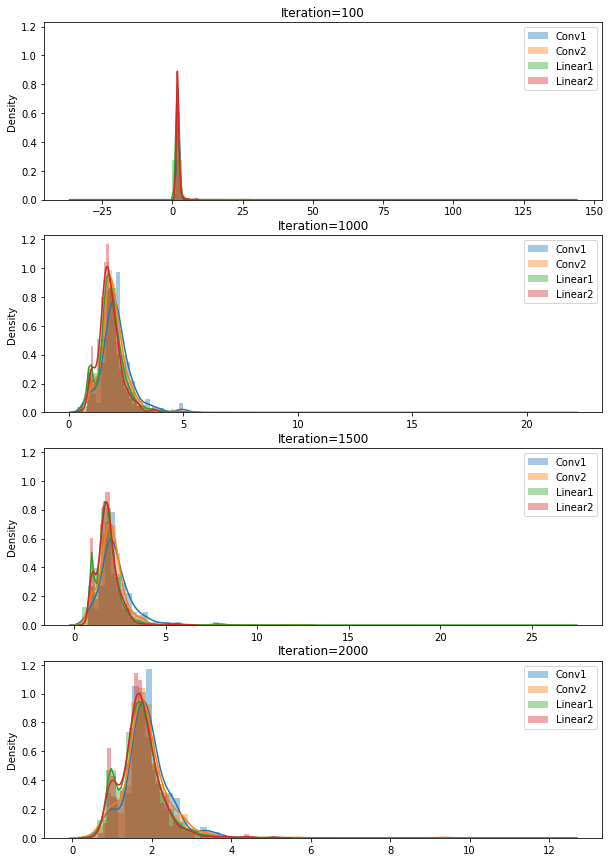

In [266]:
filepath='exp_ml/grads_batch_300'
f, (ax1, ax10,ax15,ax20) = plt.subplots(4, 1, sharey=True,figsize=(10,15))


layers=[0,150, 156, 1020, 1036, 34636, 34720, 35560, 35570]
ax={1:ax1,10:ax10,15:ax15,20:ax20}
alpha_layers_dist_list={1:{'Conv1':[],'Relu1':[],'Conv2':[],'Relu2':[],'Linear1':[],'Relu3':[],'Linear2':[],'Softmax':[]},
                       10:{'Conv1':[],'Relu1':[],'Conv2':[],'Relu2':[],'Linear1':[],'Relu3':[],'Linear2':[],'Softmax':[]},
                       15: {'Conv1':[],'Relu1':[],'Conv2':[],'Relu2':[],'Linear1':[],'Relu3':[],'Linear2':[],'Softmax':[]},
                        20:{'Conv1':[],'Relu1':[],'Conv2':[],'Relu2':[],'Linear1':[],'Relu3':[],'Linear2':[],'Softmax':[]}
                        }
layer_names=['Conv1','Relu1','Conv2','Relu2','Linear1','Relu3','Linear2','Softmax']
for itera in [1,10,15,20]:
    batch_grads = []
    with open(filepath + f'_logiter_{itera}.npy', 'rb') as file:
        for _ in range(N):
            batch_grads.append(np.load(file))
    
    sgn = (np.array(batch_grads) - np.array(batch_grads).sum(axis=0) / N).T
    del(batch_grads)
    for number in range(0,len(layers)-1):
        gradients_layer=sgn[layers[number]:layers[number+1],:]
        
        gradients_layer=gradients_layer[~np.any(gradients_layer == 0, axis=1), :]
        
        alpha_layers_dist_list[itera][layer_names[number]].append(np.apply_along_axis(alpha_estimator, axis=1, arr=gradients_layer))

        
ax={1:ax1,10:ax10,15:ax15,20:ax20}
plot_list=['Conv1','Conv2','Linear1','Linear2']
for itera in [1,10,15,20]:
    for number in range(0,len(layers)-1):
        if layer_names[number] in plot_list:
            sns.distplot(alpha_layers_dist_list[itera][layer_names[number]],label=layer_names[number],ax=ax[itera],
                    norm_hist=True)
            ax[itera].legend()
            ax[itera].set_title(f'Iteration={itera*100}')
            #ax[itera].set_subtitle('Alpha distribution of sgn for batch size =150')